<a href="https://colab.research.google.com/github/Eve-1978/Capstone-Project/blob/main/Solar%20Panel%20Dust%20Detection%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset sources: https://www.kaggle.com/datasets/hemanthsai7/solar-panel-dust-detection

In [1]:
from IPython.display import HTML, display

display(HTML("""
<script>
  function ClickConnect(){
    console.log("🤖 Ping!");
    document.querySelector("colab-toolbar-button#connect").click();
  }
  setInterval(ClickConnect, 5 * 60 * 1000);  // every 5 minutes
</script>
"""))

# **Import Libraries**

In [2]:
!pip install seaborn
!pip install tensorflow
!pip install keras
!pip install scikit-Image
!pip install opencv-python

# Import required libraries
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns
import cv2
import os
import shutil
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

from skimage.feature import local_binary_pattern
from skimage import filters, measure

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3, DenseNet121, ResNet50, MobileNetV2, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import preprocess_input


# Phase 1: Data Collection and Preprocessing

## Upload Dataset

In [3]:
# Upload dataset
from google.colab import drive
drive.mount('/content/drive')

#unzip the file
zip_path = '/content/drive/MyDrive/Detect_solar_dust.zip'
extract_path = '/content/solar-dust-detection'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to: {extract_path}")

# Point at the "inner" directory
base_dir = '/content/solar-dust-detection/Detect_solar_dust'

# Build your class-folder paths
clean_dir = os.path.join(base_dir, 'Clean')
dusty_dir = os.path.join(base_dir, 'Dusty')

print("Clean Images:", len(os.listdir(clean_dir)))
print("Dusty Images:", len(os.listdir(dusty_dir)))
print("\n==================")
print("Total Images:", len(os.listdir(clean_dir)) + len(os.listdir(dusty_dir)))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset extracted to: /content/solar-dust-detection
Clean Images: 1493
Dusty Images: 1069

Total Images: 2562


# Simple Data Exploration (EDA)

Exploring the data


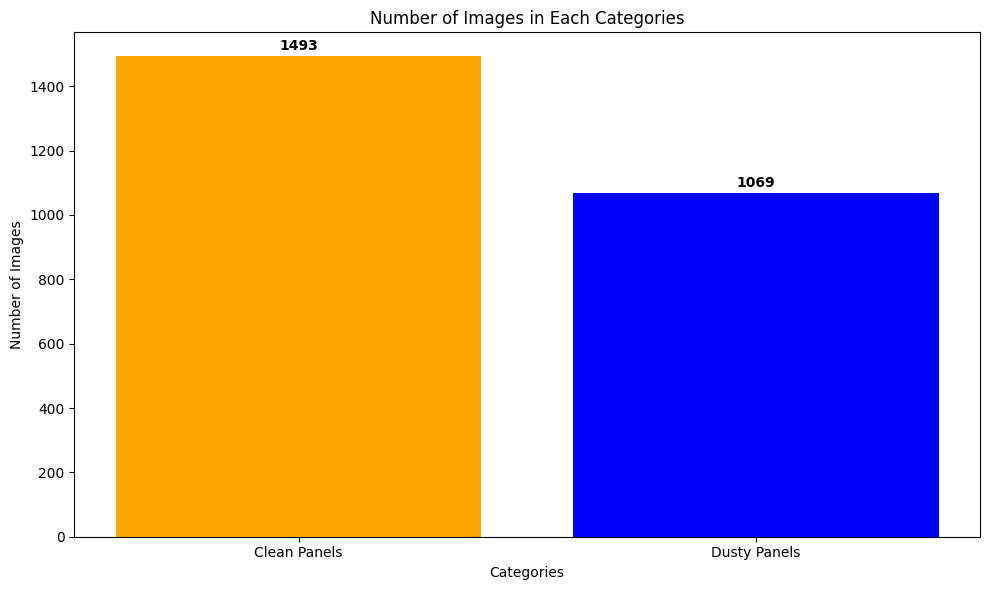

In [4]:
# Simple Data Exploration (EDA)
print("Exploring the data")

# Create a simple barchart
categories = ['Clean Panels', 'Dusty Panels']
counts = [len(os.listdir(clean_dir)), len(os.listdir(dusty_dir))]
colors = ['orange', 'blue']

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=colors)
plt.title('Number of Images in Each Categories')
plt.xlabel('Categories')
plt.ylabel('Number of Images')

# Add numbers on top of bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

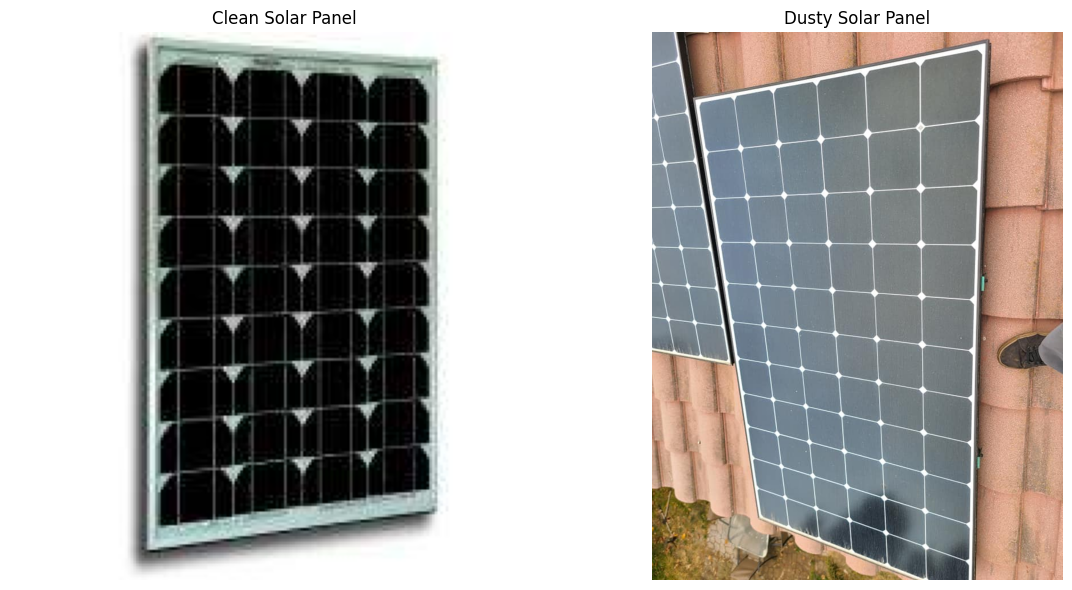

In [5]:
# Show sample images
clean_files = os.listdir(clean_dir)
dusty_files = os.listdir(dusty_dir)

plt.figure(figsize=(12, 6))

# Clean images
plt.subplot(1, 2, 1)
clean_img = plt.imread(os.path.join(clean_dir, random.choice(clean_files)))
plt.imshow(clean_img)
plt.title('Clean Solar Panel')
plt.axis('off')

# Dusty images
plt.subplot(1, 2, 2)
dusty_img = plt.imread(os.path.join(dusty_dir, random.choice(dusty_files)))
plt.imshow(dusty_img)
plt.title('Dusty Solar Panel')
plt.axis('off')

plt.tight_layout()
plt.show()

# Data Preprocessing

## Making main folders for train and test

In [6]:
# Making main folders for train and test data
print("Creating train and test folders...")

# Define the paths for train and test directories within base_dir
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

os.makedirs('/content/train/Clean', exist_ok=True)
os.makedirs('/content/train/Dusty', exist_ok=True)
os.makedirs('/content/test/Clean', exist_ok=True)
os.makedirs('/content/test/Dusty', exist_ok=True)

print("\nAll folders has been created.")

Creating train and test folders...

All folders has been created.


## Splitting Clean images to Train & Test data

In [7]:
# Split clean images (80% train, 20% test)
print("Splitting Clean Images...")
clean_files = os.listdir(clean_dir)
np.random.shuffle(clean_files)

total_clean = len(clean_files)
train_clean_count = int(total_clean * 0.8)

train_clean = clean_files[:train_clean_count]
test_clean = clean_files[train_clean_count:]

print(f"\nTrain Clean: {len(train_clean)}")
print(f"Test Clean: {len(test_clean)}")

# Use the paths created earlier
train_clean_dest = '/content/train/Clean'
test_clean_dest = '/content/test/Clean'

# Clear destination directories before copying to prevent duplicates from reruns
if os.path.exists(train_clean_dest):
    shutil.rmtree(train_clean_dest)
os.makedirs(train_clean_dest, exist_ok=True)

if os.path.exists(test_clean_dest):
    shutil.rmtree(test_clean_dest)
os.makedirs(test_clean_dest, exist_ok=True)


for file in train_clean:
    src = os.path.join(clean_dir, file)
    dst = os.path.join(train_clean_dest, file)
    shutil.copy2(src, dst)

for file in test_clean:
    src = os.path.join(clean_dir, file)
    dst = os.path.join(test_clean_dest, file)
    shutil.copy2(src, dst)

print(f"\nClean images split: {len(train_clean)} train, {len(test_clean)} test")

Splitting Clean Images...

Train Clean: 1194
Test Clean: 299

Clean images split: 1194 train, 299 test


## Splitting Dusty images to Train & Test data

In [8]:
# Split dusty images
print("Splitting Dusty Images...")
dusty_files = os.listdir(dusty_dir)
np.random.shuffle(dusty_files)

total_dusty = len(dusty_files)
train_dusty_count = int(total_dusty * 0.8)

train_dusty = dusty_files[:train_dusty_count]
test_dusty = dusty_files[train_dusty_count:]

print(f"\nTrain Dusty: {len(train_dusty)}")
print(f"Test Dusty: {len(test_dusty)}")

# Use the paths created earlier
train_dusty_dest = '/content/train/Dusty'
test_dusty_dest = '/content/test/Dusty'

# Clear destination directories before copying
if os.path.exists(train_dusty_dest):
    shutil.rmtree(train_dusty_dest)
os.makedirs(train_dusty_dest, exist_ok=True)

if os.path.exists(test_dusty_dest):
    shutil.rmtree(test_dusty_dest)
os.makedirs(test_dusty_dest, exist_ok=True)


for file in train_dusty:
    src = os.path.join(dusty_dir, file)
    dst = os.path.join(train_dusty_dest, file)
    shutil.copy2(src, dst)

for file in test_dusty:
    src = os.path.join(dusty_dir, file)
    dst = os.path.join(test_dusty_dest, file)
    shutil.copy2(src, dst)

print(f"\nDusty images split: {len(train_dusty)} train, {len(test_dusty)} test")

Splitting Dusty Images...

Train Dusty: 855
Test Dusty: 214

Dusty images split: 855 train, 214 test


In [9]:
print("Folders checking...")

print(f"\nTrain Clean: {len(os.listdir('/content/train/Clean'))}")
print(f"Train Dusty: {len(os.listdir('/content/train/Dusty'))}")

print(f"\nTest Clean: {len(os.listdir('/content/test/Clean'))}")
print(f"Test Dusty: {len(os.listdir('/content/test/Dusty'))}")

total_train = len(os.listdir('/content/train/Clean')) + len(os.listdir('/content/train/Dusty'))
total_test = len(os.listdir('/content/test/Clean')) + len(os.listdir('/content/test/Dusty'))

print(f"\nTotal Train: {total_train}")
print(f"Total Test: {total_test}")

print("\nData split completed.")

Folders checking...

Train Clean: 1194
Train Dusty: 855

Test Clean: 299
Test Dusty: 214

Total Train: 2049
Total Test: 513

Data split completed.


## Simple Image Processing

Demonstrating image processing...


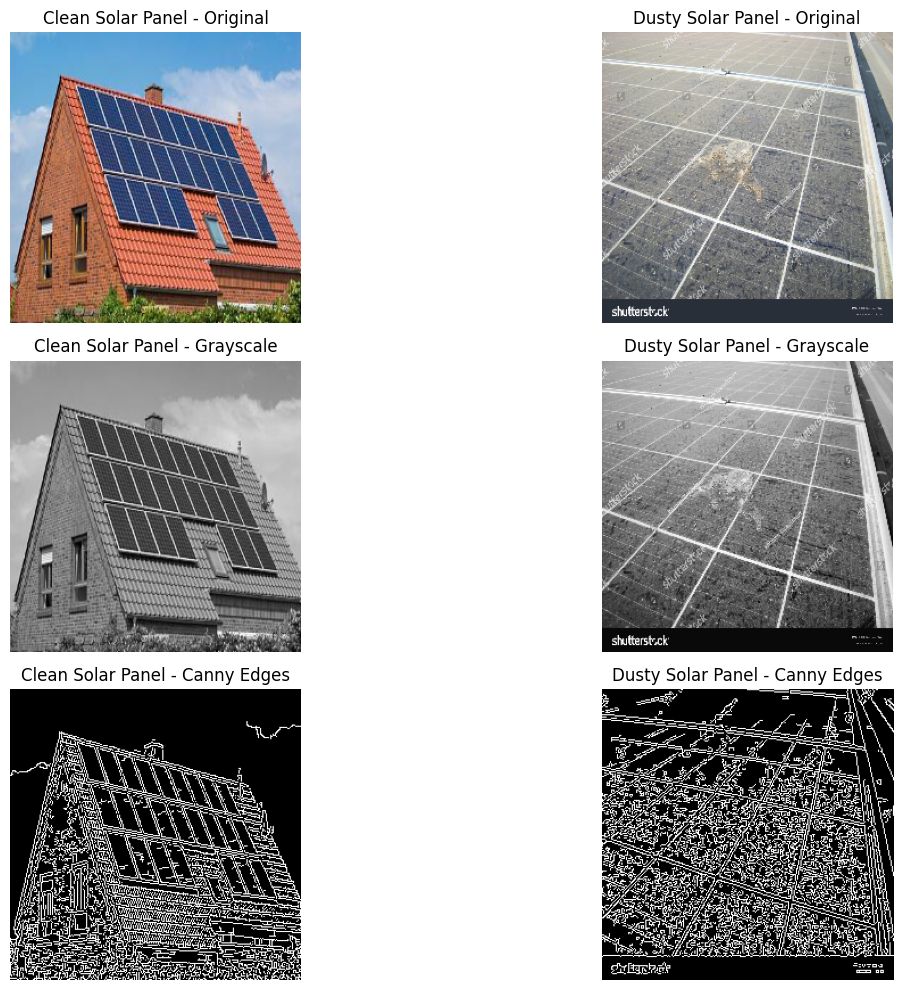


Clean Solar Panel - Brightness: 126.16140747070312
Dusty Solar Panel - Brightness: 144.86346435546875
Clean Solar Panel - Edge Pixels: 13945
Dusty Solar Panel - Edge Pixels: 16645

Image processing demonstration completed.


In [10]:
def show_image_processing(clean_dir, dusty_dir):
    print("Demonstrating image processing...")

    # Load each clean and dusty image
    clean_files = os.listdir(clean_dir)
    dusty_files = os.listdir(dusty_dir)

    clean_img = plt.imread(os.path.join(clean_dir, clean_files[0]))
    dusty_img = plt.imread(os.path.join(dusty_dir, dusty_files[0]))

    # Resize images to same size
    clean_img = cv2.resize(clean_img, (256, 256))
    dusty_img = cv2.resize(dusty_img, (256, 256))

    # Convert to grayscale for processing
    clean_gray = cv2.cvtColor(clean_img, cv2.COLOR_RGB2GRAY)
    dusty_gray = cv2.cvtColor(dusty_img, cv2.COLOR_RGB2GRAY)

    # Apply canny edge detection
    clean_edges = cv2.Canny(clean_gray, 50, 150)
    dusty_edges = cv2.Canny(dusty_gray, 50, 150)

    plt.figure(figsize=(15, 10))

    # Original images
    plt.subplot(3, 2, 1)
    plt.imshow(clean_img)
    plt.title('Clean Solar Panel - Original')
    plt.axis('off')

    plt.subplot(3, 2, 2)
    plt.imshow(dusty_img)
    plt.title('Dusty Solar Panel - Original')
    plt.axis('off')

    # Grayscale images
    plt.subplot(3, 2, 3)
    plt.imshow(clean_gray, cmap='gray')
    plt.title('Clean Solar Panel - Grayscale')
    plt.axis('off')

    plt.subplot(3, 2, 4)
    plt.imshow(dusty_gray, cmap='gray')
    plt.title('Dusty Solar Panel - Grayscale')
    plt.axis('off')

    # Canny Edge Detection
    plt.subplot(3, 2, 5)
    plt.imshow(clean_edges, cmap='gray')
    plt.title('Clean Solar Panel - Canny Edges')
    plt.axis('off')

    plt.subplot(3, 2, 6)
    plt.imshow(dusty_edges, cmap='gray')
    plt.title('Dusty Solar Panel - Canny Edges')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Calculate statistics
    clean_brightness = np.mean(clean_gray)
    dusty_brightness = np.mean(dusty_gray)
    clean_edge_count = np.sum(clean_edges > 0)
    dusty_edge_count = np.sum(dusty_edges > 0)

    print(f"\nClean Solar Panel - Brightness: {clean_brightness}")
    print(f"Dusty Solar Panel - Brightness: {dusty_brightness}")
    print(f"Clean Solar Panel - Edge Pixels: {clean_edge_count}")
    print(f"Dusty Solar Panel - Edge Pixels: {dusty_edge_count}")

    print("\nImage processing demonstration completed.")

show_image_processing(clean_dir, dusty_dir)

## Setup ImageDataGenerators



In [11]:
print("Creating data generators...")

# Target size
target_size = (256, 256)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    brightness_range=(0.7, 1.3),
    channel_shift_range=20,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'binary'
)

test_generator = test_datagen.flow_from_directory(
    '/content/test',
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'binary'
)

print("\n=== Data generators created. ===")
print(f"\nTraining samples: {train_generator.samples}")
print(f"Testing samples: {test_generator.samples}")
print(f"\n Classes: {train_generator.class_indices}")

Creating data generators...
Found 2049 images belonging to 2 classes.
Found 513 images belonging to 2 classes.

=== Data generators created. ===

Training samples: 2049
Testing samples: 513

 Classes: {'Clean': 0, 'Dusty': 1}


# EDA

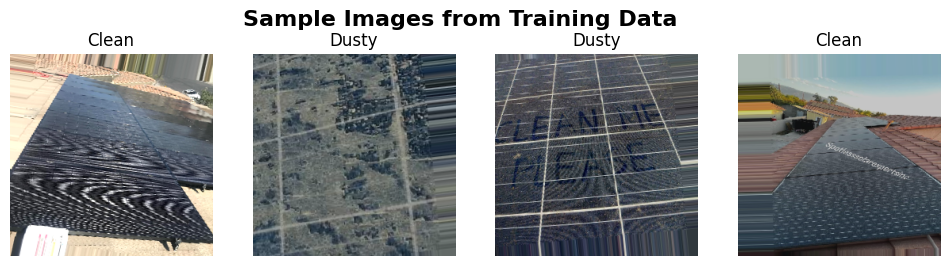

In [12]:
# Visualize some sample images
sample_images, sample_labels = next(train_generator)

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axes[i].imshow(sample_images[i])
    label = "Dusty" if sample_labels[i] == 1 else "Clean"
    axes[i].set_title(f"{label}")
    axes[i].axis('off')

plt.suptitle('Sample Images from Training Data',
             fontsize=16, fontweight='bold')
plt.show()

# Class Weight Calculation

In [12]:
# Class Weight Calculation
def calculate_class_weight(clean_dir, dusty_dir):
    print("Calculating Class weights...")

    # Count files in each folder
    clean_count = len([f for f in os.listdir(clean_dir)
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    dusty_count = len([f for f in os.listdir(dusty_dir)
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    total_samples = clean_count + dusty_count

    # Create label array
    y_labels = np.array([0] * clean_count + [1] * dusty_count)

    # Calculate class weight using sklearn
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_labels),
        y=y_labels
    )

    # Create dictionary
    class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

    print(f"\nDataset Composition:")
    print(f" - Clean Samples: {clean_count} ({clean_count/total_samples * 100:.1f}%)")
    print(f" - Dusty Samples: {dusty_count} ({dusty_count/total_samples * 100:.1f}%)")

    print(f"\nClass Distribution Analysis:")
    print(f" - Class imbalance ratio: {max(clean_count, dusty_count) / min(clean_count, dusty_count):.2f}:1")

    print(f"\nCalculated Class Weights:")
    print(f" - Class 0 (Clean): {class_weights[0]:.4f}")
    print(f" - Class 1 (Dusty): {class_weights[1]:.4f}")
    print(f" - Weight ratio: {class_weights[1] / class_weights[0]:.2f}")
    print(f"\nClass Weights Dictionary: {class_weights_dict}")

    return class_weights_dict, y_labels

In [13]:
def visualize_class_distribution_and_weights(class_weights_dict, y_labels):
    print("Creating Visualizations...")

    # Calculate counts
    unique, counts = np.unique(y_labels, return_counts=True)
    class_names = ['Clean', 'Dusty']

    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Class Distribution and Weights Analysis', fontsize = 16, fontweight = 'bold')

    # == Class distribution barchart ==
    colors = ['purple', 'orange']
    bars = axes[0, 0].bar(class_names, counts, color=colors, alpha = 0.8)
    axes[0, 0].set_title('Class Distribution (Sample Counts)', fontweight = 'bold')
    axes[0, 0].set_xlabel('Class')
    axes[0, 0].set_ylabel('Number of Samples')

    # add value labels on bars
    for bar, count in zip(bars, counts):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                        f'{count}\n{count/sum(counts) * 100:.1f}%',
                        ha='center', va='bottom', fontweight='bold')

    # == Class distribution pie chart ==
    axes[0, 1].pie(counts, labels=class_names, colors = colors,
                   autopct='%1.1f%%', startangle = 90)
    axes[0, 1].set_title('Class Distribution (Percentage)', fontweight = 'bold')

    # == Class weights visualization ==
    weights = [class_weights_dict[0], class_weights_dict[1]]
    bars = axes[1, 0].bar(class_names, weights, color = ['skyblue', 'lightcoral'], alpha = 0.8)
    axes[1, 0].set_title('Calculated Class Weights', fontweight = 'bold')
    axes[1, 0].set_xlabel('Class')
    axes[1, 0].set_ylabel('Weight Value')

    # Add value labels on bars
    for bar, weight in zip(bars, weights):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{weight:.3f}', ha='center', va='bottom', fontweight='bold')


    # == Impact comparison (original vs weighted)
    categories = ['Original\n(No Weights)', 'Weighted\n(With Class Weights)']

    # Simulate the effect: original favors majority class, weighted balances
    original_importance = [counts[0]/sum(counts), counts[1]/sum(counts)]
    weighted_importance = [0.5, 0.5]    # balanced after weighting

    x = np.arange(len(class_names))
    width = 0.35

    bars1 = axes[1, 1].bar(x - width/2, original_importance, width,
                           label='Original', color = 'gray', alpha = 0.7)
    bars2 = axes[1, 1].bar(x + width/2, weighted_importance, width,
                           label='Weighted', color = 'lightcoral', alpha = 0.7)

    axes[1, 1].set_title('Training Importance: before vs After Weighting', fontweight = 'bold')
    axes[1, 1].set_xlabel('Class')
    axes[1, 1].set_ylabel('Relative Importance in Training')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(class_names)
    axes[1, 1].legend()
    axes[1, 1].set_ylim(0, 0.7)

    plt.tight_layout()
    plt.show()

print("Visualizations created.")

Visualizations created.


In [14]:
def analyze_class_imbalance_impact(class_weight_dict, y_labels):
    print("Analyzing Class Imbalance Impact...")

    # Calculate imbalance metrics
    unique, counts = np.unique(y_labels, return_counts=True)
    majority_class = np.argmax(counts)
    minority_class = np.argmin(counts)
    imbalance_ratio = counts[majority_class] / counts[minority_class]

    print(f"\nClass Imbalance Analysis:")
    print(f" - Majority Class: {'Clean' if majority_class == 0 else 'Dusty'} ({counts[majority_class]} samples)")
    print(f" - Minority Class: {'Clean' if minority_class == 0 else 'Dusty'} ({counts[minority_class]} samples)")
    print(f" - Class Imbalance Ratio: {imbalance_ratio:.2f}:1")

    # Categorize imbalance severity
    if imbalance_ratio < 1.5:
        severity = "MILD"
        recommendation = "Class weights recommended but not critical"  # Fixed typo
    elif imbalance_ratio < 3.0:
        severity = "MODERATE"
        recommendation = "Class weights strongly recommended"
    else:
        severity = "SEVERE"
        recommendation = "Class weights essential for fair training"

    print(f"\nClass Imbalance Severity: {severity}")
    print(f" - Recommendation: {recommendation}")

    print("\nWithout Class Weights:")
    print(f" - Model bias: Will favor {'clean' if majority_class == 0 else 'dusty'} panel prediction")
    print(f" - Risk: High false negative rate for {'dusty' if majority_class == 0 else 'clean'} panels")

    print(f"\nWith Class Weights:")
    print(f" - Training balance: Each class gets equal importance")
    print(f" - Benefit: Improved detection of minority class")
    print(f" - Weight adjustment: {class_weight_dict[minority_class]:.2f}x boost for minority class")

print("Class imbalance analysis completed.")


Class imbalance analysis completed.


Comprehensive Class Weight Analysis...
Calculating Class weights...

Dataset Composition:
 - Clean Samples: 1493 (58.3%)
 - Dusty Samples: 1069 (41.7%)

Class Distribution Analysis:
 - Class imbalance ratio: 1.40:1

Calculated Class Weights:
 - Class 0 (Clean): 0.8580
 - Class 1 (Dusty): 1.1983
 - Weight ratio: 1.40

Class Weights Dictionary: {0: np.float64(0.8580040187541862), 1: np.float64(1.1983161833489242)}
Creating Visualizations...


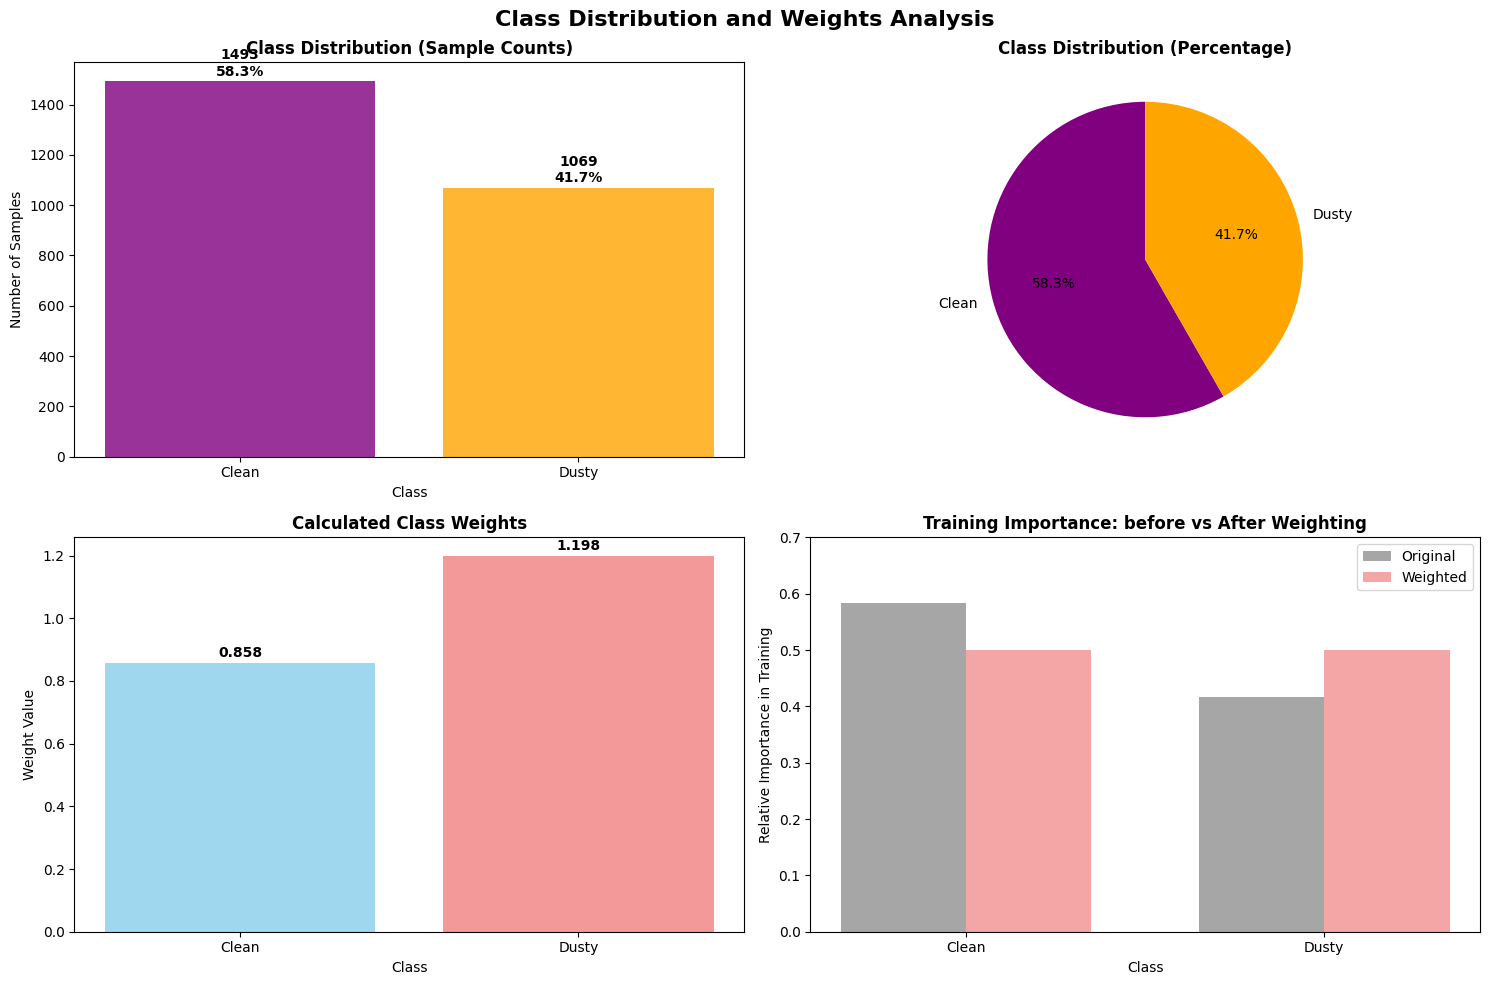

Analyzing Class Imbalance Impact...

Class Imbalance Analysis:
 - Majority Class: Clean (1493 samples)
 - Minority Class: Dusty (1069 samples)
 - Class Imbalance Ratio: 1.40:1

Class Imbalance Severity: MILD
 - Recommendation: Class weights recommended but not critical

Without Class Weights:
 - Model bias: Will favor clean panel prediction
 - Risk: High false negative rate for dusty panels

With Class Weights:
 - Training balance: Each class gets equal importance
 - Benefit: Improved detection of minority class
 - Weight adjustment: 1.20x boost for minority class

Class Weight Analysis is Successfully Completed.


In [15]:
def comprehensive_class_weight_analysis(clean_files=None, dusty_files=None):
    print("Comprehensive Class Weight Analysis...")

    # Input validation
    if not clean_dir or not dusty_dir:
        print("ERROR: Both clean_dir and dusty_dir must be provided.")
        return None, None

    if not os.path.exists(clean_dir):
        print(f"ERROR: Clean directory does not exist: {clean_dir}")
        return None, None

    if not os.path.exists(dusty_dir):
        print(f"ERROR: Dusty directory does not exist: {dusty_dir}")
        return None, None

    try:
        # Step 1: Calculate class weights
        class_weight_dict, y_labels = calculate_class_weight(clean_dir, dusty_dir)

        # Step 2: Create visualizations
        visualize_class_distribution_and_weights(class_weight_dict, y_labels)

        # Step 3: Analyze imbalance impact
        analyze_class_imbalance_impact(class_weight_dict, y_labels)

        print("\nClass Weight Analysis is Successfully Completed.")

        return class_weight_dict, y_labels

    except Exception as e:
        print(f"ERROR during analysis: {str(e)}")
        print("Please check your directory paths and ensure they contain image files.")
        return None, None

calculated_class_weights_dict, y_labels_for_analysis = comprehensive_class_weight_analysis(clean_dir, dusty_dir)


Quick file count check:
Train - Clean: 1194, Dusty: 855
Test - Clean: 299, Dusty: 214


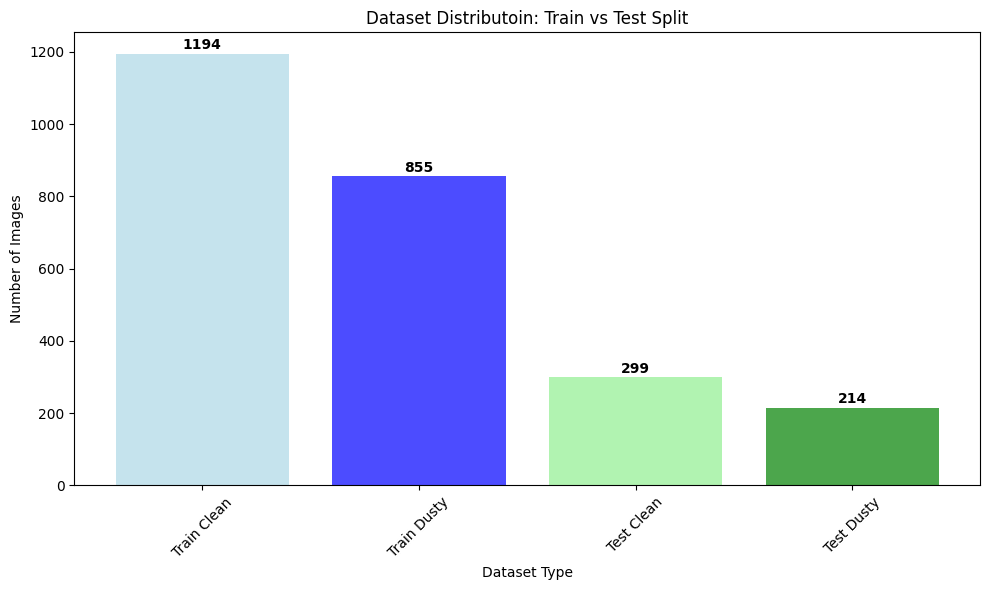

In [16]:
# Count your actual files
print("Quick file count check:")
train_clean = len(os.listdir('/content/train/Clean'))
train_dusty = len(os.listdir('/content/train/Dusty'))
test_clean = len(os.listdir('/content/test/Clean'))
test_dusty = len(os.listdir('/content/test/Dusty'))

print(f"Train - Clean: {train_clean}, Dusty: {train_dusty}")
print(f"Test - Clean: {test_clean}, Dusty: {test_dusty}")

categories = ['Train Clean', 'Train Dusty', 'Test Clean', 'Test Dusty']
counts = [train_clean, train_dusty, test_clean, test_dusty]
colors = ['lightblue', 'blue', 'lightgreen', 'green']

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=colors, alpha=0.7)

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             str(count), ha='center', va='bottom', fontweight='bold')

plt.title('Dataset Distributoin: Train vs Test Split')
plt.xlabel('Dataset Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Phase 2: Image Processing Techniques

## Canny Edge Detection

In [17]:
# 1. CANNY EDGE DETECTION IMPLEMENTATION

def apply_canny_edge_detection(image, low_threshold=50, high_threshold=150):
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    # Apply Gaussian blur to reduce noise (important for solar panels)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, low_threshold, high_threshold)

    # Calculate edge statistics for business intelligence
    total_pixels = edges.shape[0] * edges.shape[1]
    edge_pixels = np.sum(edges > 0)
    edge_density = edge_pixels / total_pixels

    edge_stats = {
        'total_pixels': total_pixels,
        'edge_pixels': edge_pixels,
        'edge_density': edge_density,
        'edge_percentage': edge_density * 100
    }

    return edges, edge_stats

print("First Technique: Canny Edge Detection function has implemented.")

First Technique: Canny Edge Detection function has implemented.


## Thresholding

In [18]:
# 2. THRESHOLDING IMPLEMENTATION

def apply_thresholding(image, method='otsu'):
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    if method == 'otsu':
        # Otsu's automatic thresholding (best for bimodal distributions)
        threshold_value, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif method == 'adaptive':
        # Adaptive thresholding (good for varying lighting)
        thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 11, 2)
        threshold_value = None  # No single threshold value for adaptive
    else:  # manual
        # Manual thresholding
        threshold_value, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Calculate dust coverage statistics
    total_pixels = thresh.shape[0] * thresh.shape[1]
    dust_pixels = np.sum(thresh == 0)  # Dark areas = dust
    clean_pixels = np.sum(thresh == 255)  # Bright areas = clean
    dust_coverage = dust_pixels / total_pixels

    thresh_stats = {
        'threshold_value': threshold_value,
        'method': method,
        'total_pixels': total_pixels,
        'dust_pixels': dust_pixels,
        'clean_pixels': clean_pixels,
        'dust_coverage': dust_coverage,
        'dust_percentage': dust_coverage * 100
    }

    return thresh, thresh_stats

print("Second Technique: Thresholding function has implemented.")

Second Technique: Thresholding function has implemented.


## Local Binary Pattern (LBP)

In [19]:
# 3. LOCAL BINARY PATTERN IMPLEMENTATION

def apply_lbp(image, radius=3, n_points=None):
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    # Set default n_points if not provided
    if n_points is None:
        n_points = 8 * radius

    # Apply Local Binary Pattern
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')

    # Calculate texture statistics
    lbp_mean = np.mean(lbp)
    lbp_std = np.std(lbp)

    # Calculate entropy for texture complexity
    # Avoid division by zero
    unique_values, counts = np.unique(lbp, return_counts=True)
    probabilities = counts / counts.sum()
    lbp_entropy = -np.sum(probabilities * np.log2(probabilities + 1e-7))

    # Calculate histogram for texture analysis
    hist, _ = np.histogram(lbp.ravel(), bins=n_points + 2, range=(0, n_points + 2))
    hist = hist.astype(float)
    hist /= (hist.sum() + 1e-7)  # Normalize

    lbp_stats = {
        'radius': radius,
        'n_points': n_points,
        'lbp_mean': lbp_mean,
        'lbp_std': lbp_std,
        'lbp_entropy': lbp_entropy,
        'texture_uniformity': np.max(hist),  # Higher = more uniform texture
        'texture_complexity': lbp_entropy  # Higher = more complex texture
    }

    return lbp, lbp_stats

print("Third Technique: Local Binary Pattern function has implemented.")

Third Technique: Local Binary Pattern function has implemented.


## Combined Processing Function

In [20]:
# COMBINED PROCESSING FUNCTION
def enhanced_preprocessing(image, return_stats=True):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)  # Ensure image is in correct format

    print(f"Processing image of shape: {image.shape}")

    # Apply each technique
    edges, edge_stats = apply_canny_edge_detection(image)
    thresh, thresh_stats = apply_thresholding(image)
    lbp, lbp_stats = apply_lbp(image)

    # Normalize processed images to [0, 1] range for model input
    edges_norm = edges / 255.0
    thresh_norm = thresh / 255.0
    lbp_norm = (lbp - lbp.min()) / (lbp.max() - lbp.min() + 1e-7)

    # Create combined feature representation
    # This could be input to your CNN models
    combined_features = np.dstack([
        edges_norm,
        thresh_norm,
        lbp_norm
    ])

    processed_data = {
        'original': image,
        'edges': edges,
        'threshold': thresh,
        'lbp': lbp,
        'edges_norm': edges_norm,
        'thresh_norm': thresh_norm,
        'lbp_norm': lbp_norm,
        'combined_features': combined_features
    }

    if return_stats:
        # Combine all statistics for business intelligence
        comprehensive_stats = {
            'edge_stats': edge_stats,
            'threshold_stats': thresh_stats,
            'lbp_stats': lbp_stats,
            'combined_analysis': {
                'dust_score': (edge_stats['edge_density'] + thresh_stats['dust_coverage']) / 2,
                'texture_complexity': lbp_stats['texture_complexity'],
                'overall_dust_indicator': (
                    edge_stats['edge_density'] * 0.3 +
                    thresh_stats['dust_coverage'] * 0.5 +
                    (lbp_stats['texture_complexity'] / 10) * 0.2  # Normalize LBP
                )
            }
        }
        return processed_data, comprehensive_stats

    return processed_data

print("Combined preprocessing function has implemented.")
print("\nAll core image processing functions are ready!")

Combined preprocessing function has implemented.

All core image processing functions are ready!


## Test Run

In [21]:
# QUICK TEST: Process a single image
print("Testing image processing functions with a single image...")

# Load a test image
clean_files = [f for f in os.listdir(clean_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
test_image_path = os.path.join(clean_dir, clean_files[0])
test_image = plt.imread(test_image_path)

print(f"Loading test image: {clean_files[0]}")
print(f"  Original shape: {test_image.shape}")

# Resize for testing (optional)
test_image_resized = cv2.resize(test_image, (512, 512))
print(f"  Resized shape: {test_image_resized.shape}")

# Apply enhanced preprocessing
print("\nApplying enhanced preprocessing...")
try:
    processed_data, stats = enhanced_preprocessing(test_image_resized)
    print("\nProcessing successful!")

    # Display quick results
    print(f"\nQuick Results:")
    print(f" > Edge Density: {stats['edge_stats']['edge_percentage']:.2f}%")
    print(f" > Dust Coverage: {stats['threshold_stats']['dust_percentage']:.2f}%")
    print(f" > Texture Complexity: {stats['lbp_stats']['texture_complexity']:.3f}")
    print(f" > Overall Dust Score: {stats['combined_analysis']['overall_dust_indicator']:.3f}")

except Exception as e:
    print(f"\nError during processing: {e}")
    print("Let's debug this...")

Testing image processing functions with a single image...
Loading test image: Imgclean_48_0.jpg
  Original shape: (225, 400, 3)
  Resized shape: (512, 512, 3)

Applying enhanced preprocessing...
Processing image of shape: (512, 512, 3)

Processing successful!

Quick Results:
 > Edge Density: 12.41%
 > Dust Coverage: 36.77%
 > Texture Complexity: 3.584
 > Overall Dust Score: 0.293


## Visualization with 3 techniques combined

In [22]:
# Comprehensive Demonstration Function
def demonstrate_image_processing_techniques(clean_dir, dusty_dir, num_samples=2):
    print("=== COMPREHENSIVE IMAGE PROCESSING DEMONSTRATION ===")
    print("Showing three techniques work on solar panel images...")
    print("------------------------------------------------------")

    # Get image files
    clean_files = [f for f in os.listdir(clean_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    dusty_files = [f for f in os.listdir(dusty_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Process clean panels first
    print("\nTesting clean panels:")
    for i in range(min(num_samples, len(clean_files))):
        print(f"\nProcessing Clean Panel {i+1}: {clean_files[i]}")

        img_path = os.path.join(clean_dir, clean_files[i])
        image = plt.imread(img_path)
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)
        image_resized = cv2.resize(image, (512, 512))

        try:
            processed_data, stats = enhanced_preprocessing(image_resized)

            print("\nResults:")
            print(f" > Edge Density: {stats['edge_stats']['edge_percentage']:.1f}%")
            print(f" > Dust Areas: {stats['threshold_stats']['dust_percentage']:.1f}%")
            print(f" > Texture Score: {stats['lbp_stats']['texture_complexity']:.3f}")
            print(f" > Overall Dust Score: {stats['combined_analysis']['overall_dust_indicator']:.3f}")


            dust_score = stats['combined_analysis']['overall_dust_indicator']
            if dust_score > 0.5:
                assessment = "HIGH DUST - clean needed!"
            elif dust_score > 0.2:
                assessment = "MEDIUM DUST - Monitor closely!"
            else:
                assessment = "LOW DUST - Good condition."

            print(f"\n- Assessment: {assessment} -")

            # Original image
            fig, axes = plt.subplots(2, 2, figsize=(10, 8))
            fig.suptitle(f'Clean Panel {i+1} - Dust Score: {dust_score:.3f}',
                        fontsize=14, fontweight='bold')

            axes[0, 0].imshow(processed_data['original'])
            axes[0, 0].set_title('Original Image', fontweight='bold')
            axes[0, 0].axis('off')

            # Canny edge detection
            axes[0, 1].imshow(processed_data['edges'], cmap='gray')
            axes[0, 1].set_title(f'Canny Edge Detection\nEdge Density: {stats["edge_stats"]["edge_percentage"]:.2f}%',
                                fontweight='bold')
            axes[0, 1].axis('off')

            # Thresholding
            axes[1, 0].imshow(processed_data['threshold'], cmap='gray')
            axes[1, 0].set_title(f'Thresholding\nDust Coverage: {stats["threshold_stats"]["dust_percentage"]:.2f}%',
                                fontweight='bold')
            axes[1, 0].axis('off')

            # LBP
            axes[1, 1].imshow(processed_data['lbp'], cmap='gray')
            axes[1, 1].set_title(f'Local Binary Pattern\nTexture Score: {stats["lbp_stats"]["texture_complexity"]:.3f}',
                                fontweight='bold')
            axes[1, 1].axis('off')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"\nError during processing {clean_files[i]}: {e}")

    # Process dusty panels
    print("\nTesting dusty panels:")
    for i in range(min(num_samples, len(dusty_files))):
        print(f"\nProcessing Dusty Panel {i+1}: {dusty_files[i]}")

        img_path = os.path.join(dusty_dir, dusty_files[i])
        image = plt.imread(img_path)
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)
        image_resized = cv2.resize(image, (512, 512))

        try:
            processed_data, stats = enhanced_preprocessing(image_resized)

            print("\nResults:")
            print(f" > Edge Density: {stats['edge_stats']['edge_percentage']:.1f}%")
            print(f" > Dust Areas: {stats['threshold_stats']['dust_percentage']:.1f}%")
            print(f" > Texture Score: {stats['lbp_stats']['texture_complexity']:.3f}")
            print(f" > Overall Dust Score: {stats['combined_analysis']['overall_dust_indicator']:.3f}")


            dust_score = stats['combined_analysis']['overall_dust_indicator']
            if dust_score > 0.5:
                assessment = "HIGH DUST - clean needed!"
            elif dust_score > 0.2:
                assessment = "MEDIUM DUST - Monitor closely!"
            else:
                assessment = "LOW DUST - Good condition."

            print(f"\n- Assessment: {assessment} -")

            # Original image
            fig, axes = plt.subplots(2, 2, figsize=(10, 8))
            fig.suptitle(f'Dusty Panel {i+1} - Dust Score: {dust_score:.3f}',
                        fontsize=14, fontweight='bold')

            axes[0, 0].imshow(processed_data['original'])
            axes[0, 0].set_title('Original Image', fontweight='bold')
            axes[0, 0].axis('off')

            # Canny edge detection
            axes[0, 1].imshow(processed_data['edges'], cmap='gray')
            axes[0, 1].set_title(f'Canny Edge Detection\nEdge Density: {stats["edge_stats"]["edge_percentage"]:.2f}%',
                                fontweight='bold')
            axes[0, 1].axis('off')

            # Thresholding
            axes[1, 0].imshow(processed_data['threshold'], cmap='gray')
            axes[1, 0].set_title(f'Thresholding\nDust Coverage: {stats["threshold_stats"]["dust_percentage"]:.2f}%',
                                fontweight='bold')
            axes[1, 0].axis('off')

            # LBP
            axes[1, 1].imshow(processed_data['lbp'], cmap='gray')
            axes[1, 1].set_title(f'Local Binary Pattern\nTexture Score: {stats["lbp_stats"]["texture_complexity"]:.3f}',
                                fontweight='bold')
            axes[1, 1].axis('off')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"\nError during processing {dusty_files[i]}: {e}")


EXECUTING COMPREHENSIVE DEMONSTRATION

=== COMPREHENSIVE IMAGE PROCESSING DEMONSTRATION ===
Showing three techniques work on solar panel images...
------------------------------------------------------

Testing clean panels:

Processing Clean Panel 1: Imgclean_48_0.jpg
Processing image of shape: (512, 512, 3)

Results:
 > Edge Density: 12.4%
 > Dust Areas: 36.8%
 > Texture Score: 3.584
 > Overall Dust Score: 0.293

- Assessment: MEDIUM DUST - Monitor closely! -


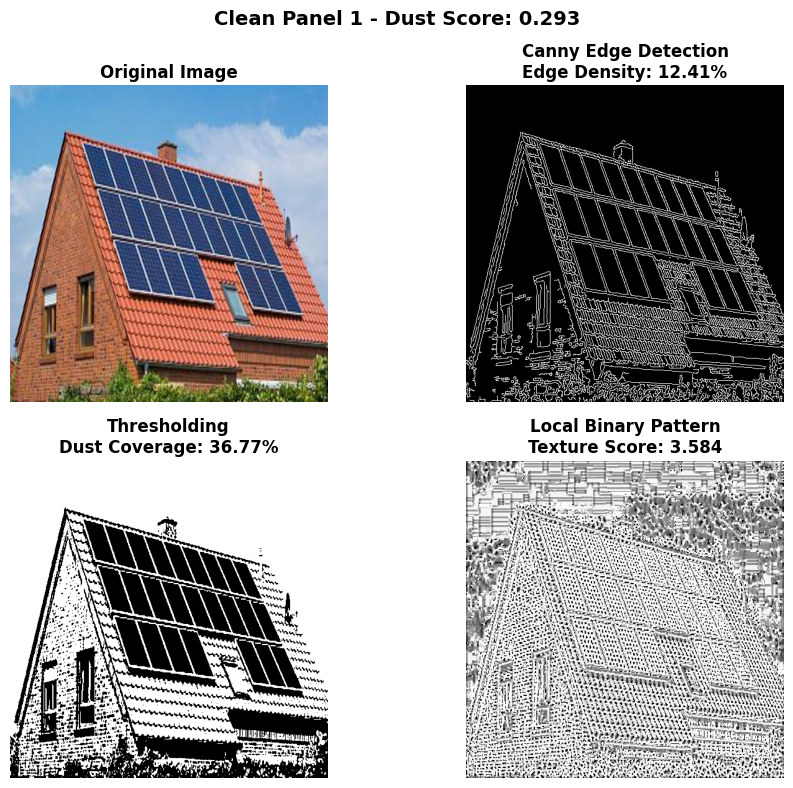


Processing Clean Panel 2: Imgclean_501_0.jpg
Processing image of shape: (512, 512, 4)

Results:
 > Edge Density: 8.6%
 > Dust Areas: 55.3%
 > Texture Score: 3.666
 > Overall Dust Score: 0.375

- Assessment: MEDIUM DUST - Monitor closely! -


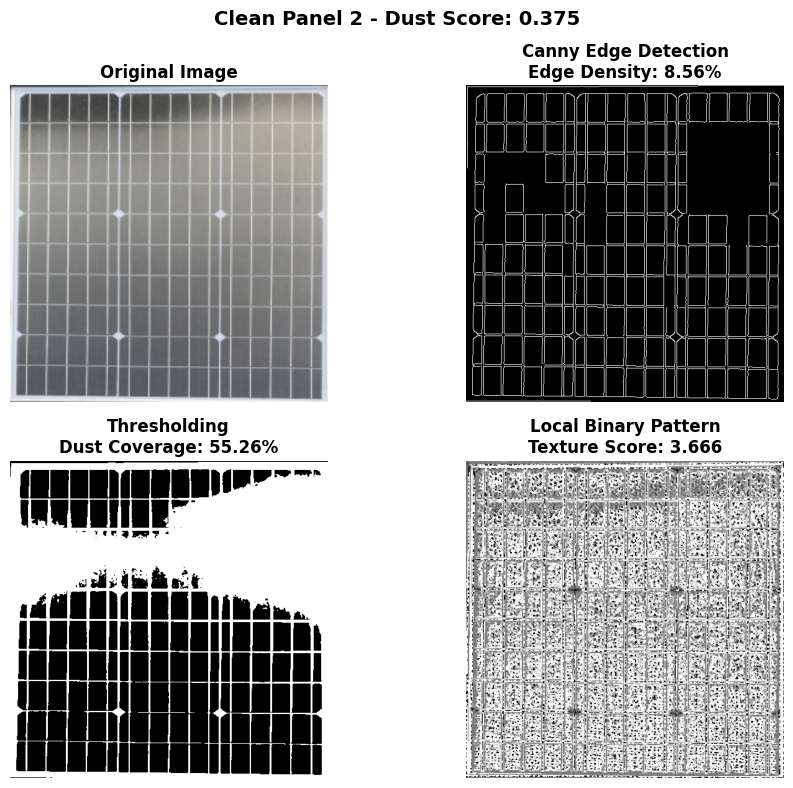


Testing dusty panels:

Processing Dusty Panel 1: Imgdirty_612_1.jpg
Processing image of shape: (512, 512, 3)

Results:
 > Edge Density: 8.1%
 > Dust Areas: 45.8%
 > Texture Score: 2.803
 > Overall Dust Score: 0.309

- Assessment: MEDIUM DUST - Monitor closely! -


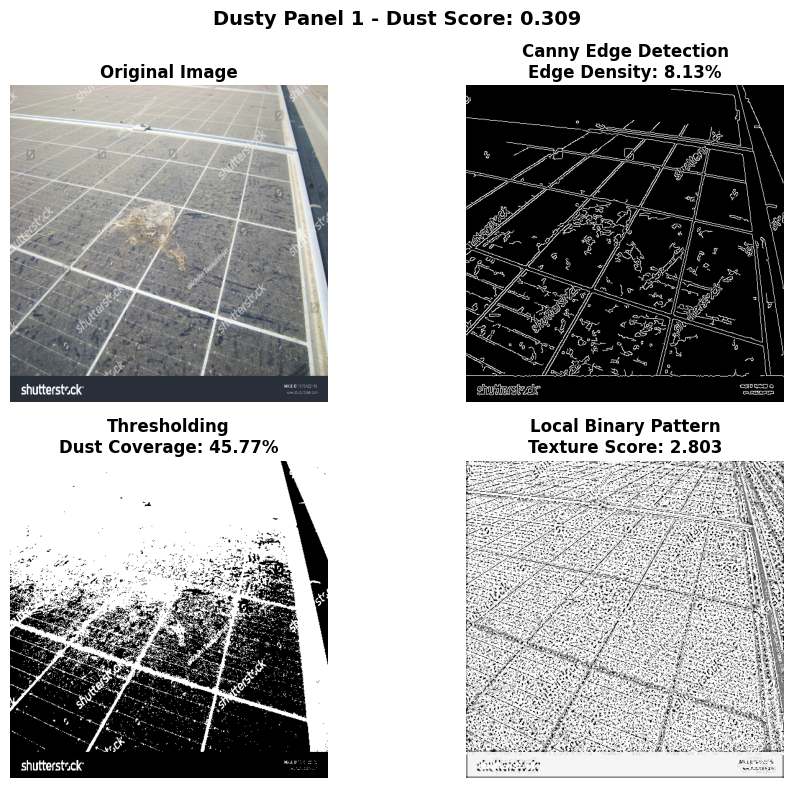


Processing Dusty Panel 2: Imgdirty_762_1.jpg
Processing image of shape: (512, 512, 3)

Results:
 > Edge Density: 16.9%
 > Dust Areas: 61.8%
 > Texture Score: 2.741
 > Overall Dust Score: 0.414

- Assessment: MEDIUM DUST - Monitor closely! -


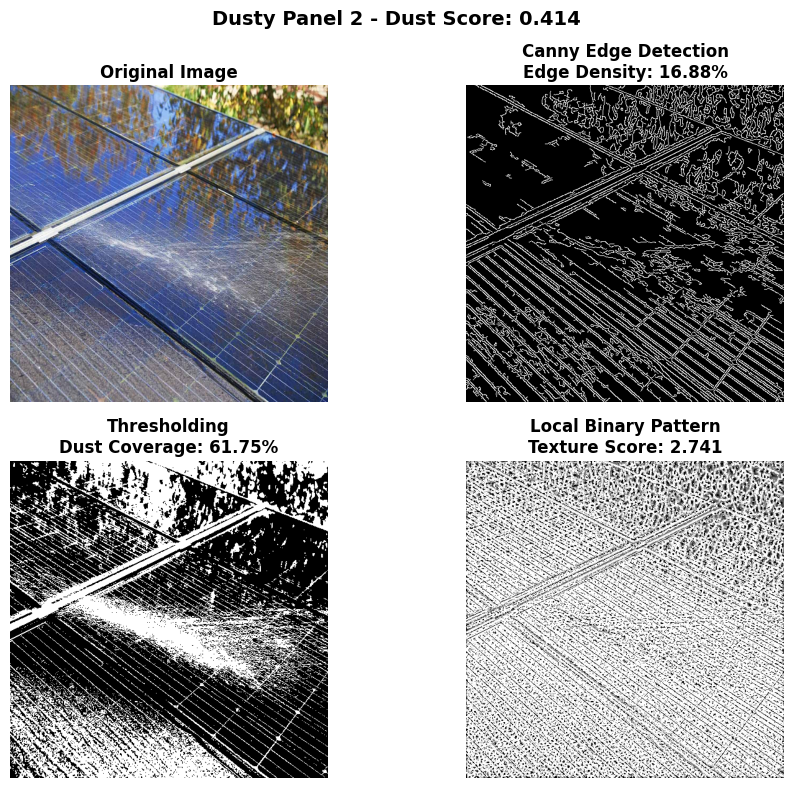


DEMONSTRATION COMPLETED SUCCESSFULLY!

Detailed visualizations above showing:
Original images
Canny edge detection results
Thresholding results
Local Binary Pattern results
Combined feature analysis
Statistical summaries


In [23]:
# Execute the comprehensive demonstration
print("EXECUTING COMPREHENSIVE DEMONSTRATION\n")

# Run the demonstration
try:
    stats_results = demonstrate_image_processing_techniques(clean_dir, dusty_dir, 2)
    print("\nDEMONSTRATION COMPLETED SUCCESSFULLY!")
    print("\nDetailed visualizations above showing:")
    print("Original images")
    print("Canny edge detection results")
    print("Thresholding results")
    print("Local Binary Pattern results")
    print("Combined feature analysis")
    print("Statistical summaries")

except Exception as e:
    print(f"Error during demonstration: {e}")
    print("Let's troubleshoot...")

# Phase 3: CNN Model Development

## 1st Model: EfficientNetB3

### Pre-trained EfficientNetB3

In [24]:
print("=== CNN MODEL DEVELOPMENT ===")
print("\nBuilding EfficientNetB3 Pre-train Model...")

pre_effi_model = Sequential([
    EfficientNetB3(weights='imagenet',
                   include_top = False,
                   input_shape = (256, 256, 3)),
    GlobalAveragePooling2D(),
    Dense(128, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

# Freeze the pre-trained model initially
pre_effi_model.layers[0].trainable = False

pre_effi_model.compile(optimizer = Adam(learning_rate = 0.0001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

print("EfficientNetB3 model has been built.\n")
pre_effi_model.summary()

=== CNN MODEL DEVELOPMENT ===

Building EfficientNetB3 Pre-train Model...
EfficientNetB3 model has been built.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 8, 8, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,980,400 (41.89 MB)

 Trainable params: 196,865 (769.00 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [25]:
history_pre_effi = pre_effi_model.fit(
    train_generator,
    validation_data = test_generator,
    epochs = 10,
    class_weight = calculated_class_weights_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.5097 - loss: 0.6945 - val_accuracy: 0.4191 - val_loss: 0.6956
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4776 - loss: 0.6950 - val_accuracy: 0.4172 - val_loss: 0.7060
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.5001 - loss: 0.6910 - val_accuracy: 0.4815 - val_loss: 0.6930
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4733 - loss: 0.6957 - val_accuracy: 0.4873 - val_loss: 0.6930
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.4761 - loss: 0.6964 - val_accuracy: 0.4172 - val_loss: 0.7357
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.4900 - loss: 0.7016 - val_accuracy: 0.5828 - val_loss: 0.6850
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4956 - loss: 0.6979 - val_accuracy: 0.5848 - val_loss: 0.6879
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.4718 - loss: 0.7023 - val_accuracy: 0.4172 - val_loss

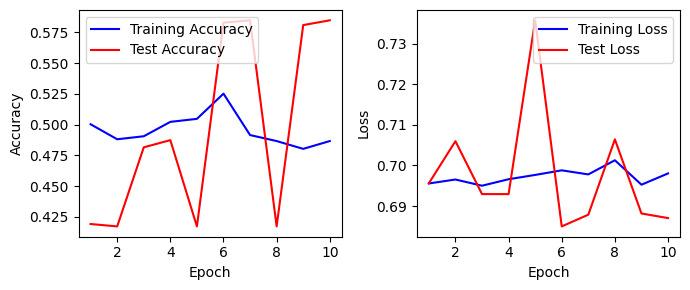

In [26]:
# Plotting EfficientNetB3 pre-trained model
accuracy = history_pre_effi.history['accuracy']
val_accuracy = history_pre_effi.history['val_accuracy']
loss = history_pre_effi.history['loss']
val_loss = history_pre_effi.history['val_loss']

epochs = range(1, len(accuracy) + 1)
# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
axes[0].plot(epochs, accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs, val_accuracy, 'r', label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label='Training Loss')
axes[1].plot(epochs, val_loss, 'r', label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [27]:
# Pre-trained Model Evaluation
test_loss, test_acc = pre_effi_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 668ms/step - accuracy: 0.6035 - loss: 0.6854
Test Accuracy: 58.48%
Test Loss: 0.6871


In [28]:
#Classification Report - Pre-trained
test_generator.reset()
predictions = pre_effi_model.predict(test_generator)
print("PREDICTION DEBUGGING:")
print(f"Prediction range: {predictions.min():.3f} to {predictions.max():.3f}")
print(f"Predictions > 0.5: {np.sum(predictions > 0.5)}")
print(f"Predictions <= 0.5: {np.sum(predictions <= 0.5)}")
print(f"First 10 predictions: {predictions.flatten()[:10]}")

y_pred_pre = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

precision = precision_score(y_true, y_pred_pre)
recall = recall_score(y_true, y_pred_pre)
f1 = f1_score(y_true, y_pred_pre)

print('Classification Report (Pre-trained):')
print(classification_report(y_true, y_pred_pre, target_names=['Clean', 'Dusty']))

17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step
PREDICTION DEBUGGING:
Prediction range: 0.471 to 0.520
Predictions > 0.5: 1
Predictions <= 0.5: 512
First 10 predictions: [0.48076573 0.4797741  0.49395916 0.47893927 0.4771094  0.4815328
 0.47961953 0.47867385 0.4799993  0.47880468]
Classification Report (Pre-trained):
              precision    recall  f1-score   support

       Clean       0.58      1.00      0.74       299
       Dusty       1.00      0.00      0.01       214

    accuracy                           0.58       513
   macro avg       0.79      0.50      0.37       513
weighted avg       0.76      0.58      0.43       513



17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 662ms/step


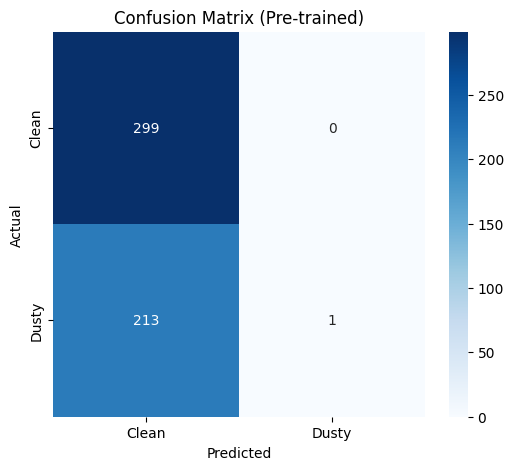

In [29]:
# Final confusion matrix on the pre-trained model
test_generator.reset()
final_predictions = pre_effi_model.predict(test_generator)

y_pred_final = (final_predictions > 0.5).astype(int).flatten()
y_true_final = test_generator.classes

cm_pre = confusion_matrix(y_true, y_pred_pre)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_pre, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clean', 'Dusty'],
            yticklabels=['Clean', 'Dusty'])
plt.title('Confusion Matrix (Pre-trained)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Hyperparameter Tuning for EfficientNetB3

#### 1st tuned (dropout = 0.3)

In [30]:
print("=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===")

# STEP 1: Get all images and labels from train_generator
print("\nGetting all generator data for EfficientNetB3...")
train_generator.reset()
all_images = []
all_labels = []

for i in range(len(train_generator)):
    batch_x, batch_y = train_generator[i]
    all_images.append(batch_x)
    all_labels.extend(batch_y)

# Convert to numpy arrays
X_all = np.vstack(all_images)
y_all = np.array(all_labels)

print(f"Total training data: {X_all.shape}")
print(f"Clean samples: {np.sum(y_all == 0)}")
print(f"Dusty samples: {np.sum(y_all == 1)}")

# STEP 2: Setup 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\n5-fold cross-validation setup complete for EfficientNetB3")

# STEP 3: Store results for each fold
efficientnet_fold_results = []

# STEP 4: Loop through each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all)):
    print(f"\nTRAINING EFFICIENTNETB3 FOLD {fold + 1}/5")

    # Split data for this fold
    X_train_fold = X_all[train_idx]
    y_train_fold = y_all[train_idx]
    X_val_fold = X_all[val_idx]
    y_val_fold = y_all[val_idx]

    print(f"\nTrain samples: {len(X_train_fold)}")
    print(f"Validation samples: {len(X_val_fold)}")

    # BUILD MODEL
    print(f"\nBuilding EfficientNetB3 Model for Fold {fold + 1}...")
    tuned_effi_model = Sequential([
        EfficientNetB3(weights='imagenet',
                      include_top=False,
                      input_shape=(256, 256, 3)),
        GlobalAveragePooling2D(),
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dropout(0.3),
        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.3),
        Dense(1, activation='sigmoid',
              kernel_regularizer=regularizers.l2(0.01))
    ])

    # Setup Callbacks
    early_stopping = EarlyStopping(monitor='val_loss',
                                 patience=10,
                                 restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=5,
                                min_lr=0.0001)

    # Freeze the model initially
    tuned_effi_model.layers[0].trainable = False

    tuned_effi_model.compile(optimizer=Adam(learning_rate=0.0001),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

    print(f"\nEfficientNetB3 model built for fold {fold + 1}\n")
    tuned_effi_model.summary()

=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===

Getting all generator data for EfficientNetB3...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Total training data: (2049, 256, 256, 3)
Clean samples: 1194
Dusty samples: 855

5-fold cross-validation setup complete for EfficientNetB3

TRAINING EFFICIENTNETB3 FOLD 1/5

Train samples: 1639
Validation samples: 410

Building EfficientNetB3 Model for Fold 1...

EfficientNetB3 model built for fold 1



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 8, 8, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,986,544 (41.91 MB)

 Trainable params: 199,937 (781.00 KB)

 Non-trainable params: 10,786,607 (41.15 MB)


TRAINING EFFICIENTNETB3 FOLD 2/5

Train samples: 1639
Validation samples: 410

Building EfficientNetB3 Model for Fold 2...

EfficientNetB3 model built for fold 2



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 8, 8, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,986,544 (41.91 MB)

 Trainable params: 199,937 (781.00 KB)

 Non-trainable params: 10,786,607 (41.15 MB)


TRAINING EFFICIENTNETB3 FOLD 3/5

Train samples: 1639
Validation samples: 410

Building EfficientNetB3 Model for Fold 3...

EfficientNetB3 model built for fold 3



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 8, 8, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,986,544 (41.91 MB)

 Trainable params: 199,937 (781.00 KB)

 Non-trainable params: 10,786,607 (41.15 MB)


TRAINING EFFICIENTNETB3 FOLD 4/5

Train samples: 1639
Validation samples: 410

Building EfficientNetB3 Model for Fold 4...

EfficientNetB3 model built for fold 4



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 8, 8, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,986,544 (41.91 MB)

 Trainable params: 199,937 (781.00 KB)

 Non-trainable params: 10,786,607 (41.15 MB)


TRAINING EFFICIENTNETB3 FOLD 5/5

Train samples: 1640
Validation samples: 409

Building EfficientNetB3 Model for Fold 5...

EfficientNetB3 model built for fold 5



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 8, 8, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,986,544 (41.91 MB)

 Trainable params: 199,937 (781.00 KB)

 Non-trainable params: 10,786,607 (41.15 MB)

In [31]:
# TRAIN MODEL
print(f"Training Fold {fold + 1}...")

history_fold_effi = tuned_effi_model.fit(
    X_train_fold, y_train_fold,
    validation_data=(X_val_fold, y_val_fold),
    epochs=80,
    batch_size=32,
    class_weight = calculated_class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)


Training Fold 5...
Epoch 1/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.4918 - loss: 3.1669 - val_accuracy: 0.4181 - val_loss: 2.9653 - learning_rate: 1.0000e-04
Epoch 2/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5227 - loss: 3.0010 - val_accuracy: 0.4181 - val_loss: 2.8456 - learning_rate: 1.0000e-04
Epoch 3/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4889 - loss: 2.9118 - val_accuracy: 0.4181 - val_loss: 2.7297 - learning_rate: 1.0000e-04
Epoch 4/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5086 - loss: 2.7840 - val_accuracy: 0.4597 - val_loss: 2.6295 - learning_rate: 1.0000e-04
Epoch 5/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4880 - loss: 2.6710 - val_accuracy: 0.4425 - val_loss: 2.5421 - learning_rate: 1.0000e-04
Epoch 6/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5223 - loss: 2.5717 - val_accuracy: 0.4499 - val_loss: 2.4586 - learning_rate: 1.0000e-04
Epoch 7/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step -


Plotting training history for Fold 5...


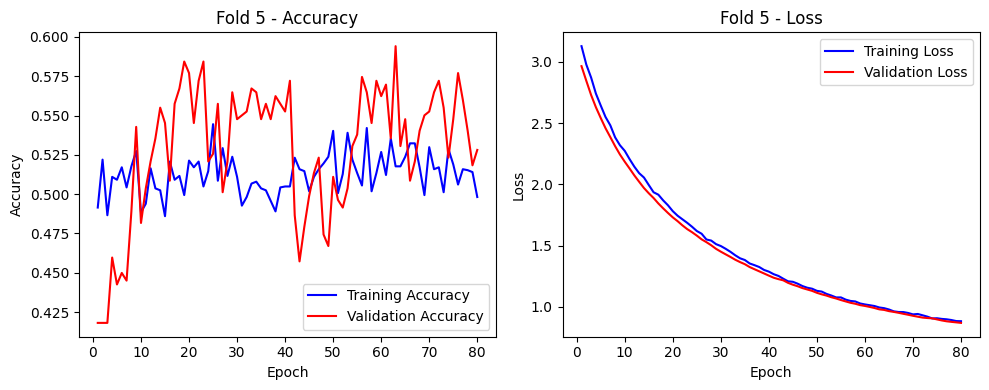

In [32]:
# Plotting EfficientNetB3 tuned model
print(f"\nPlotting training history for Fold {fold + 1}...")
accuracy = history_fold_effi.history['accuracy']
val_accuracy = history_fold_effi.history['val_accuracy']
loss = history_fold_effi.history['loss']
val_loss = history_fold_effi.history['val_loss']

epochs_trained = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(epochs_trained, accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs_trained, val_accuracy, 'r', label='Validation Accuracy')
axes[0].set_title(f'Fold {fold+1} - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs_trained, loss, 'b', label='Training Loss')
axes[1].plot(epochs_trained, val_loss, 'r', label='Validation Loss')
axes[1].set_title(f'Fold {fold+1} - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [33]:
# Tuned Model Evaluation
test_loss, test_acc = tuned_effi_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 932ms/step - accuracy: 0.5260 - loss: 0.8646
Test Accuracy: 51.66%
Test Loss: 0.8637


In [34]:
#Classification Report - Tuned
test_generator.reset()
predictions = tuned_effi_model.predict(test_generator, verbose=0)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nFold {fold + 1} Results:")
print(f"  Test Accuracy: {test_acc * 100:.2f}%")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

# Store results - MOVED INSIDE THE LOOP
efficientnet_fold_results.append({
    'fold': fold + 1,
    'accuracy': test_acc,
    'loss': test_loss,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'history': history_fold_effi
})

print('Classification Report (Tuned):')
print(classification_report(y_true, y_pred_pre, target_names=['Clean', 'Dusty']))


Fold 5 Results:
  Test Accuracy: 51.66%
  Test Loss: 0.8637
  Precision: 0.4281
  Recall: 0.6121
  F1-Score: 0.5038
Classification Report (Tuned):
              precision    recall  f1-score   support

       Clean       0.58      1.00      0.74       299
       Dusty       1.00      0.00      0.01       214

    accuracy                           0.58       513
   macro avg       0.79      0.50      0.37       513
weighted avg       0.76      0.58      0.43       513



In [35]:
# STEP 5: Calculate final results
print("EFFICIENTNETB3 5-FOLD CROSS-VALIDATION RESULTS")

# Extract all metrics
accuracies = [result['accuracy'] for result in efficientnet_fold_results]
precisions = [result['precision'] for result in efficientnet_fold_results]
recalls = [result['recall'] for result in efficientnet_fold_results]
f1_scores = [result['f1_score'] for result in efficientnet_fold_results]

# Calculate means and standard deviations
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
mean_precision = np.mean(precisions)
std_precision = np.std(precisions)
mean_recall = np.mean(recalls)
std_recall = np.std(recalls)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

# Print results
print(f"\nMean Test Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")
print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")

print(f"\nDetailed Results by Fold:")
for i, result in enumerate(efficientnet_fold_results):
    print(f"Fold {i+1}: Acc={result['accuracy']*100:.1f}%, "
          f"Prec={result['precision']:.3f}, "
          f"Rec={result['recall']:.3f}, "
          f"F1={result['f1_score']:.3f}")


EFFICIENTNETB3 5-FOLD CROSS-VALIDATION RESULTS

Mean Test Accuracy: 51.66% ± 0.00%
Mean Precision: 0.4281 ± 0.0000
Mean Recall: 0.6121 ± 0.0000
Mean F1-Score: 0.5038 ± 0.0000

Detailed Results by Fold:
Fold 1: Acc=51.7%, Prec=0.428, Rec=0.612, F1=0.504



Plotting EfficientNetB3 Cross-Validation Results...


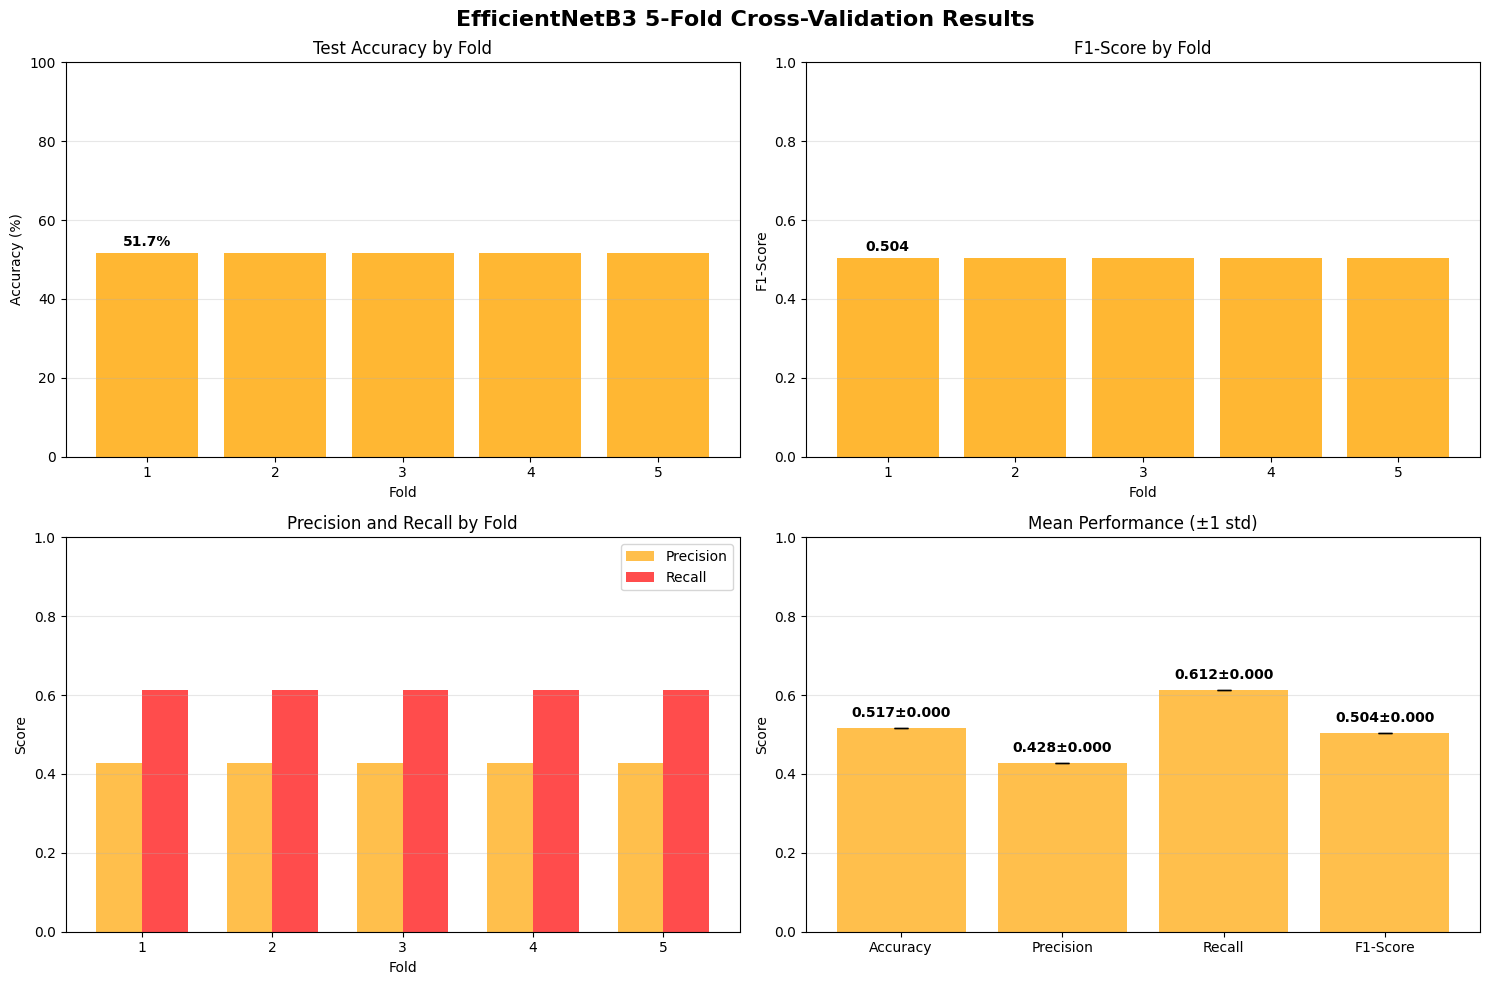

EfficientNetB3 5-fold cross-validation completed successfully!


In [36]:
# STEP 6: Create comprehensive plots
print(f"\nPlotting EfficientNetB3 Cross-Validation Results...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('EfficientNetB3 5-Fold Cross-Validation Results', fontsize=16, fontweight='bold')

fold_numbers = list(range(1, 6))

# Plot 1: Accuracy by fold
bars1 = axes[0, 0].bar(fold_numbers, [acc * 100 for acc in accuracies], color='orange', alpha=0.8)
axes[0, 0].set_title('Test Accuracy by Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_ylim(0, 100)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{acc*100:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: F1-Score by fold
bars2 = axes[0, 1].bar(fold_numbers, f1_scores, color='orange', alpha=0.8)
axes[0, 1].set_title('F1-Score by Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, f1) in enumerate(zip(bars2, f1_scores)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Precision and Recall by fold
x = np.arange(len(fold_numbers))
width = 0.35

bars3 = axes[1, 0].bar(x - width/2, precisions, width, label='Precision', color='orange', alpha=0.7)
bars4 = axes[1, 0].bar(x + width/2, recalls, width, label='Recall', color='red', alpha=0.7)
axes[1, 0].set_title('Precision and Recall by Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(fold_numbers)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Summary statistics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
means = [mean_acc, mean_precision, mean_recall, mean_f1]
stds = [std_acc, std_precision, std_recall, std_f1]

bars5 = axes[1, 1].bar(metrics_names, means, yerr=stds, capsize=5, color='orange', alpha=0.7)
axes[1, 1].set_title('Mean Performance (±1 std)')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars5, means, stds)):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                   f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("EfficientNetB3 5-fold cross-validation completed successfully!")


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 660ms/step

Final Classification Report (EfficientNetB3):
              precision    recall  f1-score   support

       Clean       0.58      0.40      0.47       299
       Dusty       0.42      0.59      0.49       214

    accuracy                           0.48       513
   macro avg       0.50      0.50      0.48       513
weighted avg       0.51      0.48      0.48       513



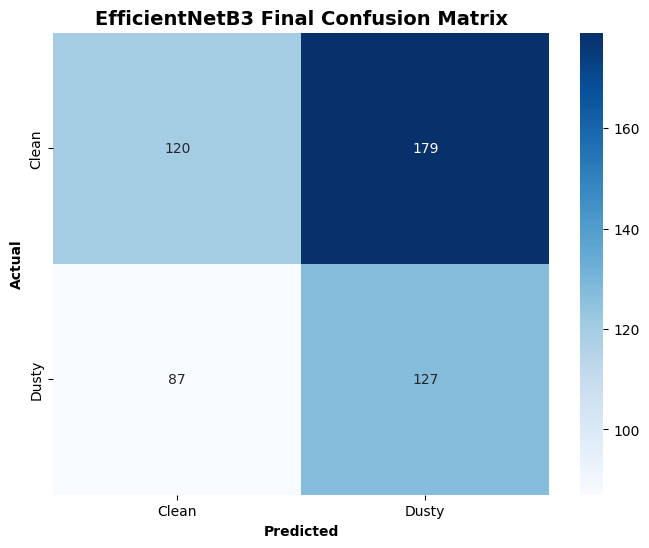

In [37]:
# Final confusion matrix on the last trained model
test_generator.reset()
final_predictions = tuned_effi_model.predict(test_generator)
y_pred_final = (final_predictions > 0.5).astype(int).flatten()
y_true_final = test_generator.classes

print('\nFinal Classification Report (EfficientNetB3):')
print(classification_report(y_true_final, y_pred_final, target_names=['Clean', 'Dusty']))

# Confusion Matrix
cm_effi = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_effi, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clean', 'Dusty'],
            yticklabels=['Clean', 'Dusty'])
plt.title('EfficientNetB3 Final Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.show()

#### 2nd tuned (dropout = 0.2)

In [38]:
print("=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===")

# STEP 1: Get all images and labels from train_generator
print("\nGetting all generator data for EfficientNetB3...")
train_generator.reset()
all_images = []
all_labels = []

for i in range(len(train_generator)):
    batch_x, batch_y = train_generator[i]
    all_images.append(batch_x)
    all_labels.extend(batch_y)

# Convert to numpy arrays
X_all = np.vstack(all_images)
y_all = np.array(all_labels)

print(f"Total training data: {X_all.shape}")
print(f"Clean samples: {np.sum(y_all == 0)}")
print(f"Dusty samples: {np.sum(y_all == 1)}")

# STEP 2: Setup 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\n5-fold cross-validation setup complete for EfficientNetB3")

# STEP 3: Store results for each fold
efficientnet_fold_results = []

# STEP 4: Loop through each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all)):
    print(f"\nTRAINING EFFICIENTNETB3 FOLD {fold + 1}/5")

    # Split data for this fold
    X_train_fold = X_all[train_idx]
    y_train_fold = y_all[train_idx]
    X_val_fold = X_all[val_idx]
    y_val_fold = y_all[val_idx]

    print(f"\nTrain samples: {len(X_train_fold)}")
    print(f"Validation samples: {len(X_val_fold)}")

    # BUILD MODEL
    print(f"\nBuilding EfficientNetB3 Model for Fold {fold + 1}...")
    tuned_effi_model = Sequential([
        EfficientNetB3(weights='imagenet',
                      include_top=False,
                      input_shape=(256, 256, 3)),
        GlobalAveragePooling2D(),
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dropout(0.2),
        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.2),
        Dense(1, activation='sigmoid',
              kernel_regularizer=regularizers.l2(0.01))
    ])

    # Setup Callbacks
    early_stopping = EarlyStopping(monitor='val_loss',
                                 patience=10,
                                 restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=5,
                                min_lr=0.0001)

    # Freeze the model initially
    tuned_effi_model.layers[0].trainable = False

    tuned_effi_model.compile(optimizer=Adam(learning_rate=0.0001),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

    print(f"\nEfficientNetB3 model built for fold {fold + 1}\n")
    tuned_effi_model.summary()

=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===

Getting all generator data for EfficientNetB3...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Total training data: (2049, 256, 256, 3)
Clean samples: 1194
Dusty samples: 855

5-fold cross-validation setup complete for EfficientNetB3

TRAINING EFFICIENTNETB3 FOLD 1/5

Train samples: 1639
Validation samples: 410

Building EfficientNetB3 Model for Fold 1...

EfficientNetB3 model built for fold 1



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 8, 8, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,986,544 (41.91 MB)

 Trainable params: 199,937 (781.00 KB)

 Non-trainable params: 10,786,607 (41.15 MB)


TRAINING EFFICIENTNETB3 FOLD 2/5

Train samples: 1639
Validation samples: 410

Building EfficientNetB3 Model for Fold 2...

EfficientNetB3 model built for fold 2



Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 8, 8, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,986,544 (41.91 MB)

 Trainable params: 199,937 (781.00 KB)

 Non-trainable params: 10,786,607 (41.15 MB)


TRAINING EFFICIENTNETB3 FOLD 3/5

Train samples: 1639
Validation samples: 410

Building EfficientNetB3 Model for Fold 3...

EfficientNetB3 model built for fold 3



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 8, 8, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,986,544 (41.91 MB)

 Trainable params: 199,937 (781.00 KB)

 Non-trainable params: 10,786,607 (41.15 MB)


TRAINING EFFICIENTNETB3 FOLD 4/5

Train samples: 1639
Validation samples: 410

Building EfficientNetB3 Model for Fold 4...

EfficientNetB3 model built for fold 4



Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 8, 8, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,986,544 (41.91 MB)

 Trainable params: 199,937 (781.00 KB)

 Non-trainable params: 10,786,607 (41.15 MB)


TRAINING EFFICIENTNETB3 FOLD 5/5

Train samples: 1640
Validation samples: 409

Building EfficientNetB3 Model for Fold 5...

EfficientNetB3 model built for fold 5



Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 8, 8, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,986,544 (41.91 MB)

 Trainable params: 199,937 (781.00 KB)

 Non-trainable params: 10,786,607 (41.15 MB)

In [39]:
# TRAIN MODEL
print(f"Training Fold {fold + 1}...")

history_fold_effi = tuned_effi_model.fit(
    X_train_fold, y_train_fold,
    validation_data=(X_val_fold, y_val_fold),
    epochs=80,
    batch_size=32,
    class_weight = calculated_class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)


Training Fold 5...
Epoch 1/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 67s 636ms/step - accuracy: 0.4764 - loss: 3.1231 - val_accuracy: 0.4181 - val_loss: 2.9619 - learning_rate: 1.0000e-04
Epoch 2/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4925 - loss: 2.9711 - val_accuracy: 0.5575 - val_loss: 2.8212 - learning_rate: 1.0000e-04
Epoch 3/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5104 - loss: 2.8598 - val_accuracy: 0.5281 - val_loss: 2.7102 - learning_rate: 1.0000e-04
Epoch 4/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5005 - loss: 2.7423 - val_accuracy: 0.5501 - val_loss: 2.6021 - learning_rate: 1.0000e-04
Epoch 5/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4881 - loss: 2.6445 - val_accuracy: 0.5501 - val_loss: 2.5063 - learning_rate: 1.0000e-04
Epoch 6/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5115 - loss: 2.5308 - val_accuracy: 0.5281 - val_loss: 2.4206 - learning_rate: 1.0000e-04
Epoch 7/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/ste

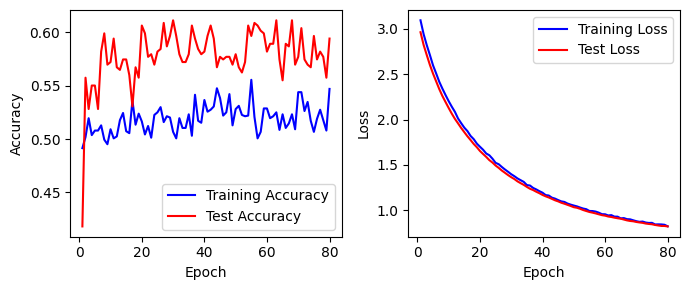

In [40]:
# Plotting EfficientNetB3 tuned model
accuracy = history_fold_effi.history['accuracy']
val_accuracy = history_fold_effi.history['val_accuracy']
loss = history_fold_effi.history['loss']
val_loss = history_fold_effi.history['val_loss']

epochs = range(1, len(accuracy) + 1)
# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
axes[0].plot(epochs, accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs, val_accuracy, 'r', label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label='Training Loss')
axes[1].plot(epochs, val_loss, 'r', label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [41]:
# Tuned Model Evaluation
test_loss, test_acc = tuned_effi_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 940ms/step - accuracy: 0.5629 - loss: 0.8187
Test Accuracy: 56.73%
Test Loss: 0.8184


In [42]:
#Classification Report - Tuned
test_generator.reset()
predictions = tuned_effi_model.predict(test_generator, verbose=0)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nFold {fold + 1} Results:")
print(f"  Test Accuracy: {test_acc * 100:.2f}%")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

# Store results - MOVED INSIDE THE LOOP
efficientnet_fold_results.append({
    'fold': fold + 1,
    'accuracy': test_acc,
    'loss': test_loss,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'history': history_fold_effi
})

print('Classification Report (Tuned):')
print(classification_report(y_true, y_pred_pre, target_names=['Clean', 'Dusty']))


Fold 5 Results:
  Test Accuracy: 56.73%
  Test Loss: 0.8184
  Precision: 0.4262
  Recall: 0.2430
  F1-Score: 0.3095
Classification Report (Tuned):
              precision    recall  f1-score   support

       Clean       0.58      1.00      0.74       299
       Dusty       1.00      0.00      0.01       214

    accuracy                           0.58       513
   macro avg       0.79      0.50      0.37       513
weighted avg       0.76      0.58      0.43       513



In [43]:
# STEP 5: Calculate final results
print("EFFICIENTNETB3 5-FOLD CROSS-VALIDATION RESULTS")

# Extract all metrics
accuracies = [result['accuracy'] for result in efficientnet_fold_results]
precisions = [result['precision'] for result in efficientnet_fold_results]
recalls = [result['recall'] for result in efficientnet_fold_results]
f1_scores = [result['f1_score'] for result in efficientnet_fold_results]

# Calculate means and standard deviations
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
mean_precision = np.mean(precisions)
std_precision = np.std(precisions)
mean_recall = np.mean(recalls)
std_recall = np.std(recalls)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

# Print results
print(f"\nMean Test Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")
print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")

print(f"\nDetailed Results by Fold:")
for i, result in enumerate(efficientnet_fold_results):
    print(f"Fold {i+1}: Acc={result['accuracy']*100:.1f}%, "
          f"Prec={result['precision']:.3f}, "
          f"Rec={result['recall']:.3f}, "
          f"F1={result['f1_score']:.3f}")


EFFICIENTNETB3 5-FOLD CROSS-VALIDATION RESULTS

Mean Test Accuracy: 56.73% ± 0.00%
Mean Precision: 0.4262 ± 0.0000
Mean Recall: 0.2430 ± 0.0000
Mean F1-Score: 0.3095 ± 0.0000

Detailed Results by Fold:
Fold 1: Acc=56.7%, Prec=0.426, Rec=0.243, F1=0.310



Plotting EfficientNetB3 Cross-Validation Results...


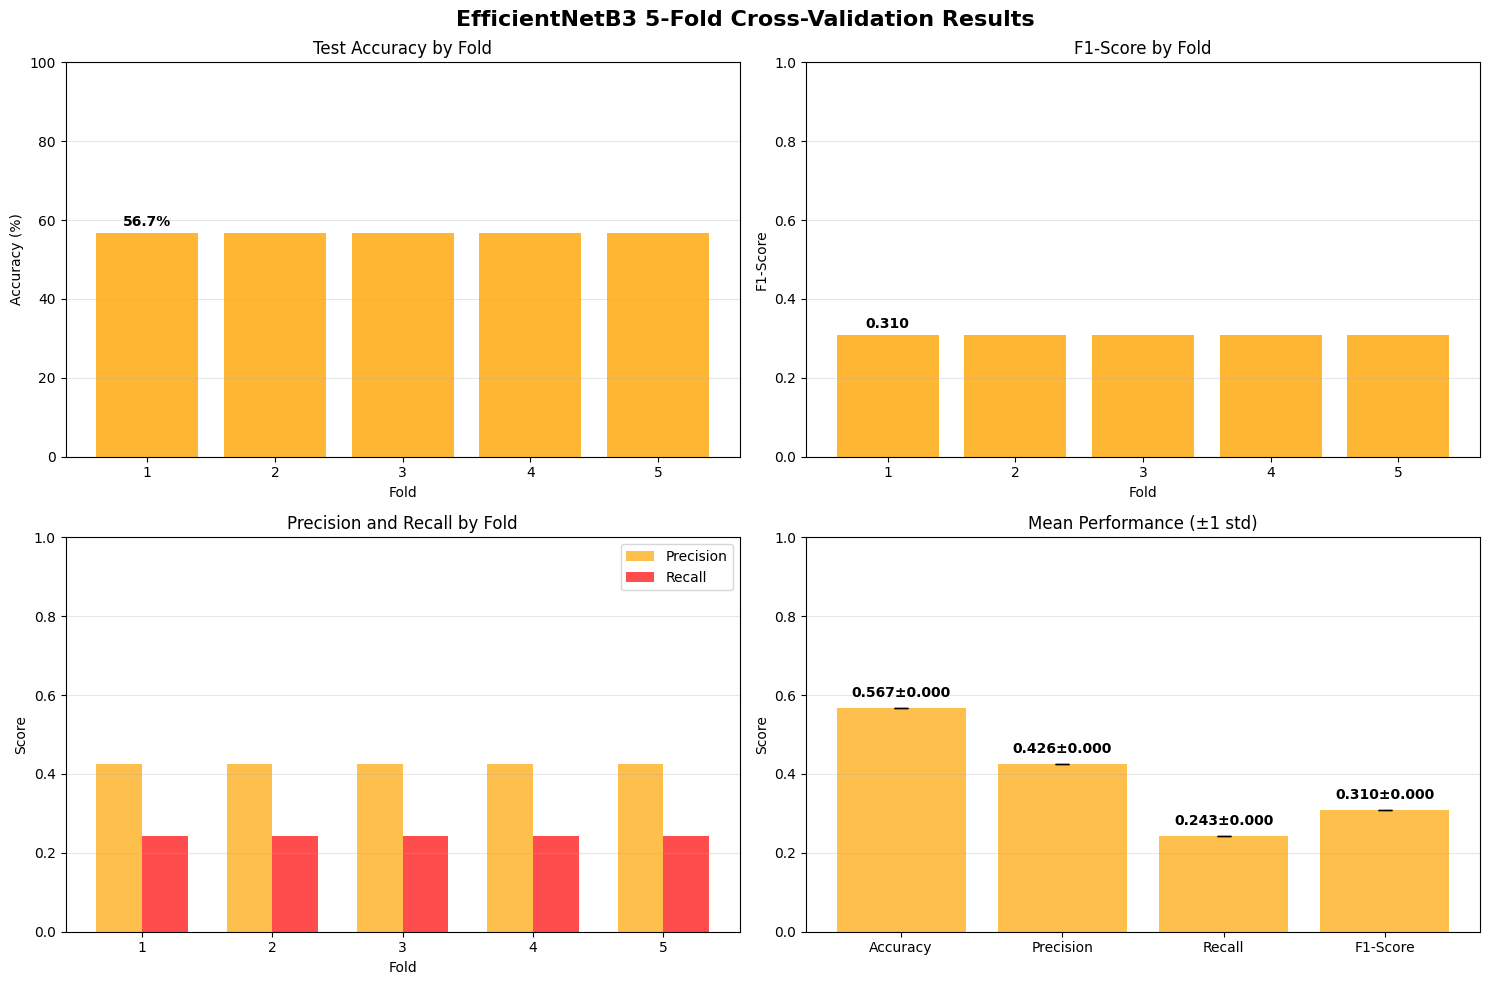

EfficientNetB3 5-fold cross-validation completed successfully!


In [44]:
# STEP 6: Create comprehensive plots
print(f"\nPlotting EfficientNetB3 Cross-Validation Results...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('EfficientNetB3 5-Fold Cross-Validation Results', fontsize=16, fontweight='bold')

fold_numbers = list(range(1, 6))

# Plot 1: Accuracy by fold
bars1 = axes[0, 0].bar(fold_numbers, [acc * 100 for acc in accuracies], color='orange', alpha=0.8)
axes[0, 0].set_title('Test Accuracy by Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_ylim(0, 100)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{acc*100:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: F1-Score by fold
bars2 = axes[0, 1].bar(fold_numbers, f1_scores, color='orange', alpha=0.8)
axes[0, 1].set_title('F1-Score by Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, f1) in enumerate(zip(bars2, f1_scores)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Precision and Recall by fold
x = np.arange(len(fold_numbers))
width = 0.35

bars3 = axes[1, 0].bar(x - width/2, precisions, width, label='Precision', color='orange', alpha=0.7)
bars4 = axes[1, 0].bar(x + width/2, recalls, width, label='Recall', color='red', alpha=0.7)
axes[1, 0].set_title('Precision and Recall by Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(fold_numbers)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Summary statistics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
means = [mean_acc, mean_precision, mean_recall, mean_f1]
stds = [std_acc, std_precision, std_recall, std_f1]

bars5 = axes[1, 1].bar(metrics_names, means, yerr=stds, capsize=5, color='orange', alpha=0.7)
axes[1, 1].set_title('Mean Performance (±1 std)')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars5, means, stds)):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                   f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("EfficientNetB3 5-fold cross-validation completed successfully!")


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 660ms/step

Final Classification Report (EfficientNetB3):
              precision    recall  f1-score   support

       Clean       0.59      0.77      0.67       299
       Dusty       0.44      0.25      0.32       214

    accuracy                           0.56       513
   macro avg       0.52      0.51      0.50       513
weighted avg       0.53      0.56      0.52       513



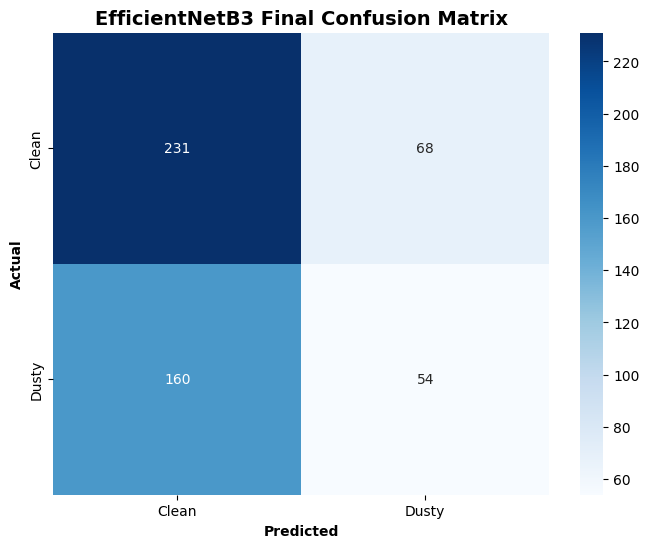

In [45]:
# Final confusion matrix on the last trained model
test_generator.reset()
final_predictions = tuned_effi_model.predict(test_generator)
y_pred_final = (final_predictions > 0.5).astype(int).flatten()
y_true_final = test_generator.classes

print('\nFinal Classification Report (EfficientNetB3):')
print(classification_report(y_true_final, y_pred_final, target_names=['Clean', 'Dusty']))

# Confusion Matrix
cm_effi = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_effi, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clean', 'Dusty'],
            yticklabels=['Clean', 'Dusty'])
plt.title('EfficientNetB3 Final Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.show()

#### 3rd tuned (dropout = 0.1)

In [46]:
print("=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===")

# STEP 1: Get all images and labels from train_generator
print("\nGetting all generator data for EfficientNetB3...")
train_generator.reset()
all_images = []
all_labels = []

for i in range(len(train_generator)):
    batch_x, batch_y = train_generator[i]
    all_images.append(batch_x)
    all_labels.extend(batch_y)

# Convert to numpy arrays
X_all = np.vstack(all_images)
y_all = np.array(all_labels)

print(f"Total training data: {X_all.shape}")
print(f"Clean samples: {np.sum(y_all == 0)}")
print(f"Dusty samples: {np.sum(y_all == 1)}")

# STEP 2: Setup 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\n5-fold cross-validation setup complete for EfficientNetB3")

# STEP 3: Store results for each fold
efficientnet_fold_results = []

# STEP 4: Loop through each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all)):
    print(f"\nTRAINING EFFICIENTNETB3 FOLD {fold + 1}/5")

    # Split data for this fold
    X_train_fold = X_all[train_idx]
    y_train_fold = y_all[train_idx]
    X_val_fold = X_all[val_idx]
    y_val_fold = y_all[val_idx]

    print(f"\nTrain samples: {len(X_train_fold)}")
    print(f"Validation samples: {len(X_val_fold)}")

    # BUILD MODEL
    print(f"\nBuilding EfficientNetB3 Model for Fold {fold + 1}...")
    tuned_effi_model = Sequential([
        EfficientNetB3(weights='imagenet',
                      include_top=False,
                      input_shape=(256, 256, 3)),
        GlobalAveragePooling2D(),
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dropout(0.1),
        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.1),
        Dense(1, activation='sigmoid',
              kernel_regularizer=regularizers.l2(0.01))
    ])

    # Setup Callbacks
    early_stopping = EarlyStopping(monitor='val_loss',
                                 patience=10,
                                 restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=5,
                                min_lr=0.0001)

    # Freeze the model initially
    tuned_effi_model.layers[0].trainable = False

    tuned_effi_model.compile(optimizer=Adam(learning_rate=0.0001),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

    print(f"\nEfficientNetB3 model built for fold {fold + 1}\n")
    tuned_effi_model.summary()

=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===

Getting all generator data for EfficientNetB3...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Total training data: (2049, 256, 256, 3)
Clean samples: 1194
Dusty samples: 855

5-fold cross-validation setup complete for EfficientNetB3

TRAINING EFFICIENTNETB3 FOLD 1/5

Train samples: 1639
Validation samples: 410

Building EfficientNetB3 Model for Fold 1...

EfficientNetB3 model built for fold 1



Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 8, 8, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,986,544 (41.91 MB)

 Trainable params: 199,937 (781.00 KB)

 Non-trainable params: 10,786,607 (41.15 MB)


TRAINING EFFICIENTNETB3 FOLD 2/5

Train samples: 1639
Validation samples: 410

Building EfficientNetB3 Model for Fold 2...

EfficientNetB3 model built for fold 2



Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 8, 8, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,986,544 (41.91 MB)

 Trainable params: 199,937 (781.00 KB)

 Non-trainable params: 10,786,607 (41.15 MB)


TRAINING EFFICIENTNETB3 FOLD 3/5

Train samples: 1639
Validation samples: 410

Building EfficientNetB3 Model for Fold 3...

EfficientNetB3 model built for fold 3



Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 8, 8, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,986,544 (41.91 MB)

 Trainable params: 199,937 (781.00 KB)

 Non-trainable params: 10,786,607 (41.15 MB)


TRAINING EFFICIENTNETB3 FOLD 4/5

Train samples: 1639
Validation samples: 410

Building EfficientNetB3 Model for Fold 4...

EfficientNetB3 model built for fold 4



Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 8, 8, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,986,544 (41.91 MB)

 Trainable params: 199,937 (781.00 KB)

 Non-trainable params: 10,786,607 (41.15 MB)


TRAINING EFFICIENTNETB3 FOLD 5/5

Train samples: 1640
Validation samples: 409

Building EfficientNetB3 Model for Fold 5...

EfficientNetB3 model built for fold 5



Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 8, 8, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,986,544 (41.91 MB)

 Trainable params: 199,937 (781.00 KB)

 Non-trainable params: 10,786,607 (41.15 MB)

In [47]:
# TRAIN MODEL
print(f"Training Fold {fold + 1}...")

history_fold_effi = tuned_effi_model.fit(
    X_train_fold, y_train_fold,
    validation_data=(X_val_fold, y_val_fold),
    epochs=80,
    batch_size=32,
    class_weight = calculated_class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)


Training Fold 5...
Epoch 1/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 67s 646ms/step - accuracy: 0.5098 - loss: 3.0647 - val_accuracy: 0.4181 - val_loss: 2.9110 - learning_rate: 1.0000e-04
Epoch 2/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4926 - loss: 2.8872 - val_accuracy: 0.4621 - val_loss: 2.7460 - learning_rate: 1.0000e-04
Epoch 3/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5242 - loss: 2.7231 - val_accuracy: 0.4132 - val_loss: 2.6086 - learning_rate: 1.0000e-04
Epoch 4/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5024 - loss: 2.5874 - val_accuracy: 0.4132 - val_loss: 2.4804 - learning_rate: 1.0000e-04
Epoch 5/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4812 - loss: 2.4701 - val_accuracy: 0.4939 - val_loss: 2.3642 - learning_rate: 1.0000e-04
Epoch 6/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4801 - loss: 2.3698 - val_accuracy: 0.5110 - val_loss: 2.2615 - learning_rate: 1.0000e-04
Epoch 7/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/ste

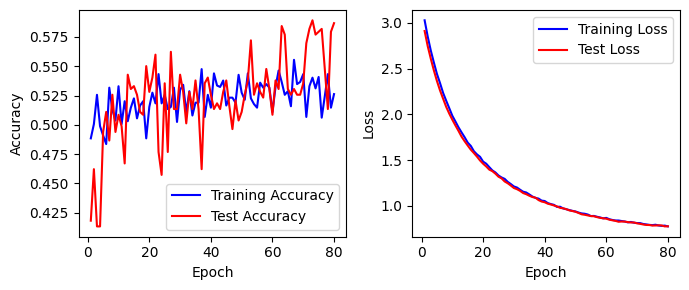

In [48]:
# Plotting EfficientNetB3 tuned model
accuracy = history_fold_effi.history['accuracy']
val_accuracy = history_fold_effi.history['val_accuracy']
loss = history_fold_effi.history['loss']
val_loss = history_fold_effi.history['val_loss']

epochs = range(1, len(accuracy) + 1)
# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
axes[0].plot(epochs, accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs, val_accuracy, 'r', label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label='Training Loss')
axes[1].plot(epochs, val_loss, 'r', label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [49]:
# Tuned Model Evaluation
test_loss, test_acc = tuned_effi_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 949ms/step - accuracy: 0.6111 - loss: 0.7624
Test Accuracy: 60.43%
Test Loss: 0.7671


In [50]:
#Classification Report - Tuned
test_generator.reset()
predictions = tuned_effi_model.predict(test_generator, verbose=0)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nFold {fold + 1} Results:")
print(f"  Test Accuracy: {test_acc * 100:.2f}%")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

# Store results - MOVED INSIDE THE LOOP
efficientnet_fold_results.append({
    'fold': fold + 1,
    'accuracy': test_acc,
    'loss': test_loss,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'history': history_fold_effi
})

print('Classification Report (Tuned):')
print(classification_report(y_true, y_pred_pre, target_names=['Clean', 'Dusty']))


Fold 5 Results:
  Test Accuracy: 60.43%
  Test Loss: 0.7671
  Precision: 0.4261
  Recall: 0.2290
  F1-Score: 0.2979
Classification Report (Tuned):
              precision    recall  f1-score   support

       Clean       0.58      1.00      0.74       299
       Dusty       1.00      0.00      0.01       214

    accuracy                           0.58       513
   macro avg       0.79      0.50      0.37       513
weighted avg       0.76      0.58      0.43       513



In [51]:
# STEP 5: Calculate final results
print("EFFICIENTNETB3 5-FOLD CROSS-VALIDATION RESULTS")

# Extract all metrics
accuracies = [result['accuracy'] for result in efficientnet_fold_results]
precisions = [result['precision'] for result in efficientnet_fold_results]
recalls = [result['recall'] for result in efficientnet_fold_results]
f1_scores = [result['f1_score'] for result in efficientnet_fold_results]

# Calculate means and standard deviations
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
mean_precision = np.mean(precisions)
std_precision = np.std(precisions)
mean_recall = np.mean(recalls)
std_recall = np.std(recalls)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

# Print results
print(f"\nMean Test Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")
print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")

print(f"\nDetailed Results by Fold:")
for i, result in enumerate(efficientnet_fold_results):
    print(f"Fold {i+1}: Acc={result['accuracy']*100:.1f}%, "
          f"Prec={result['precision']:.3f}, "
          f"Rec={result['recall']:.3f}, "
          f"F1={result['f1_score']:.3f}")


EFFICIENTNETB3 5-FOLD CROSS-VALIDATION RESULTS

Mean Test Accuracy: 60.43% ± 0.00%
Mean Precision: 0.4261 ± 0.0000
Mean Recall: 0.2290 ± 0.0000
Mean F1-Score: 0.2979 ± 0.0000

Detailed Results by Fold:
Fold 1: Acc=60.4%, Prec=0.426, Rec=0.229, F1=0.298



Plotting EfficientNetB3 Cross-Validation Results...


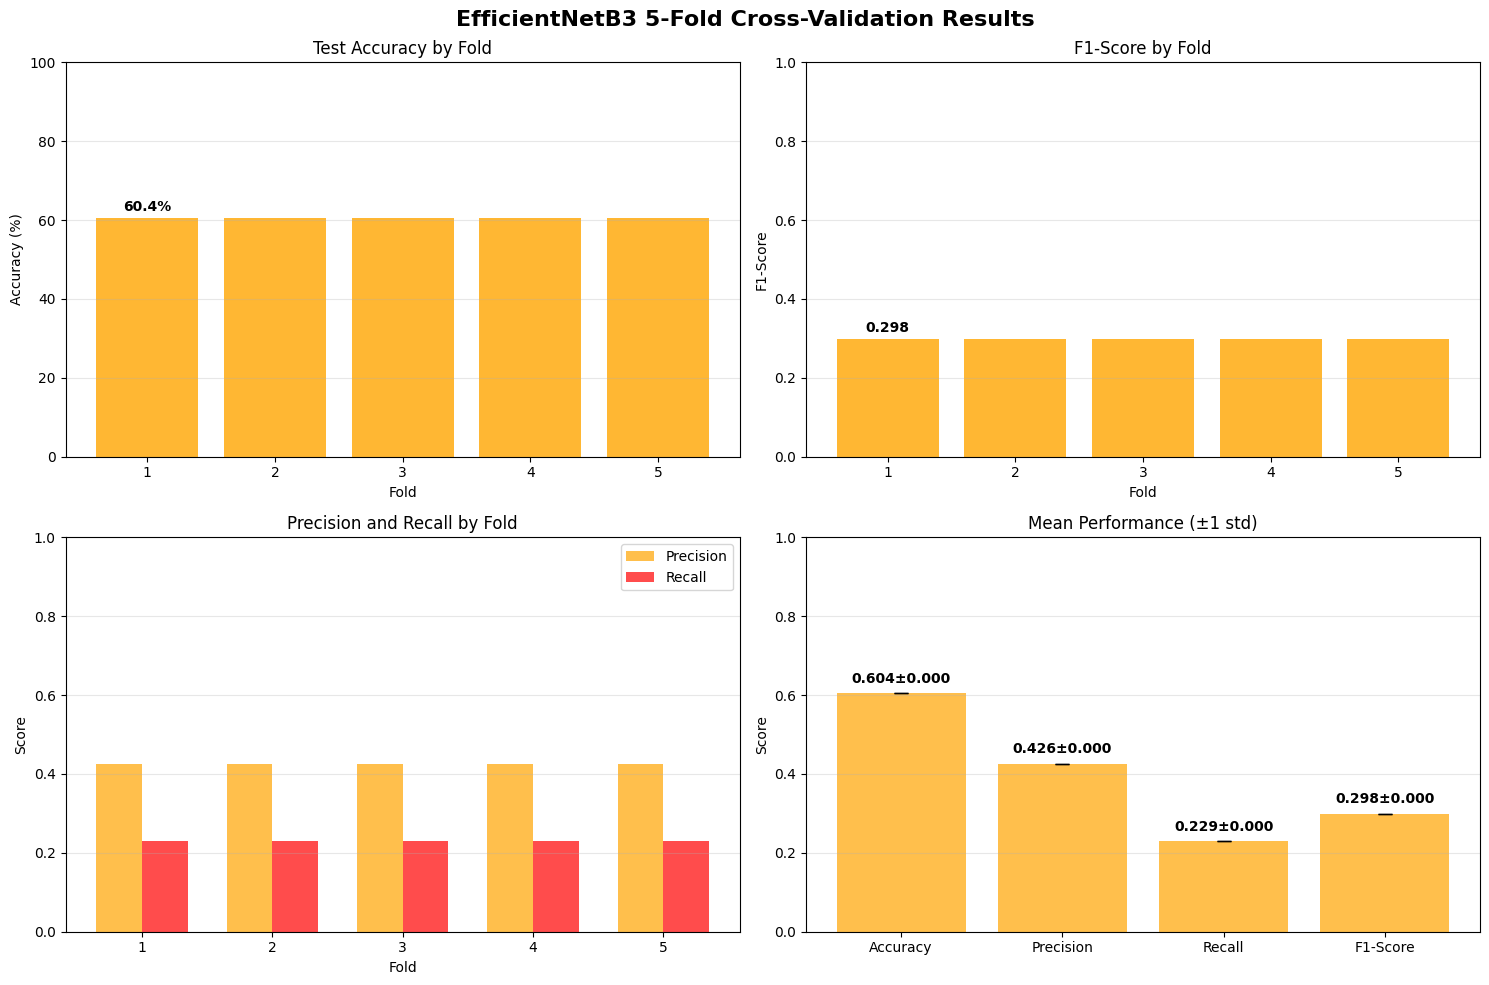

EfficientNetB3 5-fold cross-validation completed successfully!


In [52]:
# STEP 6: Create comprehensive plots
print(f"\nPlotting EfficientNetB3 Cross-Validation Results...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('EfficientNetB3 5-Fold Cross-Validation Results', fontsize=16, fontweight='bold')

fold_numbers = list(range(1, 6))

# Plot 1: Accuracy by fold
bars1 = axes[0, 0].bar(fold_numbers, [acc * 100 for acc in accuracies], color='orange', alpha=0.8)
axes[0, 0].set_title('Test Accuracy by Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_ylim(0, 100)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{acc*100:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: F1-Score by fold
bars2 = axes[0, 1].bar(fold_numbers, f1_scores, color='orange', alpha=0.8)
axes[0, 1].set_title('F1-Score by Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, f1) in enumerate(zip(bars2, f1_scores)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Precision and Recall by fold
x = np.arange(len(fold_numbers))
width = 0.35

bars3 = axes[1, 0].bar(x - width/2, precisions, width, label='Precision', color='orange', alpha=0.7)
bars4 = axes[1, 0].bar(x + width/2, recalls, width, label='Recall', color='red', alpha=0.7)
axes[1, 0].set_title('Precision and Recall by Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(fold_numbers)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Summary statistics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
means = [mean_acc, mean_precision, mean_recall, mean_f1]
stds = [std_acc, std_precision, std_recall, std_f1]

bars5 = axes[1, 1].bar(metrics_names, means, yerr=stds, capsize=5, color='orange', alpha=0.7)
axes[1, 1].set_title('Mean Performance (±1 std)')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars5, means, stds)):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                   f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("EfficientNetB3 5-fold cross-validation completed successfully!")


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 677ms/step

Final Classification Report (EfficientNetB3):
              precision    recall  f1-score   support

       Clean       0.58      0.77      0.66       299
       Dusty       0.41      0.22      0.29       214

    accuracy                           0.54       513
   macro avg       0.49      0.50      0.47       513
weighted avg       0.51      0.54      0.51       513



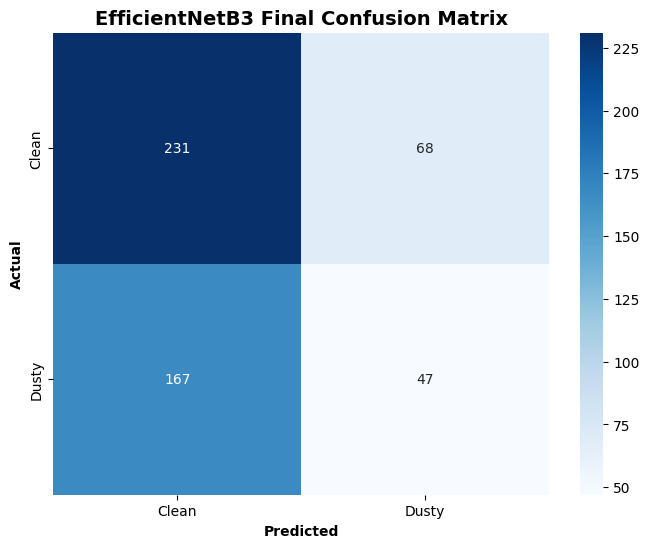

In [53]:
# Final confusion matrix on the last trained model
test_generator.reset()
final_predictions = tuned_effi_model.predict(test_generator)
y_pred_final = (final_predictions > 0.5).astype(int).flatten()
y_true_final = test_generator.classes

print('\nFinal Classification Report (EfficientNetB3):')
print(classification_report(y_true_final, y_pred_final, target_names=['Clean', 'Dusty']))

# Confusion Matrix
cm_effi = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_effi, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clean', 'Dusty'],
            yticklabels=['Clean', 'Dusty'])
plt.title('EfficientNetB3 Final Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.show()

## 2nd Model: DenseNet-121

### pre-train DenseNet-121

In [54]:
print("\nBuilding DenseNet-121 Pre-train Model...")

pre_dn_model = Sequential([
    DenseNet121(weights='imagenet',
                   include_top = False,
                   input_shape = (256, 256, 3)),
    GlobalAveragePooling2D(),
    Dense(128, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

# Freeze the pre-trained model initially
pre_dn_model.layers[0].trainable = False

pre_dn_model.compile(optimizer = Adam(learning_rate = 0.0001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

print("DenseNet-121 model has been built.\n")
pre_dn_model.summary()


Building DenseNet-121 Pre-train Model...
DenseNet-121 model has been built.



Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [55]:
history_pre_dn = pre_dn_model.fit(
    train_generator,
    validation_data = test_generator,
    epochs = 10,
    class_weight = calculated_class_weights_dict
)

Epoch 1/10
 4/65 ━━━━━━━━━━━━━━━━━━━━ 53s 876ms/step - accuracy: 0.5540 - loss: 0.6872

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.5736 - loss: 0.6844 - val_accuracy: 0.6862 - val_loss: 0.5811
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.6932 - loss: 0.5772 - val_accuracy: 0.7407 - val_loss: 0.5311
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7131 - loss: 0.5427 - val_accuracy: 0.7544 - val_loss: 0.5104
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.7274 - loss: 0.5458 - val_accuracy: 0.7622 - val_loss: 0.4932
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.7329 - loss: 0.5154 - val_accuracy: 0.7680 - val_loss: 0.4854
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.7522 - loss: 0.4959 - val_accuracy: 0.7778 - val_loss: 0.4737
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.7364 - loss: 0.5031 - val_accuracy: 0.7719 - val_loss: 0.4601
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7753 - loss: 0.4643 - val_accuracy: 0.7602 - val_loss: 0.4864
Ep

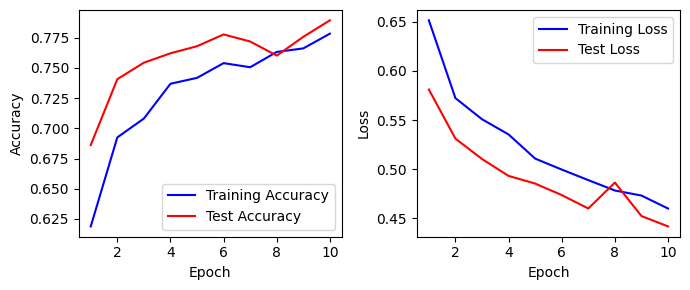

In [56]:
# Plotting DenseNet-121 pre-trained model
accuracy = history_pre_dn.history['accuracy']
val_accuracy = history_pre_dn.history['val_accuracy']
loss = history_pre_dn.history['loss']
val_loss = history_pre_dn.history['val_loss']

epochs = range(1, len(accuracy) + 1)
# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
axes[0].plot(epochs, accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs, val_accuracy, 'r', label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label='Training Loss')
axes[1].plot(epochs, val_loss, 'r', label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [57]:
# Pre-trained Model Evaluation
dn_test_loss, dn_test_acc = pre_dn_model.evaluate(test_generator)
print(f"Test Accuracy: {dn_test_acc * 100:.2f}%")
print(f"Test Loss: {dn_test_loss:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 658ms/step - accuracy: 0.7747 - loss: 0.4582
Test Accuracy: 78.95%
Test Loss: 0.4418


In [58]:
#Classification Report - Pre-trained
test_generator.reset()
predictions = pre_dn_model.predict(test_generator)
print("PREDICTION DEBUGGING:")
print(f"Prediction range: {predictions.min():.3f} to {predictions.max():.3f}")
print(f"Predictions > 0.5: {np.sum(predictions > 0.5)}")
print(f"Predictions <= 0.5: {np.sum(predictions <= 0.5)}")
print(f"First 10 predictions: {predictions.flatten()[:10]}")

y_pred_pre = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

precision = precision_score(y_true, y_pred_pre)
recall = recall_score(y_true, y_pred_pre)
f1 = f1_score(y_true, y_pred_pre)

print('Classification Report (Pre-trained):')
print(classification_report(y_true, y_pred_pre, target_names=['Clean', 'Dusty']))

17/17 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step
PREDICTION DEBUGGING:
Prediction range: 0.016 to 0.979
Predictions > 0.5: 190
Predictions <= 0.5: 323
First 10 predictions: [0.17855938 0.11855669 0.337511   0.1138213  0.65730035 0.13925284
 0.11323595 0.2271124  0.1660298  0.39710388]
Classification Report (Pre-trained):
              precision    recall  f1-score   support

       Clean       0.60      0.65      0.62       299
       Dusty       0.45      0.40      0.42       214

    accuracy                           0.54       513
   macro avg       0.52      0.52      0.52       513
weighted avg       0.54      0.54      0.54       513



17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 655ms/step

Final Classification Report (DenseNet-121):
              precision    recall  f1-score   support

       Clean       0.59      0.64      0.62       299
       Dusty       0.44      0.39      0.41       214

    accuracy                           0.54       513
   macro avg       0.52      0.51      0.51       513
weighted avg       0.53      0.54      0.53       513



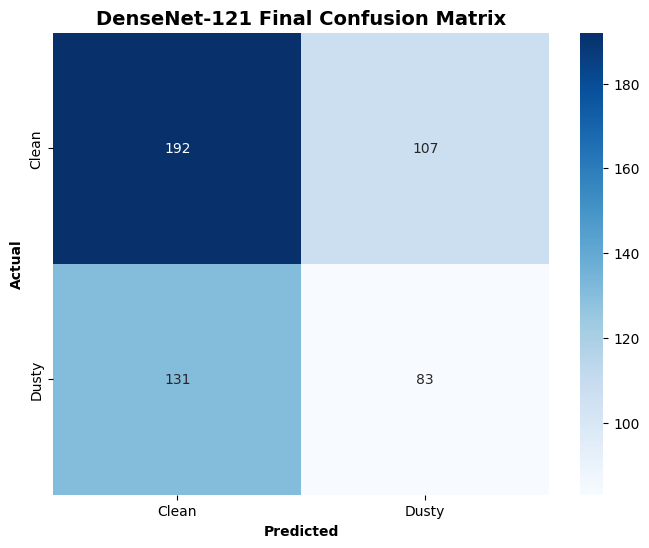

In [59]:
# Final confusion matrix on the last trained model
test_generator.reset()
final_predictions = pre_dn_model.predict(test_generator)
y_pred_final = (final_predictions > 0.5).astype(int).flatten()
y_true_final = test_generator.classes

print('\nFinal Classification Report (DenseNet-121):')
print(classification_report(y_true_final, y_pred_final, target_names=['Clean', 'Dusty']))

# Confusion Matrix
cm_dn = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clean', 'Dusty'],
            yticklabels=['Clean', 'Dusty'])
plt.title('DenseNet-121 Final Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.show()

### Hyperparameter tuning

#### 1st Tuned (dropout = 0.3)




In [60]:
print("=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===")

# STEP 1: Get all images and labels from train_generator
print("\nGetting all generator data for DenseNet-121...")
train_generator.reset()
all_images = []
all_labels = []

for i in range(len(train_generator)):
    batch_x, batch_y = train_generator[i]
    all_images.append(batch_x)
    all_labels.extend(batch_y)

# Convert to numpy arrays
X_all = np.vstack(all_images)
y_all = np.array(all_labels)

print(f"Total training data: {X_all.shape}")
print(f"Clean samples: {np.sum(y_all == 0)}")
print(f"Dusty samples: {np.sum(y_all == 1)}")

# STEP 2: Setup 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\n5-fold cross-validation setup complete for DenseNet-121")

# STEP 3: Store results for each fold
densenet_fold_results = []

# STEP 4: Loop through each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all)):
    print(f"\nTRAINING DENSENET-121 FOLD {fold + 1}/5")

    # Split data for this fold
    X_train_fold = X_all[train_idx]
    y_train_fold = y_all[train_idx]
    X_val_fold = X_all[val_idx]
    y_val_fold = y_all[val_idx]

    print(f"\nTrain samples: {len(X_train_fold)}")
    print(f"Validation samples: {len(X_val_fold)}")

    # BUILD MODEL
    print(f"\nBuilding DenseNet-121 Model for Fold {fold + 1}...")
    tuned_densenet_model = Sequential([
        DenseNet121(weights='imagenet',
                      include_top=False,
                      input_shape=(256, 256, 3)),
        GlobalAveragePooling2D(),
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dropout(0.3),
        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.3),
        Dense(1, activation='sigmoid',
              kernel_regularizer=regularizers.l2(0.01))
    ])

    # Setup Callbacks
    early_stopping = EarlyStopping(monitor='val_loss',
                                 patience=10,
                                 restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=5,
                                min_lr=0.0001)

    # Freeze the model initially
    tuned_densenet_model.layers[0].trainable = False

    tuned_densenet_model.compile(optimizer=Adam(learning_rate=0.0001),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

    print(f"\nDensenet-121 model built for fold {fold + 1}\n")
    tuned_densenet_model.summary()

=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===

Getting all generator data for DenseNet-121...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Total training data: (2049, 256, 256, 3)
Clean samples: 1194
Dusty samples: 855

5-fold cross-validation setup complete for DenseNet-121

TRAINING DENSENET-121 FOLD 1/5

Train samples: 1639
Validation samples: 410

Building DenseNet-121 Model for Fold 1...

Densenet-121 model built for fold 1



Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_17     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,172,929 (27.36 MB)

 Trainable params: 133,377 (521.00 KB)

 Non-trainable params: 7,039,552 (26.85 MB)


TRAINING DENSENET-121 FOLD 2/5

Train samples: 1639
Validation samples: 410

Building DenseNet-121 Model for Fold 2...

Densenet-121 model built for fold 2



Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,172,929 (27.36 MB)

 Trainable params: 133,377 (521.00 KB)

 Non-trainable params: 7,039,552 (26.85 MB)


TRAINING DENSENET-121 FOLD 3/5

Train samples: 1639
Validation samples: 410

Building DenseNet-121 Model for Fold 3...

Densenet-121 model built for fold 3



Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_19     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,172,929 (27.36 MB)

 Trainable params: 133,377 (521.00 KB)

 Non-trainable params: 7,039,552 (26.85 MB)


TRAINING DENSENET-121 FOLD 4/5

Train samples: 1639
Validation samples: 410

Building DenseNet-121 Model for Fold 4...

Densenet-121 model built for fold 4



Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_20     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,172,929 (27.36 MB)

 Trainable params: 133,377 (521.00 KB)

 Non-trainable params: 7,039,552 (26.85 MB)


TRAINING DENSENET-121 FOLD 5/5

Train samples: 1640
Validation samples: 409

Building DenseNet-121 Model for Fold 5...

Densenet-121 model built for fold 5



Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_21     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,172,929 (27.36 MB)

 Trainable params: 133,377 (521.00 KB)

 Non-trainable params: 7,039,552 (26.85 MB)

In [61]:
# TRAIN MODEL
print(f"Training Fold {fold + 1}...")

history_fold_densenet = tuned_densenet_model.fit(
    X_train_fold, y_train_fold,
    validation_data=(X_val_fold, y_val_fold),
    epochs=80,
    batch_size=32,
    class_weight = calculated_class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)


Training Fold 5...
Epoch 1/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 58s 686ms/step - accuracy: 0.5240 - loss: 3.0561 - val_accuracy: 0.6161 - val_loss: 2.7413 - learning_rate: 1.0000e-04
Epoch 2/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6398 - loss: 2.7136 - val_accuracy: 0.6724 - val_loss: 2.5102 - learning_rate: 1.0000e-04
Epoch 3/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6859 - loss: 2.4511 - val_accuracy: 0.7042 - val_loss: 2.3208 - learning_rate: 1.0000e-04
Epoch 4/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6998 - loss: 2.2899 - val_accuracy: 0.7115 - val_loss: 2.1654 - learning_rate: 1.0000e-04
Epoch 5/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7273 - loss: 2.0992 - val_accuracy: 0.7139 - val_loss: 2.0345 - learning_rate: 1.0000e-04
Epoch 6/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7230 - loss: 1.9783 - val_accuracy: 0.7237 - val_loss: 1.9175 - learning_rate: 1.0000e-04
Epoch 7/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/ste


Plotting training history for Fold 5...


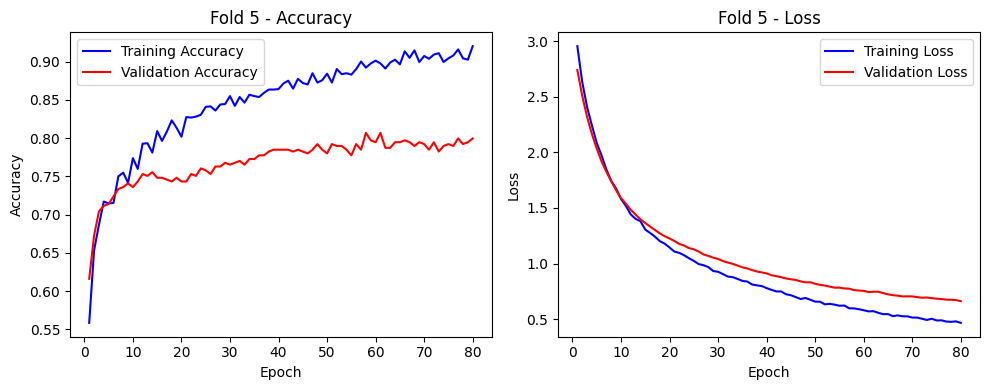

In [62]:
# Plotting DenseNet-121 tuned model
print(f"\nPlotting training history for Fold {fold + 1}...")
accuracy = history_fold_densenet.history['accuracy']
val_accuracy = history_fold_densenet.history['val_accuracy']
loss = history_fold_densenet.history['loss']
val_loss = history_fold_densenet.history['val_loss']

epochs_trained = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(epochs_trained, accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs_trained, val_accuracy, 'r', label='Validation Accuracy')
axes[0].set_title(f'Fold {fold+1} - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs_trained, loss, 'b', label='Training Loss')
axes[1].plot(epochs_trained, val_loss, 'r', label='Validation Loss')
axes[1].set_title(f'Fold {fold+1} - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [63]:
# Tuned Model Evaluation
test_loss, test_acc = tuned_densenet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8310 - loss: 0.6083
Test Accuracy: 83.04%
Test Loss: 0.6101


In [64]:
#Classification Report - Tuned
test_generator.reset()
predictions = tuned_densenet_model.predict(test_generator, verbose=0)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nFold {fold + 1} Results:")
print(f"  Test Accuracy: {test_acc * 100:.2f}%")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

# Store results - MOVED INSIDE THE LOOP
densenet_fold_results.append({
    'fold': fold + 1,
    'accuracy': test_acc,
    'loss': test_loss,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'history': history_fold_densenet
})

print('Classification Report (Tuned):')
print(classification_report(y_true, y_pred_pre, target_names=['Clean', 'Dusty']))


Fold 5 Results:
  Test Accuracy: 83.04%
  Test Loss: 0.6101
  Precision: 0.3898
  Recall: 0.3224
  F1-Score: 0.3529
Classification Report (Tuned):
              precision    recall  f1-score   support

       Clean       0.60      0.65      0.62       299
       Dusty       0.45      0.40      0.42       214

    accuracy                           0.54       513
   macro avg       0.52      0.52      0.52       513
weighted avg       0.54      0.54      0.54       513



In [65]:
# STEP 5: Calculate final results
print("DENSENET-121 5-FOLD CROSS-VALIDATION RESULTS")

# Extract all metrics
accuracies = [result['accuracy'] for result in densenet_fold_results]
precisions = [result['precision'] for result in densenet_fold_results]
recalls = [result['recall'] for result in densenet_fold_results]
f1_scores = [result['f1_score'] for result in densenet_fold_results]

# Calculate means and standard deviations
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
mean_precision = np.mean(precisions)
std_precision = np.std(precisions)
mean_recall = np.mean(recalls)
std_recall = np.std(recalls)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

# Print results
print(f"\nMean Test Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")
print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")

print(f"\nDetailed Results by Fold:")
for i, result in enumerate(densenet_fold_results):
    print(f"Fold {i+1}: Acc={result['accuracy']*100:.1f}%, "
          f"Prec={result['precision']:.3f}, "
          f"Rec={result['recall']:.3f}, "
          f"F1={result['f1_score']:.3f}")


DENSENET-121 5-FOLD CROSS-VALIDATION RESULTS

Mean Test Accuracy: 83.04% ± 0.00%
Mean Precision: 0.3898 ± 0.0000
Mean Recall: 0.3224 ± 0.0000
Mean F1-Score: 0.3529 ± 0.0000

Detailed Results by Fold:
Fold 1: Acc=83.0%, Prec=0.390, Rec=0.322, F1=0.353



Plotting DenseNet-121 Cross-Validation Results...


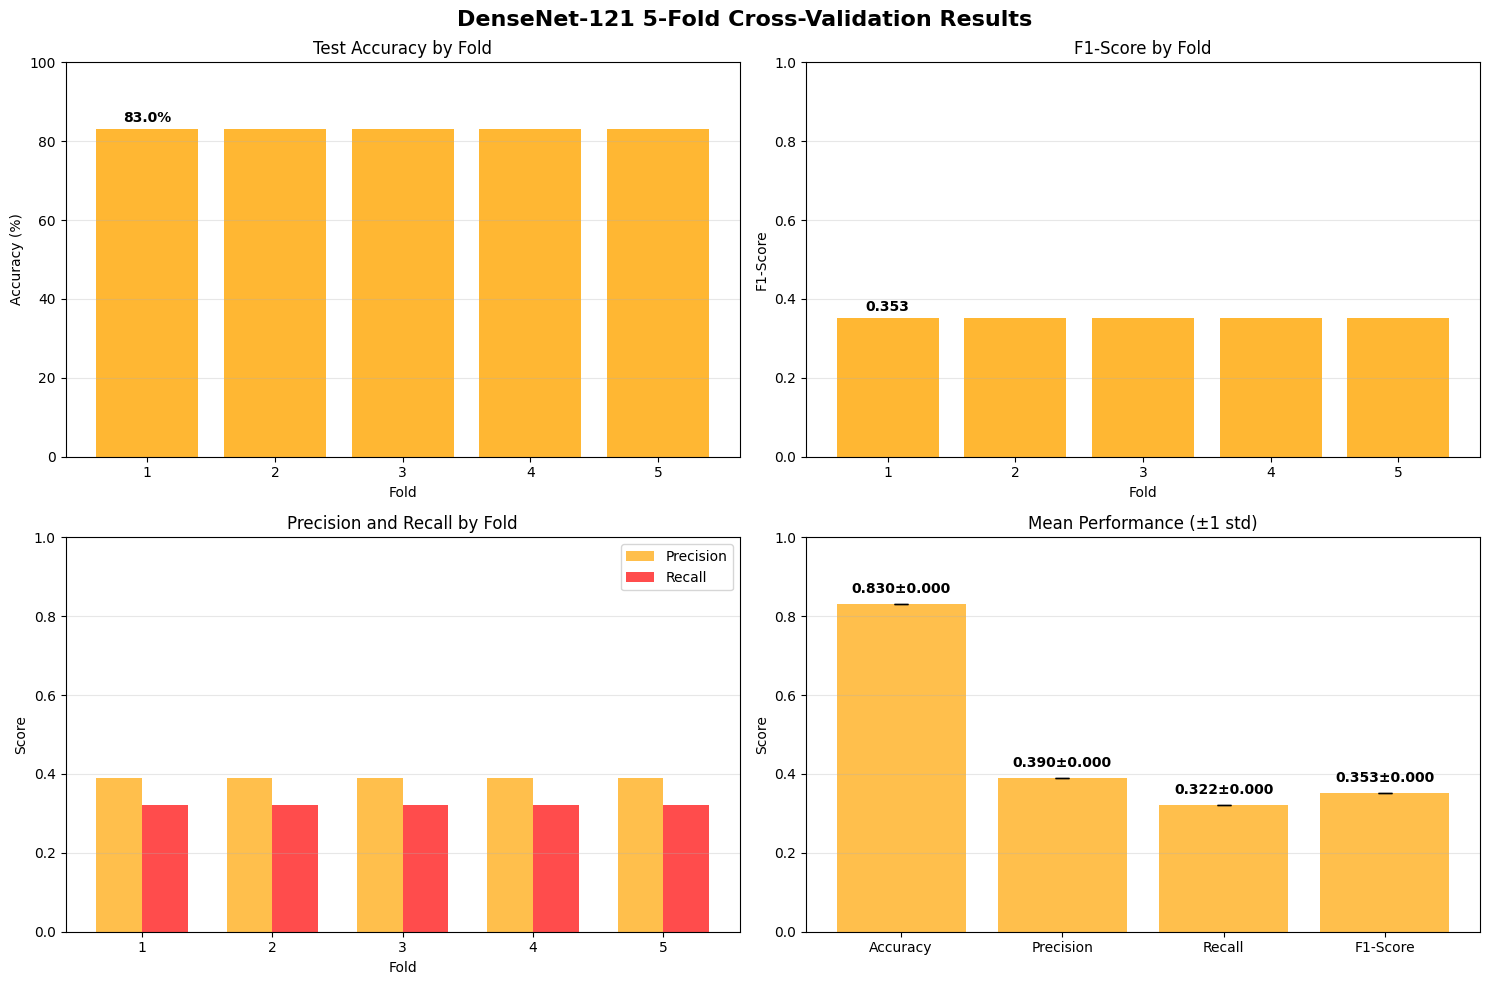

DenseNet-121 5-fold cross-validation completed successfully!


In [66]:
# STEP 6: Create comprehensive plots
print(f"\nPlotting DenseNet-121 Cross-Validation Results...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('DenseNet-121 5-Fold Cross-Validation Results', fontsize=16, fontweight='bold')

fold_numbers = list(range(1, 6))

# Plot 1: Accuracy by fold
bars1 = axes[0, 0].bar(fold_numbers, [acc * 100 for acc in accuracies], color='orange', alpha=0.8)
axes[0, 0].set_title('Test Accuracy by Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_ylim(0, 100)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{acc*100:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: F1-Score by fold
bars2 = axes[0, 1].bar(fold_numbers, f1_scores, color='orange', alpha=0.8)
axes[0, 1].set_title('F1-Score by Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, f1) in enumerate(zip(bars2, f1_scores)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Precision and Recall by fold
x = np.arange(len(fold_numbers))
width = 0.35

bars3 = axes[1, 0].bar(x - width/2, precisions, width, label='Precision', color='orange', alpha=0.7)
bars4 = axes[1, 0].bar(x + width/2, recalls, width, label='Recall', color='red', alpha=0.7)
axes[1, 0].set_title('Precision and Recall by Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(fold_numbers)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Summary statistics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
means = [mean_acc, mean_precision, mean_recall, mean_f1]
stds = [std_acc, std_precision, std_recall, std_f1]

bars5 = axes[1, 1].bar(metrics_names, means, yerr=stds, capsize=5, color='orange', alpha=0.7)
axes[1, 1].set_title('Mean Performance (±1 std)')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars5, means, stds)):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                   f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("DenseNet-121 5-fold cross-validation completed successfully!")


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 647ms/step

Final Classification Report (DenseNet-121):
              precision    recall  f1-score   support

       Clean       0.60      0.67      0.63       299
       Dusty       0.45      0.37      0.40       214

    accuracy                           0.55       513
   macro avg       0.52      0.52      0.52       513
weighted avg       0.53      0.55      0.54       513



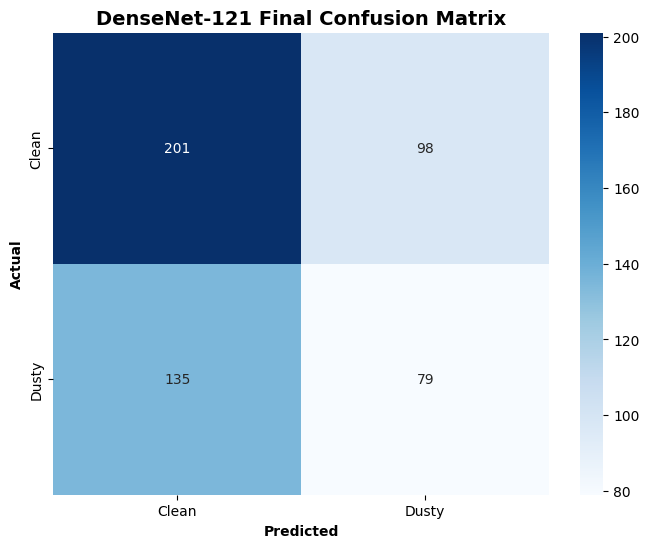

In [67]:
# Final confusion matrix on the last trained model
test_generator.reset()
final_predictions = tuned_densenet_model.predict(test_generator)
y_pred_final = (final_predictions > 0.5).astype(int).flatten()
y_true_final = test_generator.classes

print('\nFinal Classification Report (DenseNet-121):')
print(classification_report(y_true_final, y_pred_final, target_names=['Clean', 'Dusty']))

# Confusion Matrix
cm = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clean', 'Dusty'],
            yticklabels=['Clean', 'Dusty'])
plt.title('DenseNet-121 Final Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.show()

#### 2nd Tuned (dropout = 0.2)

In [68]:
print("=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===")

# STEP 1: Get all images and labels from train_generator
print("\nGetting all generator data for DenseNet-121...")
train_generator.reset()
all_images = []
all_labels = []

for i in range(len(train_generator)):
    batch_x, batch_y = train_generator[i]
    all_images.append(batch_x)
    all_labels.extend(batch_y)

# Convert to numpy arrays
X_all = np.vstack(all_images)
y_all = np.array(all_labels)

print(f"Total training data: {X_all.shape}")
print(f"Clean samples: {np.sum(y_all == 0)}")
print(f"Dusty samples: {np.sum(y_all == 1)}")

# STEP 2: Setup 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\n5-fold cross-validation setup complete for DenseNet-121")

# STEP 3: Store results for each fold
densenet_fold_results = []

# STEP 4: Loop through each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all)):
    print(f"\nTRAINING DENSENET-121 FOLD {fold + 1}/5")

    # Split data for this fold
    X_train_fold = X_all[train_idx]
    y_train_fold = y_all[train_idx]
    X_val_fold = X_all[val_idx]
    y_val_fold = y_all[val_idx]

    print(f"\nTrain samples: {len(X_train_fold)}")
    print(f"Validation samples: {len(X_val_fold)}")

    # BUILD MODEL
    print(f"\nBuilding DenseNet-121 Model for Fold {fold + 1}...")
    tuned_densenet_model = Sequential([
        DenseNet121(weights='imagenet',
                      include_top=False,
                      input_shape=(256, 256, 3)),
        GlobalAveragePooling2D(),
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dropout(0.2),
        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.2),
        Dense(1, activation='sigmoid',
              kernel_regularizer=regularizers.l2(0.01))
    ])

    # Setup Callbacks
    early_stopping = EarlyStopping(monitor='val_loss',
                                 patience=10,
                                 restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=5,
                                min_lr=0.0001)

    # Freeze the model initially
    tuned_densenet_model.layers[0].trainable = False

    tuned_densenet_model.compile(optimizer=Adam(learning_rate=0.0001),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

    print(f"\nDensenet-121 model built for fold {fold + 1}\n")
    tuned_densenet_model.summary()

=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===

Getting all generator data for DenseNet-121...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Total training data: (2049, 256, 256, 3)
Clean samples: 1194
Dusty samples: 855

5-fold cross-validation setup complete for DenseNet-121

TRAINING DENSENET-121 FOLD 1/5

Train samples: 1639
Validation samples: 410

Building DenseNet-121 Model for Fold 1...

Densenet-121 model built for fold 1



Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_22     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,172,929 (27.36 MB)

 Trainable params: 133,377 (521.00 KB)

 Non-trainable params: 7,039,552 (26.85 MB)


TRAINING DENSENET-121 FOLD 2/5

Train samples: 1639
Validation samples: 410

Building DenseNet-121 Model for Fold 2...

Densenet-121 model built for fold 2



Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_23     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,172,929 (27.36 MB)

 Trainable params: 133,377 (521.00 KB)

 Non-trainable params: 7,039,552 (26.85 MB)


TRAINING DENSENET-121 FOLD 3/5

Train samples: 1639
Validation samples: 410

Building DenseNet-121 Model for Fold 3...

Densenet-121 model built for fold 3



Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_24     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,172,929 (27.36 MB)

 Trainable params: 133,377 (521.00 KB)

 Non-trainable params: 7,039,552 (26.85 MB)


TRAINING DENSENET-121 FOLD 4/5

Train samples: 1639
Validation samples: 410

Building DenseNet-121 Model for Fold 4...

Densenet-121 model built for fold 4



Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_25     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,172,929 (27.36 MB)

 Trainable params: 133,377 (521.00 KB)

 Non-trainable params: 7,039,552 (26.85 MB)


TRAINING DENSENET-121 FOLD 5/5

Train samples: 1640
Validation samples: 409

Building DenseNet-121 Model for Fold 5...

Densenet-121 model built for fold 5



Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_26     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,172,929 (27.36 MB)

 Trainable params: 133,377 (521.00 KB)

 Non-trainable params: 7,039,552 (26.85 MB)

In [69]:
# TRAIN MODEL
print(f"Training Fold {fold + 1}...")

history_fold_densenet = tuned_densenet_model.fit(
    X_train_fold, y_train_fold,
    validation_data=(X_val_fold, y_val_fold),
    epochs=80,
    batch_size=32,
    class_weight = calculated_class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)


Training Fold 5...
Epoch 1/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 50s 529ms/step - accuracy: 0.5776 - loss: 2.9696 - val_accuracy: 0.6479 - val_loss: 2.7205 - learning_rate: 1.0000e-04
Epoch 2/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6866 - loss: 2.6241 - val_accuracy: 0.6822 - val_loss: 2.4755 - learning_rate: 1.0000e-04
Epoch 3/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6911 - loss: 2.3884 - val_accuracy: 0.6846 - val_loss: 2.2780 - learning_rate: 1.0000e-04
Epoch 4/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7503 - loss: 2.1644 - val_accuracy: 0.7017 - val_loss: 2.1134 - learning_rate: 1.0000e-04
Epoch 5/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7692 - loss: 2.0135 - val_accuracy: 0.7359 - val_loss: 1.9705 - learning_rate: 1.0000e-04
Epoch 6/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7809 - loss: 1.8617 - val_accuracy: 0.7433 - val_loss: 1.8527 - learning_rate: 1.0000e-04
Epoch 7/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/ste


Plotting training history for Fold 5...


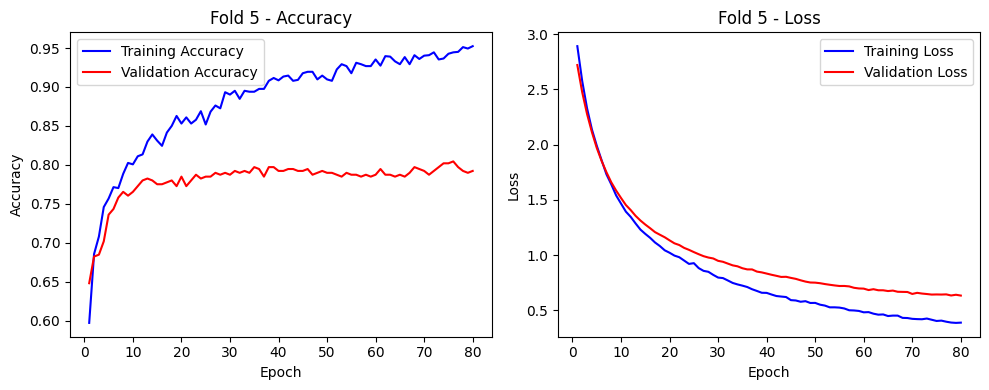

In [70]:
# Plotting DenseNet-121 tuned model
print(f"\nPlotting training history for Fold {fold + 1}...")
accuracy = history_fold_densenet.history['accuracy']
val_accuracy = history_fold_densenet.history['val_accuracy']
loss = history_fold_densenet.history['loss']
val_loss = history_fold_densenet.history['val_loss']

epochs_trained = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(epochs_trained, accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs_trained, val_accuracy, 'r', label='Validation Accuracy')
axes[0].set_title(f'Fold {fold+1} - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs_trained, loss, 'b', label='Training Loss')
axes[1].plot(epochs_trained, val_loss, 'r', label='Validation Loss')
axes[1].set_title(f'Fold {fold+1} - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [71]:
# Tuned Model Evaluation
test_loss, test_acc = tuned_densenet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 958ms/step - accuracy: 0.8145 - loss: 0.6211
Test Accuracy: 79.92%
Test Loss: 0.6412


In [72]:
#Classification Report - Tuned
test_generator.reset()
predictions = tuned_densenet_model.predict(test_generator, verbose=0)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nFold {fold + 1} Results:")
print(f"  Test Accuracy: {test_acc * 100:.2f}%")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

# Store results - MOVED INSIDE THE LOOP
densenet_fold_results.append({
    'fold': fold + 1,
    'accuracy': test_acc,
    'loss': test_loss,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'history': history_fold_densenet
})

print('Classification Report (Tuned):')
print(classification_report(y_true, y_pred_pre, target_names=['Clean', 'Dusty']))


Fold 5 Results:
  Test Accuracy: 79.92%
  Test Loss: 0.6412
  Precision: 0.4124
  Recall: 0.3411
  F1-Score: 0.3734
Classification Report (Tuned):
              precision    recall  f1-score   support

       Clean       0.60      0.65      0.62       299
       Dusty       0.45      0.40      0.42       214

    accuracy                           0.54       513
   macro avg       0.52      0.52      0.52       513
weighted avg       0.54      0.54      0.54       513



In [73]:
# STEP 5: Calculate final results
print("DENSENET-121 5-FOLD CROSS-VALIDATION RESULTS")

# Extract all metrics
accuracies = [result['accuracy'] for result in densenet_fold_results]
precisions = [result['precision'] for result in densenet_fold_results]
recalls = [result['recall'] for result in densenet_fold_results]
f1_scores = [result['f1_score'] for result in densenet_fold_results]

# Calculate means and standard deviations
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
mean_precision = np.mean(precisions)
std_precision = np.std(precisions)
mean_recall = np.mean(recalls)
std_recall = np.std(recalls)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

# Print results
print(f"\nMean Test Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")
print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")

print(f"\nDetailed Results by Fold:")
for i, result in enumerate(densenet_fold_results):
    print(f"Fold {i+1}: Acc={result['accuracy']*100:.1f}%, "
          f"Prec={result['precision']:.3f}, "
          f"Rec={result['recall']:.3f}, "
          f"F1={result['f1_score']:.3f}")


DENSENET-121 5-FOLD CROSS-VALIDATION RESULTS

Mean Test Accuracy: 79.92% ± 0.00%
Mean Precision: 0.4124 ± 0.0000
Mean Recall: 0.3411 ± 0.0000
Mean F1-Score: 0.3734 ± 0.0000

Detailed Results by Fold:
Fold 1: Acc=79.9%, Prec=0.412, Rec=0.341, F1=0.373



Plotting DenseNet-121 Cross-Validation Results...


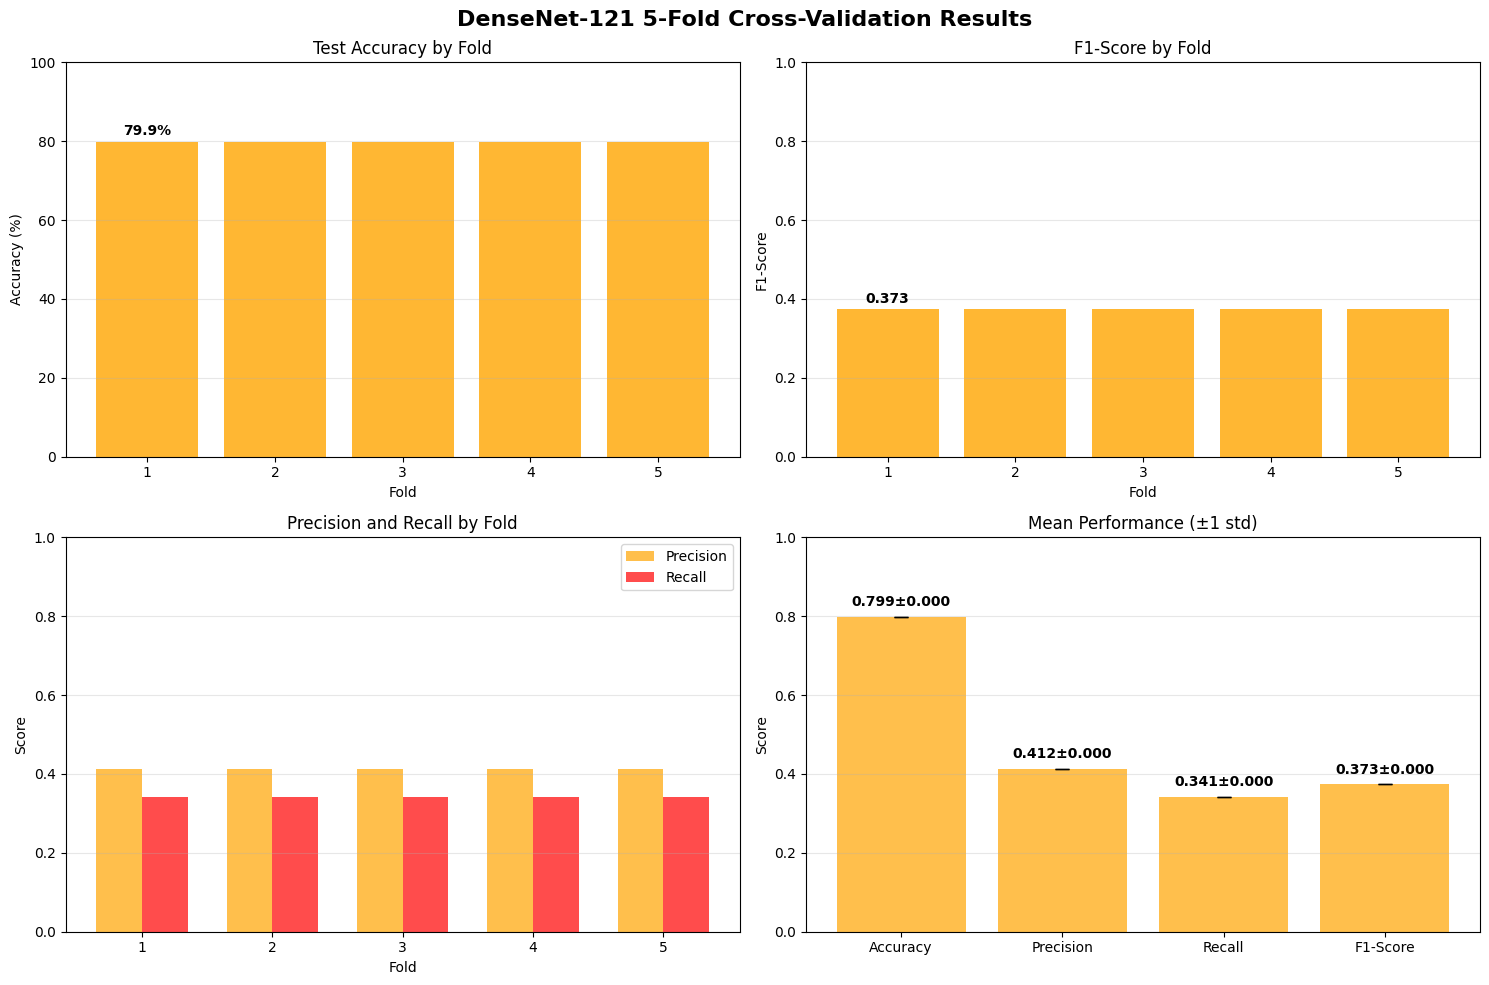

DenseNet-121 5-fold cross-validation completed successfully!


In [74]:
# STEP 6: Create comprehensive plots
print(f"\nPlotting DenseNet-121 Cross-Validation Results...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('DenseNet-121 5-Fold Cross-Validation Results', fontsize=16, fontweight='bold')

fold_numbers = list(range(1, 6))

# Plot 1: Accuracy by fold
bars1 = axes[0, 0].bar(fold_numbers, [acc * 100 for acc in accuracies], color='orange', alpha=0.8)
axes[0, 0].set_title('Test Accuracy by Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_ylim(0, 100)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{acc*100:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: F1-Score by fold
bars2 = axes[0, 1].bar(fold_numbers, f1_scores, color='orange', alpha=0.8)
axes[0, 1].set_title('F1-Score by Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, f1) in enumerate(zip(bars2, f1_scores)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Precision and Recall by fold
x = np.arange(len(fold_numbers))
width = 0.35

bars3 = axes[1, 0].bar(x - width/2, precisions, width, label='Precision', color='orange', alpha=0.7)
bars4 = axes[1, 0].bar(x + width/2, recalls, width, label='Recall', color='red', alpha=0.7)
axes[1, 0].set_title('Precision and Recall by Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(fold_numbers)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Summary statistics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
means = [mean_acc, mean_precision, mean_recall, mean_f1]
stds = [std_acc, std_precision, std_recall, std_f1]

bars5 = axes[1, 1].bar(metrics_names, means, yerr=stds, capsize=5, color='orange', alpha=0.7)
axes[1, 1].set_title('Mean Performance (±1 std)')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars5, means, stds)):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                   f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("DenseNet-121 5-fold cross-validation completed successfully!")


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 665ms/step

Final Classification Report (DenseNet-121):
              precision    recall  f1-score   support

       Clean       0.59      0.66      0.62       299
       Dusty       0.42      0.35      0.38       214

    accuracy                           0.53       513
   macro avg       0.51      0.50      0.50       513
weighted avg       0.52      0.53      0.52       513



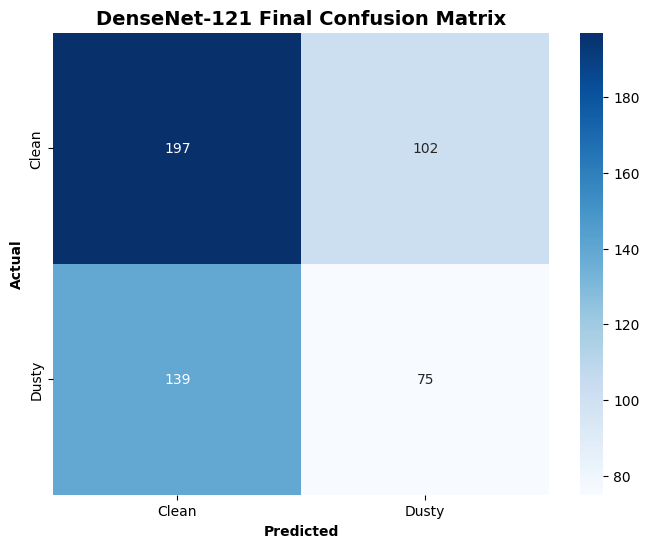

In [75]:
# Final confusion matrix on the last trained model
test_generator.reset()
final_predictions = tuned_densenet_model.predict(test_generator)
y_pred_final = (final_predictions > 0.5).astype(int).flatten()
y_true_final = test_generator.classes

print('\nFinal Classification Report (DenseNet-121):')
print(classification_report(y_true_final, y_pred_final, target_names=['Clean', 'Dusty']))

# Confusion Matrix
cm = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clean', 'Dusty'],
            yticklabels=['Clean', 'Dusty'])
plt.title('DenseNet-121 Final Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.show()

#### 3rd tuned (dropout = 0.1)

In [76]:
print("=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===")

# STEP 1: Get all images and labels from train_generator
print("\nGetting all generator data for DenseNet-121...")
train_generator.reset()
all_images = []
all_labels = []

for i in range(len(train_generator)):
    batch_x, batch_y = train_generator[i]
    all_images.append(batch_x)
    all_labels.extend(batch_y)

# Convert to numpy arrays
X_all = np.vstack(all_images)
y_all = np.array(all_labels)

print(f"Total training data: {X_all.shape}")
print(f"Clean samples: {np.sum(y_all == 0)}")
print(f"Dusty samples: {np.sum(y_all == 1)}")

# STEP 2: Setup 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\n5-fold cross-validation setup complete for DenseNet-121")

# STEP 3: Store results for each fold
densenet_fold_results = []

# STEP 4: Loop through each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all)):
    print(f"\nTRAINING DENSENET-121 FOLD {fold + 1}/5")

    # Split data for this fold
    X_train_fold = X_all[train_idx]
    y_train_fold = y_all[train_idx]
    X_val_fold = X_all[val_idx]
    y_val_fold = y_all[val_idx]

    print(f"\nTrain samples: {len(X_train_fold)}")
    print(f"Validation samples: {len(X_val_fold)}")

    # BUILD MODEL
    print(f"\nBuilding DenseNet-121 Model for Fold {fold + 1}...")
    tuned_densenet_model = Sequential([
        DenseNet121(weights='imagenet',
                      include_top=False,
                      input_shape=(256, 256, 3)),
        GlobalAveragePooling2D(),
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dropout(0.1),
        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.1),
        Dense(1, activation='sigmoid',
              kernel_regularizer=regularizers.l2(0.01))
    ])

    # Setup Callbacks
    early_stopping = EarlyStopping(monitor='val_loss',
                                 patience=10,
                                 restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=5,
                                min_lr=0.0001)

    # Freeze the model initially
    tuned_densenet_model.layers[0].trainable = False

    tuned_densenet_model.compile(optimizer=Adam(learning_rate=0.0001),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

    print(f"\nDensenet-121 model built for fold {fold + 1}\n")
    tuned_densenet_model.summary()

=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===

Getting all generator data for DenseNet-121...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Total training data: (2049, 256, 256, 3)
Clean samples: 1194
Dusty samples: 855

5-fold cross-validation setup complete for DenseNet-121

TRAINING DENSENET-121 FOLD 1/5

Train samples: 1639
Validation samples: 410

Building DenseNet-121 Model for Fold 1...

Densenet-121 model built for fold 1



Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_27     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,172,929 (27.36 MB)

 Trainable params: 133,377 (521.00 KB)

 Non-trainable params: 7,039,552 (26.85 MB)


TRAINING DENSENET-121 FOLD 2/5

Train samples: 1639
Validation samples: 410

Building DenseNet-121 Model for Fold 2...

Densenet-121 model built for fold 2



Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_28     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,172,929 (27.36 MB)

 Trainable params: 133,377 (521.00 KB)

 Non-trainable params: 7,039,552 (26.85 MB)


TRAINING DENSENET-121 FOLD 3/5

Train samples: 1639
Validation samples: 410

Building DenseNet-121 Model for Fold 3...

Densenet-121 model built for fold 3



Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_29     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,172,929 (27.36 MB)

 Trainable params: 133,377 (521.00 KB)

 Non-trainable params: 7,039,552 (26.85 MB)


TRAINING DENSENET-121 FOLD 4/5

Train samples: 1639
Validation samples: 410

Building DenseNet-121 Model for Fold 4...

Densenet-121 model built for fold 4



Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_30     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,172,929 (27.36 MB)

 Trainable params: 133,377 (521.00 KB)

 Non-trainable params: 7,039,552 (26.85 MB)


TRAINING DENSENET-121 FOLD 5/5

Train samples: 1640
Validation samples: 409

Building DenseNet-121 Model for Fold 5...

Densenet-121 model built for fold 5



Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_31     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,172,929 (27.36 MB)

 Trainable params: 133,377 (521.00 KB)

 Non-trainable params: 7,039,552 (26.85 MB)

In [77]:
# TRAIN MODEL
print(f"Training Fold {fold + 1}...")

history_fold_densenet = tuned_densenet_model.fit(
    X_train_fold, y_train_fold,
    validation_data=(X_val_fold, y_val_fold),
    epochs=80,
    batch_size=32,
    class_weight = calculated_class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)


Training Fold 5...
Epoch 1/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 53s 536ms/step - accuracy: 0.6069 - loss: 2.9118 - val_accuracy: 0.6626 - val_loss: 2.6612 - learning_rate: 1.0000e-04
Epoch 2/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6856 - loss: 2.5757 - val_accuracy: 0.6944 - val_loss: 2.4321 - learning_rate: 1.0000e-04
Epoch 3/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7239 - loss: 2.3392 - val_accuracy: 0.7286 - val_loss: 2.2378 - learning_rate: 1.0000e-04
Epoch 4/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7522 - loss: 2.1379 - val_accuracy: 0.7237 - val_loss: 2.0750 - learning_rate: 1.0000e-04
Epoch 5/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7782 - loss: 1.9638 - val_accuracy: 0.7335 - val_loss: 1.9368 - learning_rate: 1.0000e-04
Epoch 6/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7831 - loss: 1.8342 - val_accuracy: 0.7408 - val_loss: 1.8189 - learning_rate: 1.0000e-04
Epoch 7/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/ste


Plotting training history for Fold 5...


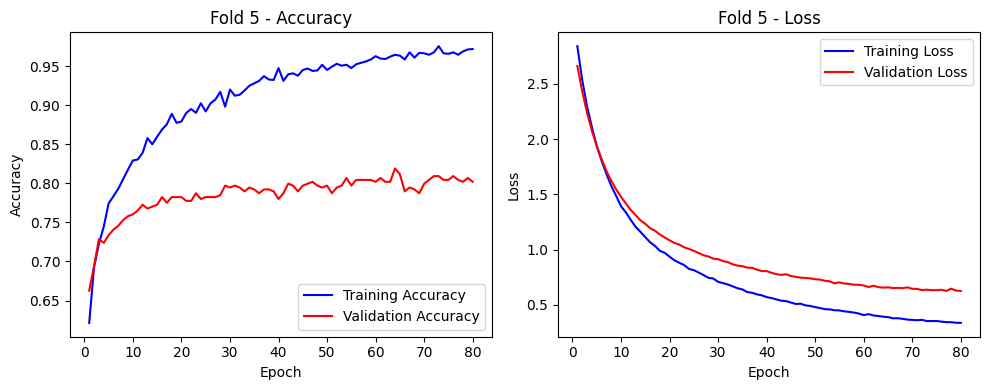

In [78]:
# Plotting DenseNet-121 tuned model
print(f"\nPlotting training history for Fold {fold + 1}...")
accuracy = history_fold_densenet.history['accuracy']
val_accuracy = history_fold_densenet.history['val_accuracy']
loss = history_fold_densenet.history['loss']
val_loss = history_fold_densenet.history['val_loss']

epochs_trained = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(epochs_trained, accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs_trained, val_accuracy, 'r', label='Validation Accuracy')
axes[0].set_title(f'Fold {fold+1} - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs_trained, loss, 'b', label='Training Loss')
axes[1].plot(epochs_trained, val_loss, 'r', label='Validation Loss')
axes[1].set_title(f'Fold {fold+1} - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [79]:
# Tuned Model Evaluation
test_loss, test_acc = tuned_densenet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 942ms/step - accuracy: 0.8064 - loss: 0.6608
Test Accuracy: 81.29%
Test Loss: 0.6252


In [80]:
#Classification Report - Tuned
test_generator.reset()
predictions = tuned_densenet_model.predict(test_generator, verbose=0)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nFold {fold + 1} Results:")
print(f"  Test Accuracy: {test_acc * 100:.2f}%")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

# Store results - MOVED INSIDE THE LOOP
densenet_fold_results.append({
    'fold': fold + 1,
    'accuracy': test_acc,
    'loss': test_loss,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'history': history_fold_densenet
})

print('Classification Report (Tuned):')
print(classification_report(y_true, y_pred_pre, target_names=['Clean', 'Dusty']))


Fold 5 Results:
  Test Accuracy: 81.29%
  Test Loss: 0.6252
  Precision: 0.4301
  Recall: 0.3738
  F1-Score: 0.4000
Classification Report (Tuned):
              precision    recall  f1-score   support

       Clean       0.60      0.65      0.62       299
       Dusty       0.45      0.40      0.42       214

    accuracy                           0.54       513
   macro avg       0.52      0.52      0.52       513
weighted avg       0.54      0.54      0.54       513



In [81]:
# STEP 5: Calculate final results
print("DENSENET-121 5-FOLD CROSS-VALIDATION RESULTS")

# Extract all metrics
accuracies = [result['accuracy'] for result in densenet_fold_results]
precisions = [result['precision'] for result in densenet_fold_results]
recalls = [result['recall'] for result in densenet_fold_results]
f1_scores = [result['f1_score'] for result in densenet_fold_results]

# Calculate means and standard deviations
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
mean_precision = np.mean(precisions)
std_precision = np.std(precisions)
mean_recall = np.mean(recalls)
std_recall = np.std(recalls)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

# Print results
print(f"\nMean Test Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")
print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")

print(f"\nDetailed Results by Fold:")
for i, result in enumerate(densenet_fold_results):
    print(f"Fold {i+1}: Acc={result['accuracy']*100:.1f}%, "
          f"Prec={result['precision']:.3f}, "
          f"Rec={result['recall']:.3f}, "
          f"F1={result['f1_score']:.3f}")


DENSENET-121 5-FOLD CROSS-VALIDATION RESULTS

Mean Test Accuracy: 81.29% ± 0.00%
Mean Precision: 0.4301 ± 0.0000
Mean Recall: 0.3738 ± 0.0000
Mean F1-Score: 0.4000 ± 0.0000

Detailed Results by Fold:
Fold 1: Acc=81.3%, Prec=0.430, Rec=0.374, F1=0.400



Plotting DenseNet-121 Cross-Validation Results...


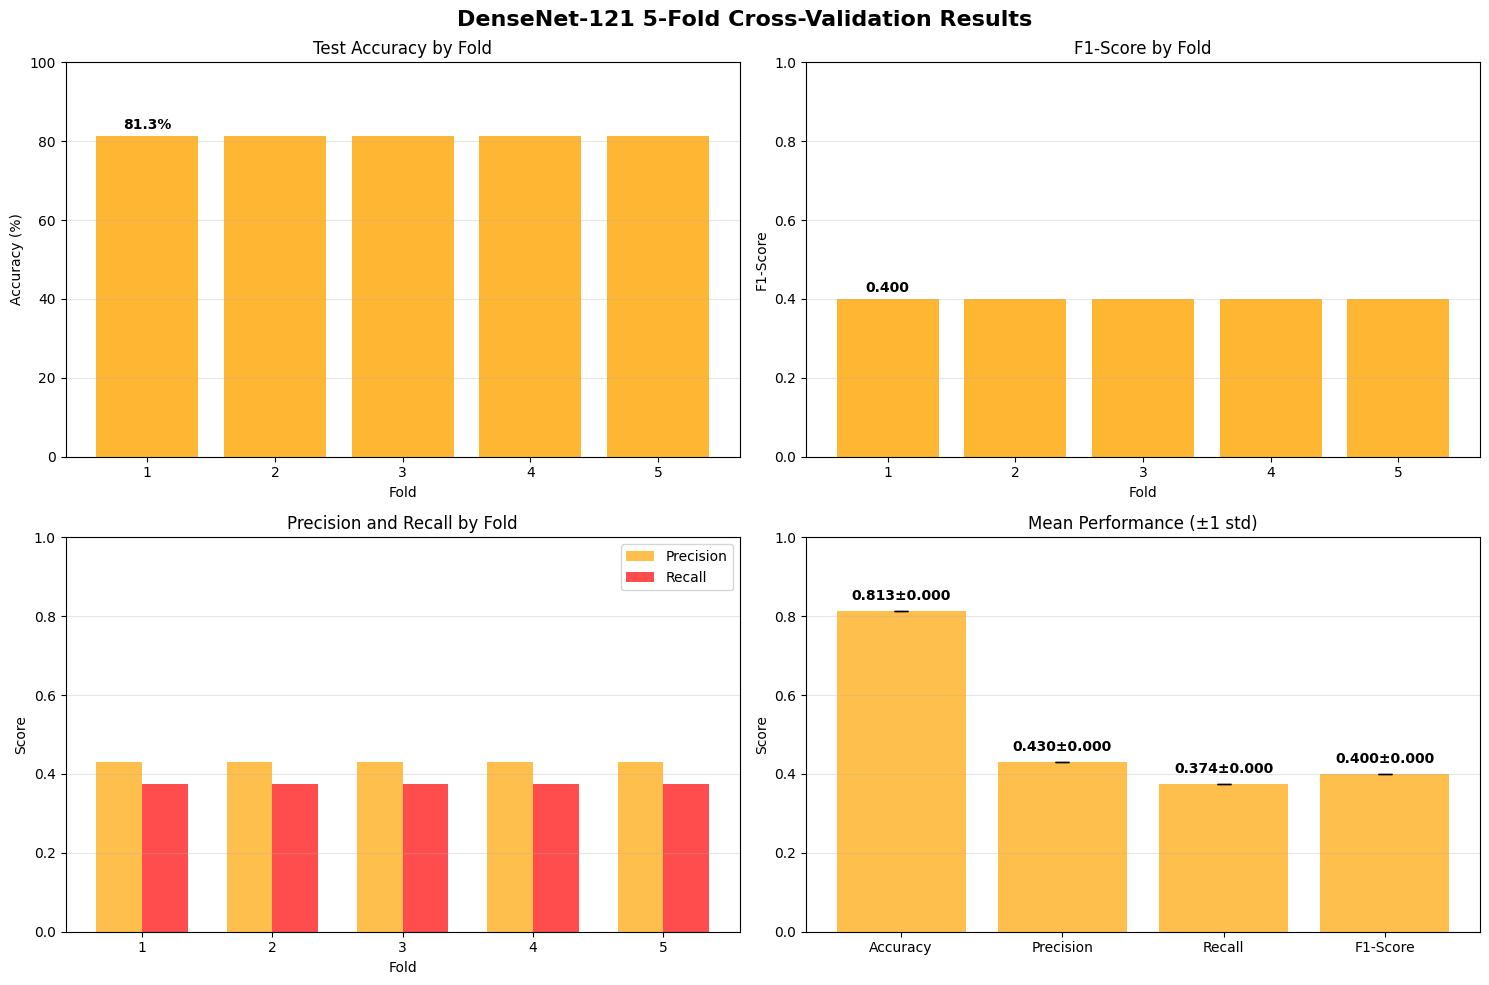

DenseNet-121 5-fold cross-validation completed successfully!


In [82]:
# STEP 6: Create comprehensive plots
print(f"\nPlotting DenseNet-121 Cross-Validation Results...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('DenseNet-121 5-Fold Cross-Validation Results', fontsize=16, fontweight='bold')

fold_numbers = list(range(1, 6))

# Plot 1: Accuracy by fold
bars1 = axes[0, 0].bar(fold_numbers, [acc * 100 for acc in accuracies], color='orange', alpha=0.8)
axes[0, 0].set_title('Test Accuracy by Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_ylim(0, 100)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{acc*100:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: F1-Score by fold
bars2 = axes[0, 1].bar(fold_numbers, f1_scores, color='orange', alpha=0.8)
axes[0, 1].set_title('F1-Score by Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, f1) in enumerate(zip(bars2, f1_scores)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Precision and Recall by fold
x = np.arange(len(fold_numbers))
width = 0.35

bars3 = axes[1, 0].bar(x - width/2, precisions, width, label='Precision', color='orange', alpha=0.7)
bars4 = axes[1, 0].bar(x + width/2, recalls, width, label='Recall', color='red', alpha=0.7)
axes[1, 0].set_title('Precision and Recall by Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(fold_numbers)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Summary statistics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
means = [mean_acc, mean_precision, mean_recall, mean_f1]
stds = [std_acc, std_precision, std_recall, std_f1]

bars5 = axes[1, 1].bar(metrics_names, means, yerr=stds, capsize=5, color='orange', alpha=0.7)
axes[1, 1].set_title('Mean Performance (±1 std)')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars5, means, stds)):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                   f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("DenseNet-121 5-fold cross-validation completed successfully!")


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 645ms/step

Final Classification Report (DenseNet-121):
              precision    recall  f1-score   support

       Clean       0.57      0.63      0.60       299
       Dusty       0.40      0.35      0.37       214

    accuracy                           0.51       513
   macro avg       0.48      0.49      0.48       513
weighted avg       0.50      0.51      0.50       513



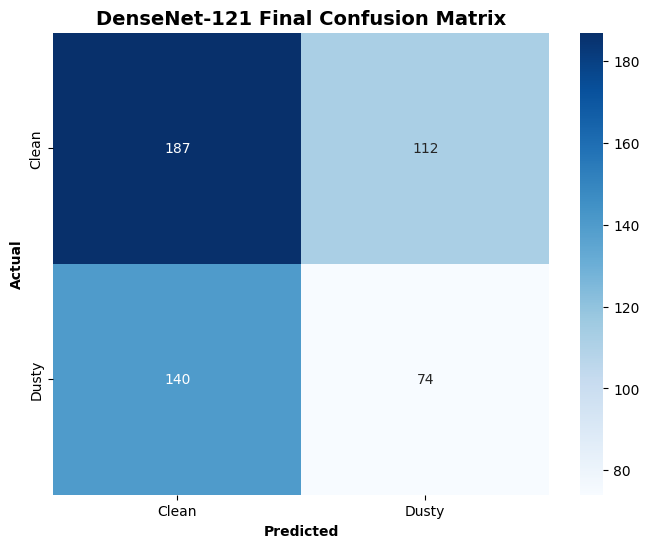

In [83]:
# Final confusion matrix on the last trained model
test_generator.reset()
final_predictions = tuned_densenet_model.predict(test_generator)
y_pred_final = (final_predictions > 0.5).astype(int).flatten()
y_true_final = test_generator.classes

print('\nFinal Classification Report (DenseNet-121):')
print(classification_report(y_true_final, y_pred_final, target_names=['Clean', 'Dusty']))

# Confusion Matrix
cm = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clean', 'Dusty'],
            yticklabels=['Clean', 'Dusty'])
plt.title('DenseNet-121 Final Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.show()

## 3rd Model: ResNet-50

### Pre-train ResNet-50

In [84]:
print("=== 3RD MODEL: ResNet50 ===")
print("\nBuilding ResNet50 Pre-trained Model...")

pre_resnet_model = Sequential([
      ResNet50(weights='imagenet',
              include_top=False,
              input_shape=(256, 256, 3)),
      GlobalAveragePooling2D(),
      Dense(128, activation='relu'),
      Dense(1, activation='sigmoid')
])

# Freeze the pre-trained model initially
pre_resnet_model.layers[0].trainable = False

pre_resnet_model.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

print("ResNet50 model has been built.\n")
pre_resnet_model.summary()

=== 3RD MODEL: ResNet50 ===

Building ResNet50 Pre-trained Model...
ResNet50 model has been built.



Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_32     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [85]:
# Train the pre-trained ResNet50 model
history_pre_resnet = pre_resnet_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    class_weight=calculated_class_weights_dict
)

Epoch 1/10
 9/65 ━━━━━━━━━━━━━━━━━━━━ 55s 996ms/step - accuracy: 0.4964 - loss: 0.8059

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.5245 - loss: 0.7300 - val_accuracy: 0.5478 - val_loss: 0.6832
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4993 - loss: 0.6913 - val_accuracy: 0.5341 - val_loss: 0.6830
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.5295 - loss: 0.6875 - val_accuracy: 0.5809 - val_loss: 0.6657
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.5540 - loss: 0.6947 - val_accuracy: 0.5595 - val_loss: 0.6700
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.5194 - loss: 0.6842 - val_accuracy: 0.5634 - val_loss: 0.6758
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.5617 - loss: 0.6792 - val_accuracy: 0.5595 - val_loss: 0.6825
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.5177 - loss: 0.6900 - val_accuracy: 0.5867 - val_loss: 0.6668
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.5359 - loss: 0.6828 - val_accuracy: 0.6062 - val_loss: 0.6642
Ep

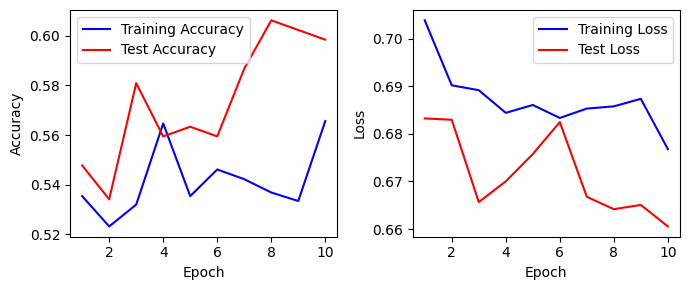

In [86]:
# Plotting ResNet50 pre-trained model
accuracy = history_pre_resnet.history['accuracy']
val_accuracy = history_pre_resnet.history['val_accuracy']
loss = history_pre_resnet.history['loss']
val_loss = history_pre_resnet.history['val_loss']

epochs = range(1, len(accuracy) + 1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
axes[0].plot(epochs, accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs, val_accuracy, 'r', label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label='Training Loss')
axes[1].plot(epochs, val_loss, 'r', label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [87]:
# Pre-trained ResNet50 Model Evaluation
resnet_test_loss, resnet_test_acc = pre_resnet_model.evaluate(test_generator)
print(f"Test Accuracy: {resnet_test_acc * 100:.2f}%")
print(f"Test Loss: {resnet_test_loss:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 657ms/step - accuracy: 0.6141 - loss: 0.6652
Test Accuracy: 59.84%
Test Loss: 0.6605


In [88]:
# Classification Report - ResNet50 Pre-trained
test_generator.reset()
predictions = pre_resnet_model.predict(test_generator)
print("PREDICTION DEBUGGING:")
print(f"Prediction range: {predictions.min():.3f} to {predictions.max():.3f}")
print(f"Predictions > 0.5: {np.sum(predictions > 0.5)}")
print(f"Predictions <= 0.5: {np.sum(predictions <= 0.5)}")
print(f"First 10 predictions: {predictions.flatten()[:10]}")

y_pred_resnet = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

precision = precision_score(y_true, y_pred_resnet)
recall = recall_score(y_true, y_pred_resnet)
f1 = f1_score(y_true, y_pred_resnet)

print('Classification Report (ResNet50 Pre-trained):')
print(classification_report(y_true, y_pred_resnet, target_names=['Clean', 'Dusty']))

17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 870ms/step
PREDICTION DEBUGGING:
Prediction range: 0.256 to 0.578
Predictions > 0.5: 124
Predictions <= 0.5: 389
First 10 predictions: [0.54859847 0.43194368 0.49733293 0.41384396 0.33184367 0.2710545
 0.40783912 0.5203139  0.47274688 0.4010124 ]
Classification Report (ResNet50 Pre-trained):
              precision    recall  f1-score   support

       Clean       0.57      0.74      0.65       299
       Dusty       0.38      0.22      0.28       214

    accuracy                           0.52       513
   macro avg       0.47      0.48      0.46       513
weighted avg       0.49      0.52      0.49       513



17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 659ms/step

Final Classification Report (DenseNet-121):
              precision    recall  f1-score   support

       Clean       0.59      0.76      0.66       299
       Dusty       0.43      0.25      0.31       214

    accuracy                           0.55       513
   macro avg       0.51      0.51      0.49       513
weighted avg       0.52      0.55      0.52       513



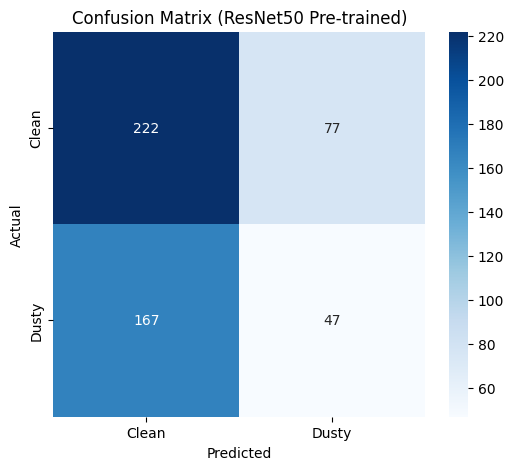

In [89]:
# Final confusion matrix on the pre-trained model
test_generator.reset()
final_predictions = pre_resnet_model.predict(test_generator)
y_pred_final = (final_predictions > 0.5).astype(int).flatten()
y_true_final = test_generator.classes

print('\nFinal Classification Report (DenseNet-121):')
print(classification_report(y_true_final, y_pred_final, target_names=['Clean', 'Dusty']))

cm_pre_resnet = confusion_matrix(y_true, y_pred_resnet)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_pre_resnet, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clean', 'Dusty'],
            yticklabels=['Clean', 'Dusty'])
plt.title('Confusion Matrix (ResNet50 Pre-trained)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Hyperparameter tuning

#### 1st tuned (dropout = 0.3)



In [90]:
print("=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===")

# STEP 1: Get all images and labels from train_generator
print("\nGetting all generator data for ResNet-50...")
train_generator.reset()
all_images = []
all_labels = []

for i in range(len(train_generator)):
    batch_x, batch_y = train_generator[i]
    all_images.append(batch_x)
    all_labels.extend(batch_y)

# Convert to numpy arrays
X_all = np.vstack(all_images)
y_all = np.array(all_labels)

print(f"Total training data: {X_all.shape}")
print(f"Clean samples: {np.sum(y_all == 0)}")
print(f"Dusty samples: {np.sum(y_all == 1)}")

# STEP 2: Setup 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\n5-fold cross-validation setup complete for ResNet-50")

# STEP 3: Store results for each fold
resnet_fold_results = []

# STEP 4: Loop through each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all)):
    print(f"\nTRAINING RESNET-50 FOLD {fold + 1}/5")

    # Split data for this fold
    X_train_fold = X_all[train_idx]
    y_train_fold = y_all[train_idx]
    X_val_fold = X_all[val_idx]
    y_val_fold = y_all[val_idx]

    print(f"\nTrain samples: {len(X_train_fold)}")
    print(f"Validation samples: {len(X_val_fold)}")

    # BUILD MODEL
    print(f"\nBuilding ResNet-50 Model for Fold {fold + 1}...")
    tuned_resnet_model = Sequential([
        ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(256, 256, 3)),
        GlobalAveragePooling2D(),
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dropout(0.3),
        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.3),
        Dense(1, activation='sigmoid',
              kernel_regularizer=regularizers.l2(0.01))
    ])

    # Setup Callbacks
    early_stopping = EarlyStopping(monitor='val_loss',
                                 patience=10,
                                 restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=5,
                                min_lr=0.0001)

    # Freeze the model initially
    tuned_resnet_model.layers[0].trainable = False

    tuned_resnet_model.compile(optimizer=Adam(learning_rate=0.0001),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

    print(f"\nResNet-50 model built for fold {fold + 1}\n")
    tuned_resnet_model.summary()

=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===

Getting all generator data for ResNet-50...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Total training data: (2049, 256, 256, 3)
Clean samples: 1194
Dusty samples: 855

5-fold cross-validation setup complete for ResNet-50

TRAINING RESNET-50 FOLD 1/5

Train samples: 1639
Validation samples: 410

Building ResNet-50 Model for Fold 1...

ResNet-50 model built for fold 1



Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_33     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)


TRAINING RESNET-50 FOLD 2/5

Train samples: 1639
Validation samples: 410

Building ResNet-50 Model for Fold 2...

ResNet-50 model built for fold 2



Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_34     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)


TRAINING RESNET-50 FOLD 3/5

Train samples: 1639
Validation samples: 410

Building ResNet-50 Model for Fold 3...

ResNet-50 model built for fold 3



Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_35     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)


TRAINING RESNET-50 FOLD 4/5

Train samples: 1639
Validation samples: 410

Building ResNet-50 Model for Fold 4...

ResNet-50 model built for fold 4



Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_36     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)


TRAINING RESNET-50 FOLD 5/5

Train samples: 1640
Validation samples: 409

Building ResNet-50 Model for Fold 5...

ResNet-50 model built for fold 5



Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_37     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [91]:
# TRAIN MODEL
print(f"Training Fold {fold + 1}...")

history_fold_resnet = tuned_resnet_model.fit(
    X_train_fold, y_train_fold,
    validation_data=(X_val_fold, y_val_fold),
    epochs=80,
    batch_size=32,
    class_weight = calculated_class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)


Training Fold 5...
Epoch 1/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.5003 - loss: 3.0834 - val_accuracy: 0.4181 - val_loss: 2.8657 - learning_rate: 1.0000e-04
Epoch 2/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5414 - loss: 2.6634 - val_accuracy: 0.4156 - val_loss: 2.4997 - learning_rate: 1.0000e-04
Epoch 3/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5458 - loss: 2.3596 - val_accuracy: 0.4425 - val_loss: 2.2089 - learning_rate: 1.0000e-04
Epoch 4/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5967 - loss: 2.1115 - val_accuracy: 0.4768 - val_loss: 1.9939 - learning_rate: 1.0000e-04
Epoch 5/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5470 - loss: 1.9372 - val_accuracy: 0.5257 - val_loss: 1.8205 - learning_rate: 1.0000e-04
Epoch 6/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5810 - loss: 1.7770 - val_accuracy: 0.5550 - val_loss: 1.6930 - learning_rate: 1.0000e-04
Epoch 7/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/ste


Plotting training history for Fold 5...


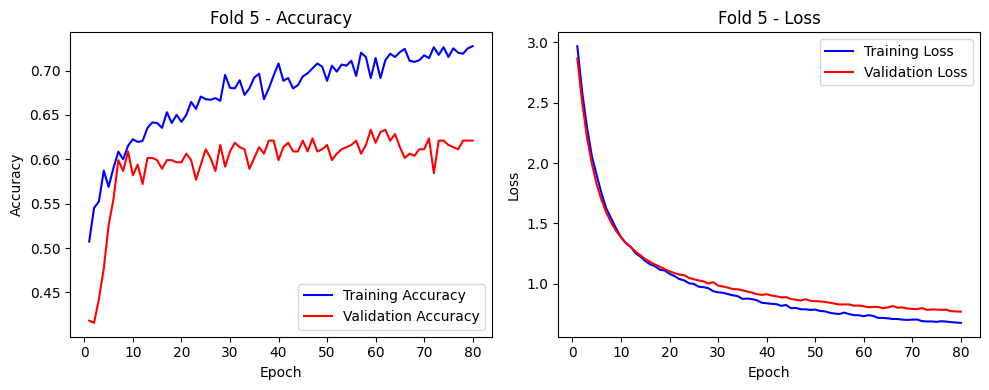

In [92]:
# Plotting ResNet-50 tuned model
print(f"\nPlotting training history for Fold {fold + 1}...")
accuracy = history_fold_resnet.history['accuracy']
val_accuracy = history_fold_resnet.history['val_accuracy']
loss = history_fold_resnet.history['loss']
val_loss = history_fold_resnet.history['val_loss']

epochs_trained = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(epochs_trained, accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs_trained, val_accuracy, 'r', label='Validation Accuracy')
axes[0].set_title(f'Fold {fold+1} - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs_trained, loss, 'b', label='Training Loss')
axes[1].plot(epochs_trained, val_loss, 'r', label='Validation Loss')
axes[1].set_title(f'Fold {fold+1} - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [93]:
# Tuned Model Evaluation
test_loss, test_acc = tuned_resnet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 744ms/step - accuracy: 0.6031 - loss: 0.7957
Test Accuracy: 61.01%
Test Loss: 0.8016


In [94]:
#Classification Report - Tuned
test_generator.reset()
predictions = tuned_resnet_model.predict(test_generator, verbose=0)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nFold {fold + 1} Results:")
print(f"  Test Accuracy: {test_acc * 100:.2f}%")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

# Store results - MOVED INSIDE THE LOOP
resnet_fold_results.append({
    'fold': fold + 1,
    'accuracy': test_acc,
    'loss': test_loss,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'history': history_fold_resnet
})

print('Classification Report (Tuned):')
print(classification_report(y_true, y_pred_pre, target_names=['Clean', 'Dusty']))


Fold 5 Results:
  Test Accuracy: 61.01%
  Test Loss: 0.8016
  Precision: 0.3849
  Recall: 0.4299
  F1-Score: 0.4062
Classification Report (Tuned):
              precision    recall  f1-score   support

       Clean       0.60      0.65      0.62       299
       Dusty       0.45      0.40      0.42       214

    accuracy                           0.54       513
   macro avg       0.52      0.52      0.52       513
weighted avg       0.54      0.54      0.54       513



In [95]:
# STEP 5: Calculate final results
print("RESNET-50 5-FOLD CROSS-VALIDATION RESULTS")

# Extract all metrics
accuracies = [result['accuracy'] for result in resnet_fold_results]
precisions = [result['precision'] for result in resnet_fold_results]
recalls = [result['recall'] for result in resnet_fold_results]
f1_scores = [result['f1_score'] for result in resnet_fold_results]

# Calculate means and standard deviations
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
mean_precision = np.mean(precisions)
std_precision = np.std(precisions)
mean_recall = np.mean(recalls)
std_recall = np.std(recalls)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

# Print results
print(f"\nMean Test Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")
print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")

print(f"\nDetailed Results by Fold:")
for i, result in enumerate(resnet_fold_results):
    print(f"Fold {i+1}: Acc={result['accuracy']*100:.1f}%, "
          f"Prec={result['precision']:.3f}, "
          f"Rec={result['recall']:.3f}, "
          f"F1={result['f1_score']:.3f}")


RESNET-50 5-FOLD CROSS-VALIDATION RESULTS

Mean Test Accuracy: 61.01% ± 0.00%
Mean Precision: 0.3849 ± 0.0000
Mean Recall: 0.4299 ± 0.0000
Mean F1-Score: 0.4062 ± 0.0000

Detailed Results by Fold:
Fold 1: Acc=61.0%, Prec=0.385, Rec=0.430, F1=0.406



Plotting ResNet-50 Cross-Validation Results...


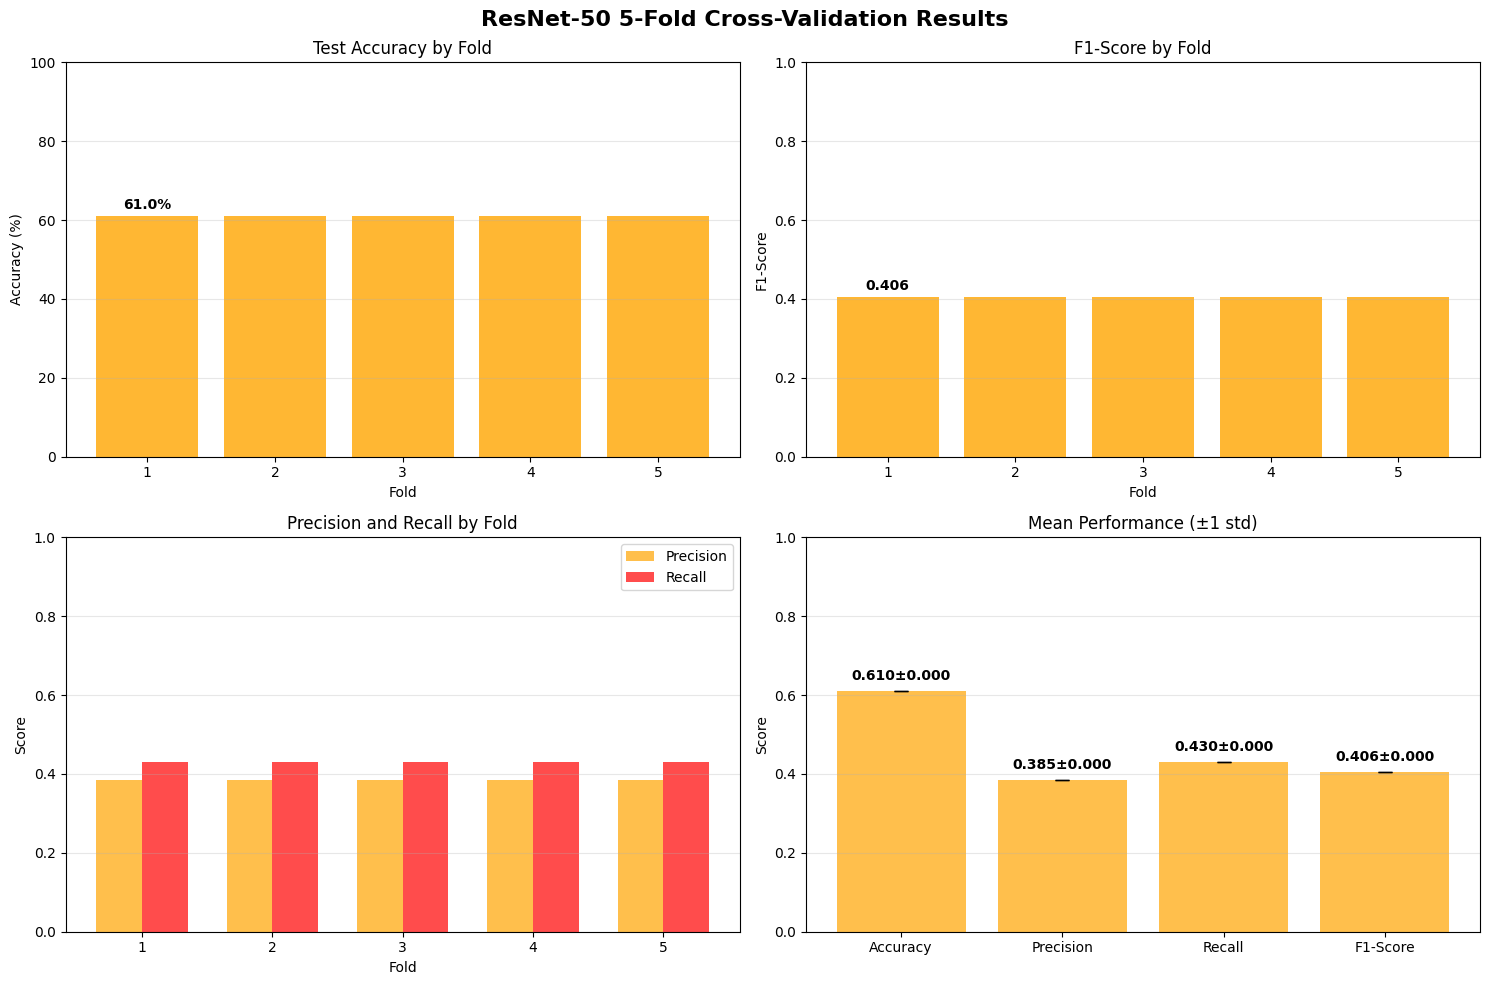

ResNet-50 5-fold cross-validation completed successfully!


In [96]:
# STEP 6: Create comprehensive plots
print(f"\nPlotting ResNet-50 Cross-Validation Results...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('ResNet-50 5-Fold Cross-Validation Results', fontsize=16, fontweight='bold')

fold_numbers = list(range(1, 6))

# Plot 1: Accuracy by fold
bars1 = axes[0, 0].bar(fold_numbers, [acc * 100 for acc in accuracies], color='orange', alpha=0.8)
axes[0, 0].set_title('Test Accuracy by Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_ylim(0, 100)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{acc*100:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: F1-Score by fold
bars2 = axes[0, 1].bar(fold_numbers, f1_scores, color='orange', alpha=0.8)
axes[0, 1].set_title('F1-Score by Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, f1) in enumerate(zip(bars2, f1_scores)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Precision and Recall by fold
x = np.arange(len(fold_numbers))
width = 0.35

bars3 = axes[1, 0].bar(x - width/2, precisions, width, label='Precision', color='orange', alpha=0.7)
bars4 = axes[1, 0].bar(x + width/2, recalls, width, label='Recall', color='red', alpha=0.7)
axes[1, 0].set_title('Precision and Recall by Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(fold_numbers)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Summary statistics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
means = [mean_acc, mean_precision, mean_recall, mean_f1]
stds = [std_acc, std_precision, std_recall, std_f1]

bars5 = axes[1, 1].bar(metrics_names, means, yerr=stds, capsize=5, color='orange', alpha=0.7)
axes[1, 1].set_title('Mean Performance (±1 std)')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars5, means, stds)):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                   f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("ResNet-50 5-fold cross-validation completed successfully!")


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 606ms/step

Final Classification Report (ResNet-50):
              precision    recall  f1-score   support

       Clean       0.57      0.52      0.55       299
       Dusty       0.40      0.45      0.43       214

    accuracy                           0.49       513
   macro avg       0.49      0.49      0.49       513
weighted avg       0.50      0.49      0.50       513



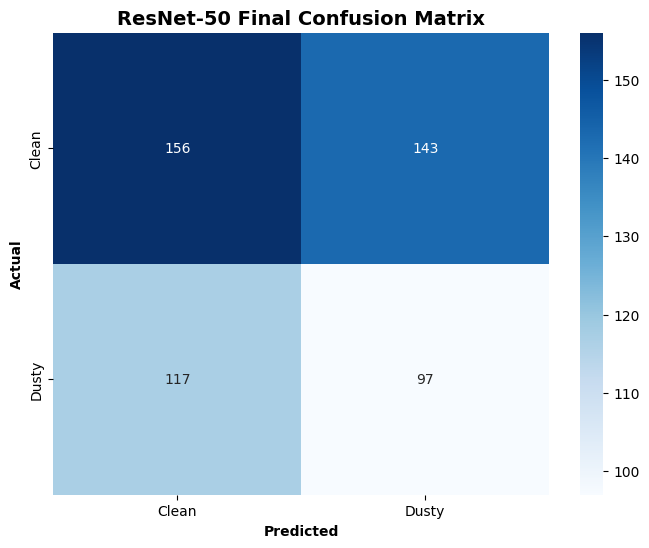

In [97]:
# Final confusion matrix on the last trained model
test_generator.reset()
final_predictions = tuned_resnet_model.predict(test_generator)
y_pred_final = (final_predictions > 0.5).astype(int).flatten()
y_true_final = test_generator.classes

print('\nFinal Classification Report (ResNet-50):')
print(classification_report(y_true_final, y_pred_final, target_names=['Clean', 'Dusty']))

# Confusion Matrix
cm = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clean', 'Dusty'],
            yticklabels=['Clean', 'Dusty'])
plt.title('ResNet-50 Final Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.show()

#### 2nd tuned (dropout = 0.2)


In [98]:
print("=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===")

# STEP 1: Get all images and labels from train_generator
print("\nGetting all generator data for ResNet-50...")
train_generator.reset()
all_images = []
all_labels = []

for i in range(len(train_generator)):
    batch_x, batch_y = train_generator[i]
    all_images.append(batch_x)
    all_labels.extend(batch_y)

# Convert to numpy arrays
X_all = np.vstack(all_images)
y_all = np.array(all_labels)

print(f"Total training data: {X_all.shape}")
print(f"Clean samples: {np.sum(y_all == 0)}")
print(f"Dusty samples: {np.sum(y_all == 1)}")

# STEP 2: Setup 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\n5-fold cross-validation setup complete for ResNet-50")

# STEP 3: Store results for each fold
resnet_fold_results = []

# STEP 4: Loop through each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all)):
    print(f"\nTRAINING RESNET-50 FOLD {fold + 1}/5")

    # Split data for this fold
    X_train_fold = X_all[train_idx]
    y_train_fold = y_all[train_idx]
    X_val_fold = X_all[val_idx]
    y_val_fold = y_all[val_idx]

    print(f"\nTrain samples: {len(X_train_fold)}")
    print(f"Validation samples: {len(X_val_fold)}")

    # BUILD MODEL
    print(f"\nBuilding ResNet-50 Model for Fold {fold + 1}...")
    tuned_resnet_model = Sequential([
        ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(256, 256, 3)),
        GlobalAveragePooling2D(),
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dropout(0.2),
        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.2),
        Dense(1, activation='sigmoid',
              kernel_regularizer=regularizers.l2(0.01))
    ])

    # Setup Callbacks
    early_stopping = EarlyStopping(monitor='val_loss',
                                 patience=10,
                                 restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=5,
                                min_lr=0.0001)

    # Freeze the model initially
    tuned_resnet_model.layers[0].trainable = False

    tuned_resnet_model.compile(optimizer=Adam(learning_rate=0.0001),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

    print(f"\nResNet-50 model built for fold {fold + 1}\n")
    tuned_resnet_model.summary()

=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===

Getting all generator data for ResNet-50...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Total training data: (2049, 256, 256, 3)
Clean samples: 1194
Dusty samples: 855

5-fold cross-validation setup complete for ResNet-50

TRAINING RESNET-50 FOLD 1/5

Train samples: 1639
Validation samples: 410

Building ResNet-50 Model for Fold 1...

ResNet-50 model built for fold 1



Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_38     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)


TRAINING RESNET-50 FOLD 2/5

Train samples: 1639
Validation samples: 410

Building ResNet-50 Model for Fold 2...

ResNet-50 model built for fold 2



Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_39     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)


TRAINING RESNET-50 FOLD 3/5

Train samples: 1639
Validation samples: 410

Building ResNet-50 Model for Fold 3...

ResNet-50 model built for fold 3



Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_40     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)


TRAINING RESNET-50 FOLD 4/5

Train samples: 1639
Validation samples: 410

Building ResNet-50 Model for Fold 4...

ResNet-50 model built for fold 4



Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_41     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)


TRAINING RESNET-50 FOLD 5/5

Train samples: 1640
Validation samples: 409

Building ResNet-50 Model for Fold 5...

ResNet-50 model built for fold 5



Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_42     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [99]:
# TRAIN MODEL
print(f"Training Fold {fold + 1}...")

history_fold_resnet = tuned_resnet_model.fit(
    X_train_fold, y_train_fold,
    validation_data=(X_val_fold, y_val_fold),
    epochs=80,
    batch_size=32,
    class_weight = calculated_class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)


Training Fold 5...
Epoch 1/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 216ms/step - accuracy: 0.4724 - loss: 3.0853 - val_accuracy: 0.4156 - val_loss: 2.8409 - learning_rate: 1.0000e-04
Epoch 2/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5674 - loss: 2.6219 - val_accuracy: 0.4303 - val_loss: 2.4543 - learning_rate: 1.0000e-04
Epoch 3/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5811 - loss: 2.3105 - val_accuracy: 0.4474 - val_loss: 2.1563 - learning_rate: 1.0000e-04
Epoch 4/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6092 - loss: 2.0580 - val_accuracy: 0.5721 - val_loss: 1.9372 - learning_rate: 1.0000e-04
Epoch 5/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6268 - loss: 1.8586 - val_accuracy: 0.5990 - val_loss: 1.7727 - learning_rate: 1.0000e-04
Epoch 6/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6163 - loss: 1.7099 - val_accuracy: 0.6284 - val_loss: 1.6431 - learning_rate: 1.0000e-04
Epoch 7/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/ste


Plotting training history for Fold 5...


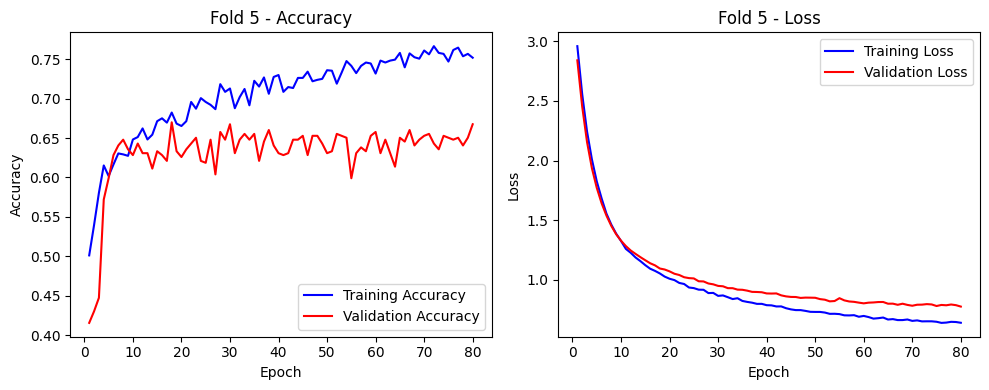

In [100]:
# Plotting ResNet-50 tuned model
print(f"\nPlotting training history for Fold {fold + 1}...")
accuracy = history_fold_resnet.history['accuracy']
val_accuracy = history_fold_resnet.history['val_accuracy']
loss = history_fold_resnet.history['loss']
val_loss = history_fold_resnet.history['val_loss']

epochs_trained = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(epochs_trained, accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs_trained, val_accuracy, 'r', label='Validation Accuracy')
axes[0].set_title(f'Fold {fold+1} - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs_trained, loss, 'b', label='Training Loss')
axes[1].plot(epochs_trained, val_loss, 'r', label='Validation Loss')
axes[1].set_title(f'Fold {fold+1} - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [101]:
# Tuned Model Evaluation
test_loss, test_acc = tuned_resnet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 729ms/step - accuracy: 0.6414 - loss: 0.7946
Test Accuracy: 64.72%
Test Loss: 0.7878


In [102]:
#Classification Report - Tuned
test_generator.reset()
predictions = tuned_resnet_model.predict(test_generator, verbose=0)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nFold {fold + 1} Results:")
print(f"  Test Accuracy: {test_acc * 100:.2f}%")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

# Store results - MOVED INSIDE THE LOOP
resnet_fold_results.append({
    'fold': fold + 1,
    'accuracy': test_acc,
    'loss': test_loss,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'history': history_fold_resnet
})

print('Classification Report (Tuned):')
print(classification_report(y_true, y_pred_pre, target_names=['Clean', 'Dusty']))


Fold 5 Results:
  Test Accuracy: 64.72%
  Test Loss: 0.7878
  Precision: 0.3812
  Recall: 0.3972
  F1-Score: 0.3890
Classification Report (Tuned):
              precision    recall  f1-score   support

       Clean       0.60      0.65      0.62       299
       Dusty       0.45      0.40      0.42       214

    accuracy                           0.54       513
   macro avg       0.52      0.52      0.52       513
weighted avg       0.54      0.54      0.54       513



In [103]:
# STEP 5: Calculate final results
print("RESNET-50 5-FOLD CROSS-VALIDATION RESULTS")

# Extract all metrics
accuracies = [result['accuracy'] for result in resnet_fold_results]
precisions = [result['precision'] for result in resnet_fold_results]
recalls = [result['recall'] for result in resnet_fold_results]
f1_scores = [result['f1_score'] for result in resnet_fold_results]

# Calculate means and standard deviations
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
mean_precision = np.mean(precisions)
std_precision = np.std(precisions)
mean_recall = np.mean(recalls)
std_recall = np.std(recalls)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

# Print results
print(f"\nMean Test Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")
print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")

print(f"\nDetailed Results by Fold:")
for i, result in enumerate(resnet_fold_results):
    print(f"Fold {i+1}: Acc={result['accuracy']*100:.1f}%, "
          f"Prec={result['precision']:.3f}, "
          f"Rec={result['recall']:.3f}, "
          f"F1={result['f1_score']:.3f}")


RESNET-50 5-FOLD CROSS-VALIDATION RESULTS

Mean Test Accuracy: 64.72% ± 0.00%
Mean Precision: 0.3812 ± 0.0000
Mean Recall: 0.3972 ± 0.0000
Mean F1-Score: 0.3890 ± 0.0000

Detailed Results by Fold:
Fold 1: Acc=64.7%, Prec=0.381, Rec=0.397, F1=0.389



Plotting ResNet-50 Cross-Validation Results...


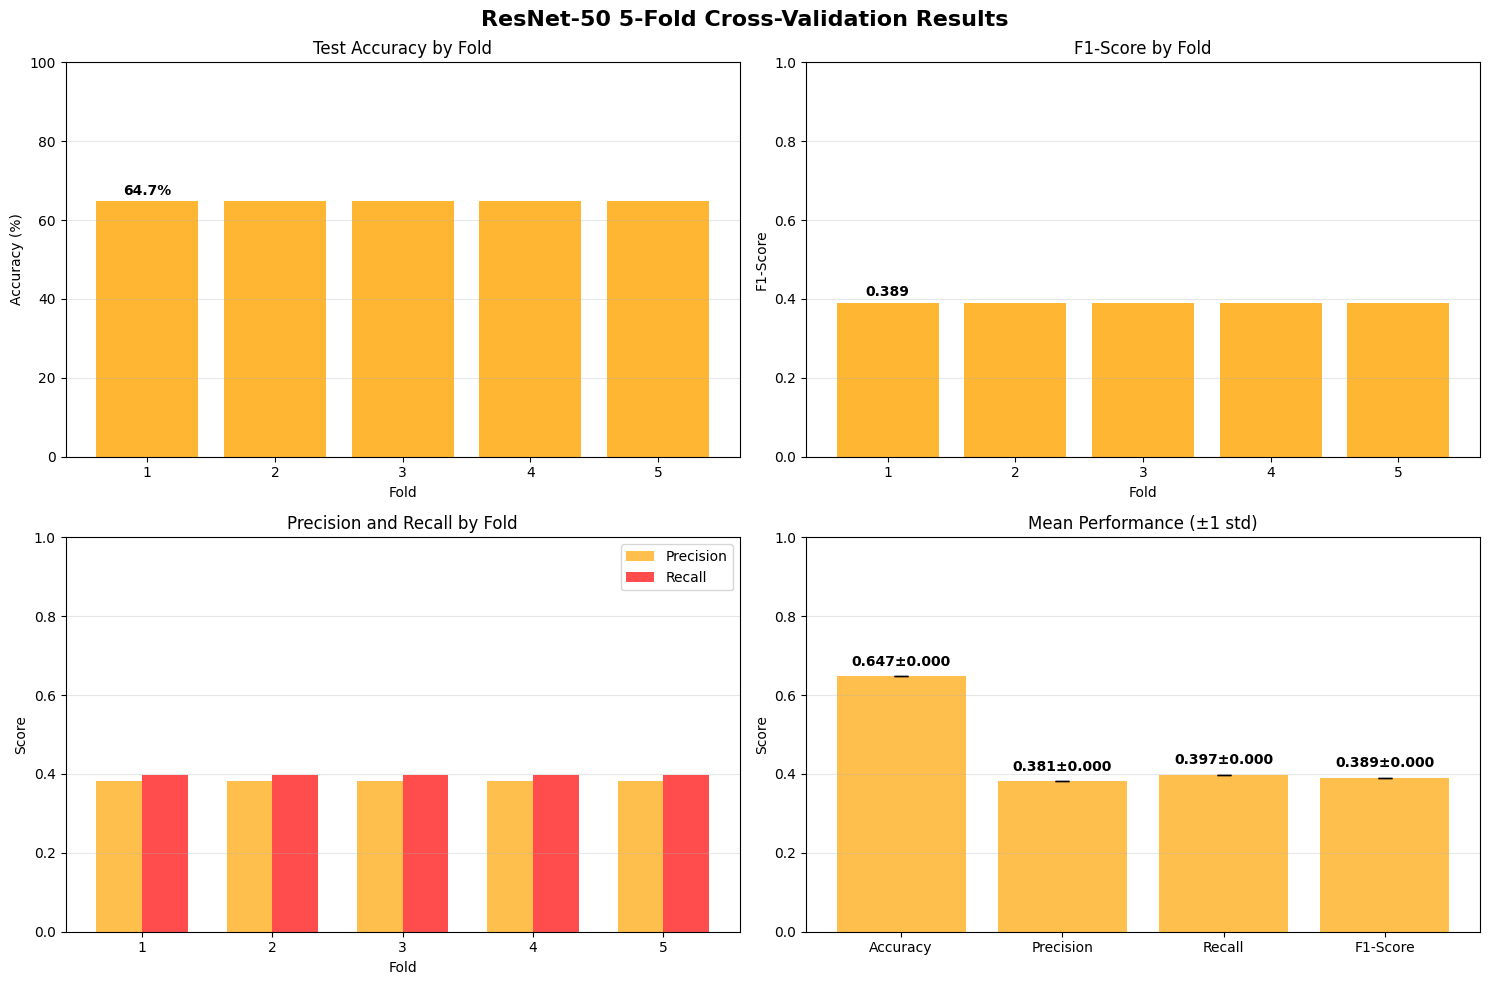

ResNet-50 5-fold cross-validation completed successfully!


In [104]:
# STEP 6: Create comprehensive plots
print(f"\nPlotting ResNet-50 Cross-Validation Results...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('ResNet-50 5-Fold Cross-Validation Results', fontsize=16, fontweight='bold')

fold_numbers = list(range(1, 6))

# Plot 1: Accuracy by fold
bars1 = axes[0, 0].bar(fold_numbers, [acc * 100 for acc in accuracies], color='orange', alpha=0.8)
axes[0, 0].set_title('Test Accuracy by Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_ylim(0, 100)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{acc*100:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: F1-Score by fold
bars2 = axes[0, 1].bar(fold_numbers, f1_scores, color='orange', alpha=0.8)
axes[0, 1].set_title('F1-Score by Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, f1) in enumerate(zip(bars2, f1_scores)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Precision and Recall by fold
x = np.arange(len(fold_numbers))
width = 0.35

bars3 = axes[1, 0].bar(x - width/2, precisions, width, label='Precision', color='orange', alpha=0.7)
bars4 = axes[1, 0].bar(x + width/2, recalls, width, label='Recall', color='red', alpha=0.7)
axes[1, 0].set_title('Precision and Recall by Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(fold_numbers)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Summary statistics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
means = [mean_acc, mean_precision, mean_recall, mean_f1]
stds = [std_acc, std_precision, std_recall, std_f1]

bars5 = axes[1, 1].bar(metrics_names, means, yerr=stds, capsize=5, color='orange', alpha=0.7)
axes[1, 1].set_title('Mean Performance (±1 std)')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars5, means, stds)):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                   f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("ResNet-50 5-fold cross-validation completed successfully!")


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 631ms/step

Final Classification Report (ResNet-50):
              precision    recall  f1-score   support

       Clean       0.56      0.54      0.55       299
       Dusty       0.38      0.40      0.39       214

    accuracy                           0.48       513
   macro avg       0.47      0.47      0.47       513
weighted avg       0.48      0.48      0.48       513



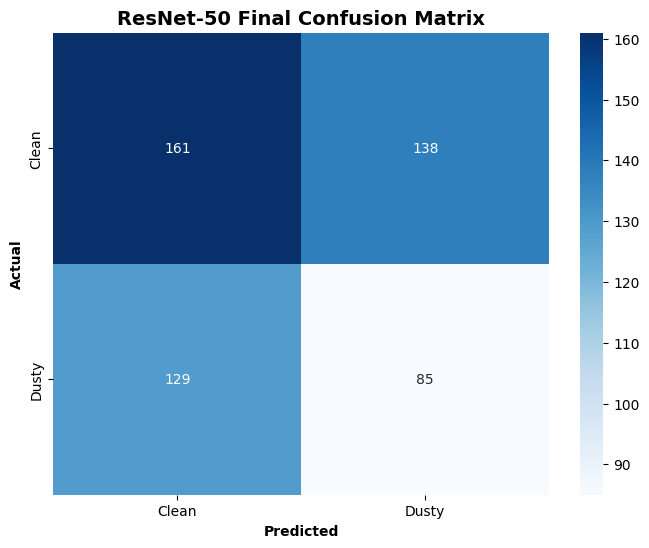

In [105]:
# Final confusion matrix on the last trained model
test_generator.reset()
final_predictions = tuned_resnet_model.predict(test_generator)
y_pred_final = (final_predictions > 0.5).astype(int).flatten()
y_true_final = test_generator.classes

print('\nFinal Classification Report (ResNet-50):')
print(classification_report(y_true_final, y_pred_final, target_names=['Clean', 'Dusty']))

# Confusion Matrix
cm = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clean', 'Dusty'],
            yticklabels=['Clean', 'Dusty'])
plt.title('ResNet-50 Final Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.show()

#### 3nd Tuned (dropout = 0.1)

In [106]:
print("=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===")

# STEP 1: Get all images and labels from train_generator
print("\nGetting all generator data for ResNet-50...")
train_generator.reset()
all_images = []
all_labels = []

for i in range(len(train_generator)):
    batch_x, batch_y = train_generator[i]
    all_images.append(batch_x)
    all_labels.extend(batch_y)

# Convert to numpy arrays
X_all = np.vstack(all_images)
y_all = np.array(all_labels)

print(f"Total training data: {X_all.shape}")
print(f"Clean samples: {np.sum(y_all == 0)}")
print(f"Dusty samples: {np.sum(y_all == 1)}")

# STEP 2: Setup 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\n5-fold cross-validation setup complete for ResNet-50")

# STEP 3: Store results for each fold
resnet_fold_results = []

# STEP 4: Loop through each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all)):
    print(f"\nTRAINING RESNET-50 FOLD {fold + 1}/5")

    # Split data for this fold
    X_train_fold = X_all[train_idx]
    y_train_fold = y_all[train_idx]
    X_val_fold = X_all[val_idx]
    y_val_fold = y_all[val_idx]

    print(f"\nTrain samples: {len(X_train_fold)}")
    print(f"Validation samples: {len(X_val_fold)}")

    # BUILD MODEL
    print(f"\nBuilding ResNet-50 Model for Fold {fold + 1}...")
    tuned_resnet_model = Sequential([
        ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(256, 256, 3)),
        GlobalAveragePooling2D(),
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dropout(0.1),
        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.1),
        Dense(1, activation='sigmoid',
              kernel_regularizer=regularizers.l2(0.01))
    ])

    # Setup Callbacks
    early_stopping = EarlyStopping(monitor='val_loss',
                                 patience=10,
                                 restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=5,
                                min_lr=0.0001)

    # Freeze the model initially
    tuned_resnet_model.layers[0].trainable = False

    tuned_resnet_model.compile(optimizer=Adam(learning_rate=0.0001),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

    print(f"\nResNet-50 model built for fold {fold + 1}\n")
    tuned_resnet_model.summary()

=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===

Getting all generator data for ResNet-50...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Total training data: (2049, 256, 256, 3)
Clean samples: 1194
Dusty samples: 855

5-fold cross-validation setup complete for ResNet-50

TRAINING RESNET-50 FOLD 1/5

Train samples: 1639
Validation samples: 410

Building ResNet-50 Model for Fold 1...

ResNet-50 model built for fold 1



Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_43     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)


TRAINING RESNET-50 FOLD 2/5

Train samples: 1639
Validation samples: 410

Building ResNet-50 Model for Fold 2...

ResNet-50 model built for fold 2



Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_44     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)


TRAINING RESNET-50 FOLD 3/5

Train samples: 1639
Validation samples: 410

Building ResNet-50 Model for Fold 3...

ResNet-50 model built for fold 3



Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_45     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)


TRAINING RESNET-50 FOLD 4/5

Train samples: 1639
Validation samples: 410

Building ResNet-50 Model for Fold 4...

ResNet-50 model built for fold 4



Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_46     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)


TRAINING RESNET-50 FOLD 5/5

Train samples: 1640
Validation samples: 409

Building ResNet-50 Model for Fold 5...

ResNet-50 model built for fold 5



Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_47     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [107]:
# TRAIN MODEL
print(f"Training Fold {fold + 1}...")

history_fold_resnet = tuned_resnet_model.fit(
    X_train_fold, y_train_fold,
    validation_data=(X_val_fold, y_val_fold),
    epochs=80,
    batch_size=32,
    class_weight = calculated_class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)


Training Fold 5...
Epoch 1/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 218ms/step - accuracy: 0.5277 - loss: 3.0362 - val_accuracy: 0.4205 - val_loss: 2.7588 - learning_rate: 1.0000e-04
Epoch 2/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5755 - loss: 2.6008 - val_accuracy: 0.4572 - val_loss: 2.4206 - learning_rate: 1.0000e-04
Epoch 3/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6254 - loss: 2.2653 - val_accuracy: 0.4645 - val_loss: 2.1437 - learning_rate: 1.0000e-04
Epoch 4/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6269 - loss: 2.0230 - val_accuracy: 0.5330 - val_loss: 1.9221 - learning_rate: 1.0000e-04
Epoch 5/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6451 - loss: 1.8220 - val_accuracy: 0.5526 - val_loss: 1.7548 - learning_rate: 1.0000e-04
Epoch 6/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6317 - loss: 1.6558 - val_accuracy: 0.5355 - val_loss: 1.6230 - learning_rate: 1.0000e-04
Epoch 7/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/ste


Plotting training history for Fold 5...


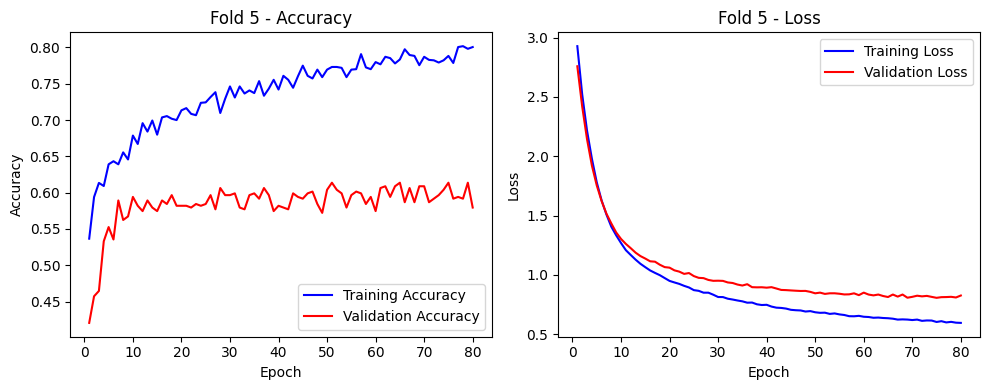

In [108]:
# Plotting ResNet-50 tuned model
print(f"\nPlotting training history for Fold {fold + 1}...")
accuracy = history_fold_resnet.history['accuracy']
val_accuracy = history_fold_resnet.history['val_accuracy']
loss = history_fold_resnet.history['loss']
val_loss = history_fold_resnet.history['val_loss']

epochs_trained = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(epochs_trained, accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs_trained, val_accuracy, 'r', label='Validation Accuracy')
axes[0].set_title(f'Fold {fold+1} - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs_trained, loss, 'b', label='Training Loss')
axes[1].plot(epochs_trained, val_loss, 'r', label='Validation Loss')
axes[1].set_title(f'Fold {fold+1} - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [109]:
# Tuned Model Evaluation
test_loss, test_acc = tuned_resnet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 738ms/step - accuracy: 0.6439 - loss: 0.7762
Test Accuracy: 63.55%
Test Loss: 0.7773


In [110]:
#Classification Report - Tuned
test_generator.reset()
predictions = tuned_resnet_model.predict(test_generator, verbose=0)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nFold {fold + 1} Results:")
print(f"  Test Accuracy: {test_acc * 100:.2f}%")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

# Store results - MOVED INSIDE THE LOOP
resnet_fold_results.append({
    'fold': fold + 1,
    'accuracy': test_acc,
    'loss': test_loss,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'history': history_fold_resnet
})

print('Classification Report (Tuned):')
print(classification_report(y_true, y_pred_pre, target_names=['Clean', 'Dusty']))


Fold 5 Results:
  Test Accuracy: 63.55%
  Test Loss: 0.7773
  Precision: 0.3953
  Recall: 0.3972
  F1-Score: 0.3963
Classification Report (Tuned):
              precision    recall  f1-score   support

       Clean       0.60      0.65      0.62       299
       Dusty       0.45      0.40      0.42       214

    accuracy                           0.54       513
   macro avg       0.52      0.52      0.52       513
weighted avg       0.54      0.54      0.54       513



In [111]:
# STEP 5: Calculate final results
print("RESNET-50 5-FOLD CROSS-VALIDATION RESULTS")

# Extract all metrics
accuracies = [result['accuracy'] for result in resnet_fold_results]
precisions = [result['precision'] for result in resnet_fold_results]
recalls = [result['recall'] for result in resnet_fold_results]
f1_scores = [result['f1_score'] for result in resnet_fold_results]

# Calculate means and standard deviations
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
mean_precision = np.mean(precisions)
std_precision = np.std(precisions)
mean_recall = np.mean(recalls)
std_recall = np.std(recalls)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

# Print results
print(f"\nMean Test Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")
print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")

print(f"\nDetailed Results by Fold:")
for i, result in enumerate(resnet_fold_results):
    print(f"Fold {i+1}: Acc={result['accuracy']*100:.1f}%, "
          f"Prec={result['precision']:.3f}, "
          f"Rec={result['recall']:.3f}, "
          f"F1={result['f1_score']:.3f}")


RESNET-50 5-FOLD CROSS-VALIDATION RESULTS

Mean Test Accuracy: 63.55% ± 0.00%
Mean Precision: 0.3953 ± 0.0000
Mean Recall: 0.3972 ± 0.0000
Mean F1-Score: 0.3963 ± 0.0000

Detailed Results by Fold:
Fold 1: Acc=63.5%, Prec=0.395, Rec=0.397, F1=0.396



Plotting ResNet-50 Cross-Validation Results...


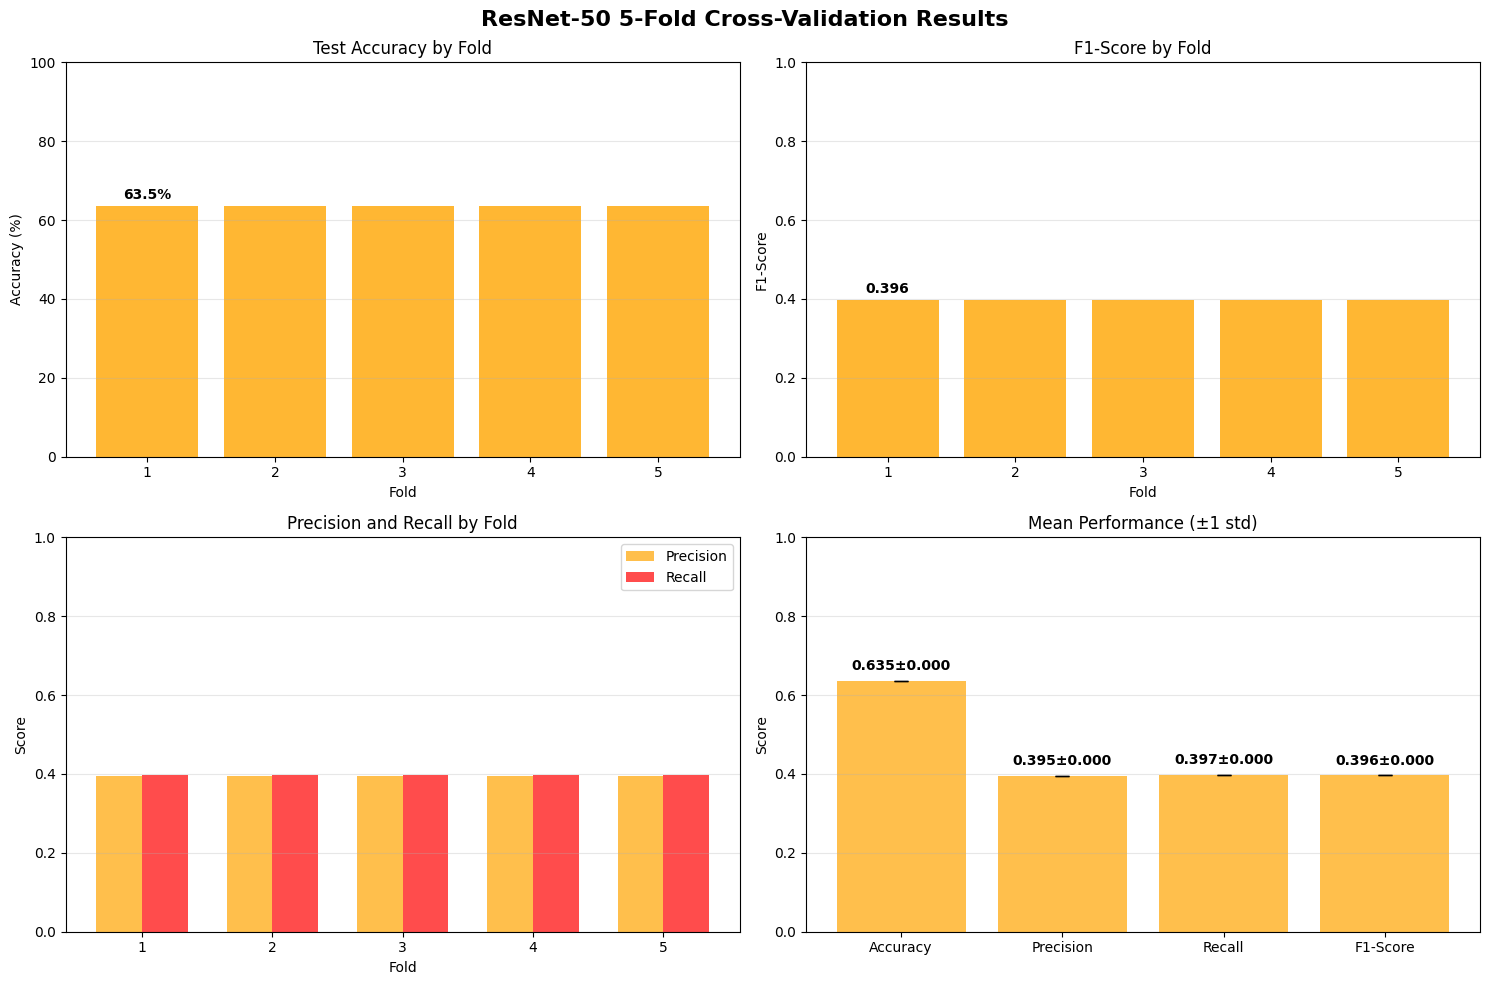

ResNet-50 5-fold cross-validation completed successfully!


In [112]:
# STEP 6: Create comprehensive plots
print(f"\nPlotting ResNet-50 Cross-Validation Results...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('ResNet-50 5-Fold Cross-Validation Results', fontsize=16, fontweight='bold')

fold_numbers = list(range(1, 6))

# Plot 1: Accuracy by fold
bars1 = axes[0, 0].bar(fold_numbers, [acc * 100 for acc in accuracies], color='orange', alpha=0.8)
axes[0, 0].set_title('Test Accuracy by Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_ylim(0, 100)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{acc*100:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: F1-Score by fold
bars2 = axes[0, 1].bar(fold_numbers, f1_scores, color='orange', alpha=0.8)
axes[0, 1].set_title('F1-Score by Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, f1) in enumerate(zip(bars2, f1_scores)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Precision and Recall by fold
x = np.arange(len(fold_numbers))
width = 0.35

bars3 = axes[1, 0].bar(x - width/2, precisions, width, label='Precision', color='orange', alpha=0.7)
bars4 = axes[1, 0].bar(x + width/2, recalls, width, label='Recall', color='red', alpha=0.7)
axes[1, 0].set_title('Precision and Recall by Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(fold_numbers)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Summary statistics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
means = [mean_acc, mean_precision, mean_recall, mean_f1]
stds = [std_acc, std_precision, std_recall, std_f1]

bars5 = axes[1, 1].bar(metrics_names, means, yerr=stds, capsize=5, color='orange', alpha=0.7)
axes[1, 1].set_title('Mean Performance (±1 std)')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars5, means, stds)):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                   f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("ResNet-50 5-fold cross-validation completed successfully!")


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 642ms/step

Final Classification Report (ResNet-50):
              precision    recall  f1-score   support

       Clean       0.58      0.58      0.58       299
       Dusty       0.41      0.41      0.41       214

    accuracy                           0.51       513
   macro avg       0.49      0.49      0.49       513
weighted avg       0.51      0.51      0.51       513



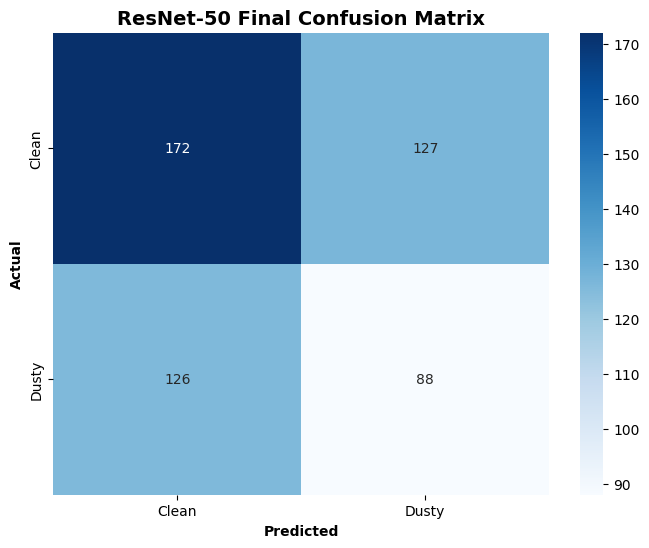

In [113]:
# Final confusion matrix on the last trained model
test_generator.reset()
final_predictions = tuned_resnet_model.predict(test_generator)
y_pred_final = (final_predictions > 0.5).astype(int).flatten()
y_true_final = test_generator.classes

print('\nFinal Classification Report (ResNet-50):')
print(classification_report(y_true_final, y_pred_final, target_names=['Clean', 'Dusty']))

# Confusion Matrix
cm = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clean', 'Dusty'],
            yticklabels=['Clean', 'Dusty'])
plt.title('ResNet-50 Final Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.show()

## 4th Model: MobileNetV2




### pre-train MobileNetV2

In [114]:
print("\n=== 4TH MODEL: MobileNetV2 ===")
print("\nBuilding MobileNetV2 Pre-trained Model...")

pre_mobile_model = Sequential([
    MobileNetV2(weights='imagenet',
                include_top=False,
                input_shape=(256, 256, 3)),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Freeze the pre-trained model initially
pre_mobile_model.layers[0].trainable = False

pre_mobile_model.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

print("MobileNetV2 model has been built.\n")
pre_mobile_model.summary()


=== 4TH MODEL: MobileNetV2 ===

Building MobileNetV2 Pre-trained Model...


<ipython-input-114-665cb20fe8e2>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNetV2(weights='imagenet',


MobileNetV2 model has been built.



Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_48     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [115]:
# Train the pre-trained MobileNetV2 model
history_pre_mobile = pre_mobile_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    class_weight=calculated_class_weights_dict
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.6032 - loss: 0.7102 - val_accuracy: 0.7115 - val_loss: 0.5636
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7194 - loss: 0.5512 - val_accuracy: 0.7485 - val_loss: 0.5083
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.7712 - loss: 0.4905 - val_accuracy: 0.7739 - val_loss: 0.4862
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8062 - loss: 0.4423 - val_accuracy: 0.7466 - val_loss: 0.4857
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8109 - loss: 0.4369 - val_accuracy: 0.7778 - val_loss: 0.4703
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7921 - loss: 0.4515 - val_accuracy: 0.7739 - val_loss: 0.4651
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8086 - loss: 0.4158 - val_accuracy: 0.7583 - val_loss: 0.4865
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8102 - loss: 0.4227 - val_accuracy: 0.7797 - val_loss: 0.4583
Ep

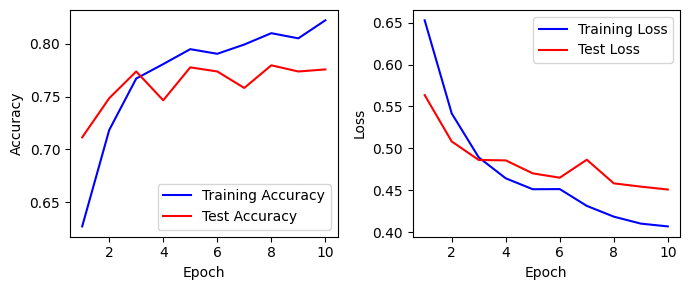

In [116]:
# Plotting MobileNetV2 pre-trained model
accuracy = history_pre_mobile.history['accuracy']
val_accuracy = history_pre_mobile.history['val_accuracy']
loss = history_pre_mobile.history['loss']
val_loss = history_pre_mobile.history['val_loss']

epochs = range(1, len(accuracy) + 1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
axes[0].plot(epochs, accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs, val_accuracy, 'r', label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label='Training Loss')
axes[1].plot(epochs, val_loss, 'r', label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()


In [117]:
# Pre-trained MobileNetV2 Model Evaluation
mobile_test_loss, mobile_test_acc = pre_mobile_model.evaluate(test_generator)
print(f"Test Accuracy: {mobile_test_acc * 100:.2f}%")
print(f"Test Loss: {mobile_test_loss:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 643ms/step - accuracy: 0.7510 - loss: 0.4970
Test Accuracy: 77.58%
Test Loss: 0.4510


In [118]:
# Classification Report - MobileNetV2 Pre-trained
test_generator.reset()
predictions = pre_mobile_model.predict(test_generator)
print("PREDICTION DEBUGGING:")
print(f"Prediction range: {predictions.min():.3f} to {predictions.max():.3f}")
print(f"Predictions > 0.5: {np.sum(predictions > 0.5)}")
print(f"Predictions <= 0.5: {np.sum(predictions <= 0.5)}")
print(f"First 10 predictions: {predictions.flatten()[:10]}")

y_pred_mobile = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

precision = precision_score(y_true, y_pred_mobile)
recall = recall_score(y_true, y_pred_mobile)
f1 = f1_score(y_true, y_pred_mobile)

print('Classification Report (MobileNetV2 Pre-trained):')
print(classification_report(y_true, y_pred_mobile, target_names=['Clean', 'Dusty']))

17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 805ms/step
PREDICTION DEBUGGING:
Prediction range: 0.001 to 0.998
Predictions > 0.5: 181
Predictions <= 0.5: 332
First 10 predictions: [0.94663554 0.1971224  0.13330914 0.44180778 0.7615223  0.03485622
 0.90284544 0.91937155 0.887867   0.1381514 ]
Classification Report (MobileNetV2 Pre-trained):
              precision    recall  f1-score   support

       Clean       0.59      0.66      0.62       299
       Dusty       0.44      0.37      0.40       214

    accuracy                           0.54       513
   macro avg       0.51      0.51      0.51       513
weighted avg       0.53      0.54      0.53       513



In [ ]:
# Confusion Matrix for MobileNetV2
cm_pre_mobile = confusion_matrix(y_true, y_pred_mobile)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_pre_mobile, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clean', 'Dusty'],
            yticklabels=['Clean', 'Dusty'])
plt.title('Confusion Matrix (MobileNetV2 Pre-trained)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Hyperparameter tuning

#### 1st tuned (dropout = 0.3)

In [ ]:
print("=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===")

# STEP 1: Get all images and labels from train_generator
print("\nGetting all generator data for MobileNetV2...")
train_generator.reset()
all_images = []
all_labels = []

for i in range(len(train_generator)):
    batch_x, batch_y = train_generator[i]
    all_images.append(batch_x)
    all_labels.extend(batch_y)

# Convert to numpy arrays
X_all = np.vstack(all_images)
y_all = np.array(all_labels)

print(f"Total training data: {X_all.shape}")
print(f"Clean samples: {np.sum(y_all == 0)}")
print(f"Dusty samples: {np.sum(y_all == 1)}")

# STEP 2: Setup 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\n5-fold cross-validation setup complete for MobileNetV2")

# STEP 3: Store results for each fold
mobilenet_fold_results = []

# STEP 4: Loop through each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all)):
    print(f"\nTRAINING MOBILENETV2 FOLD {fold + 1}/5")

    # Split data for this fold
    X_train_fold = X_all[train_idx]
    y_train_fold = y_all[train_idx]
    X_val_fold = X_all[val_idx]
    y_val_fold = y_all[val_idx]

    print(f"\nTrain samples: {len(X_train_fold)}")
    print(f"Validation samples: {len(X_val_fold)}")

    # BUILD MODEL
    print(f"\nBuilding MobileNetV2 Model for Fold {fold + 1}...")
    tuned_mobilenet_model = Sequential([
        MobileNetV2(weights='imagenet',
                      include_top=False,
                      input_shape=(256, 256, 3)),
        GlobalAveragePooling2D(),
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dropout(0.3),
        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.3),
        Dense(1, activation='sigmoid',
              kernel_regularizer=regularizers.l2(0.01))
    ])

    # Setup Callbacks
    early_stopping = EarlyStopping(monitor='val_loss',
                                 patience=10,
                                 restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=5,
                                min_lr=0.0001)

    # Freeze the model initially
    tuned_mobilenet_model.layers[0].trainable = False

    tuned_mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

    print(f"\MobileNetV2 model built for fold {fold + 1}\n")
    tuned_mobilenet_model.summary()

In [ ]:
# TRAIN MODEL
print(f"Training Fold {fold + 1}...")

history_fold_mobilenet = tuned_mobilenet_model.fit(
    X_train_fold, y_train_fold,
    validation_data=(X_val_fold, y_val_fold),
    epochs=80,
    batch_size=32,
    class_weight = calculated_class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)



Plotting training history for Fold 5...


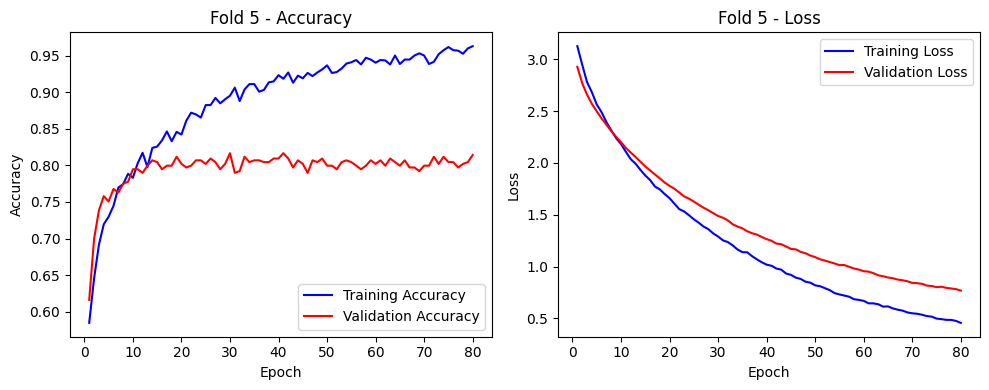

In [122]:
# Plotting MobileNetV2 tuned model
print(f"\nPlotting training history for Fold {fold + 1}...")
accuracy = history_fold_mobilenet.history['accuracy']
val_accuracy = history_fold_mobilenet.history['val_accuracy']
loss = history_fold_mobilenet.history['loss']
val_loss = history_fold_mobilenet.history['val_loss']

epochs_trained = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(epochs_trained, accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs_trained, val_accuracy, 'r', label='Validation Accuracy')
axes[0].set_title(f'Fold {fold+1} - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs_trained, loss, 'b', label='Training Loss')
axes[1].plot(epochs_trained, val_loss, 'r', label='Validation Loss')
axes[1].set_title(f'Fold {fold+1} - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [ ]:
# Tuned Model Evaluation
test_loss, test_acc = tuned_mobilenet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

In [ ]:
#Classification Report - Tuned
test_generator.reset()
predictions = tuned_mobilenet_model.predict(test_generator, verbose=0)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nFold {fold + 1} Results:")
print(f"  Test Accuracy: {test_acc * 100:.2f}%")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

# Store results - MOVED INSIDE THE LOOP
mobilenet_fold_results.append({
    'fold': fold + 1,
    'accuracy': test_acc,
    'loss': test_loss,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'history': history_fold_mobilenet
})

print('Classification Report (Tuned):')
print(classification_report(y_true, y_pred_pre, target_names=['Clean', 'Dusty']))

In [ ]:
# STEP 5: Calculate final results
print("MOBILENETV2 5-FOLD CROSS-VALIDATION RESULTS")

# Extract all metrics
accuracies = [result['accuracy'] for result in mobilenet_fold_results]
precisions = [result['precision'] for result in mobilenet_fold_results]
recalls = [result['recall'] for result in mobilenet_fold_results]
f1_scores = [result['f1_score'] for result in mobilenet_fold_results]

# Calculate means and standard deviations
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
mean_precision = np.mean(precisions)
std_precision = np.std(precisions)
mean_recall = np.mean(recalls)
std_recall = np.std(recalls)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

# Print results
print(f"\nMean Test Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")
print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")

print(f"\nDetailed Results by Fold:")
for i, result in enumerate(mobilenet_fold_results):
    print(f"Fold {i+1}: Acc={result['accuracy']*100:.1f}%, "
          f"Prec={result['precision']:.3f}, "
          f"Rec={result['recall']:.3f}, "
          f"F1={result['f1_score']:.3f}")



Plotting MobileNetV2 Cross-Validation Results...


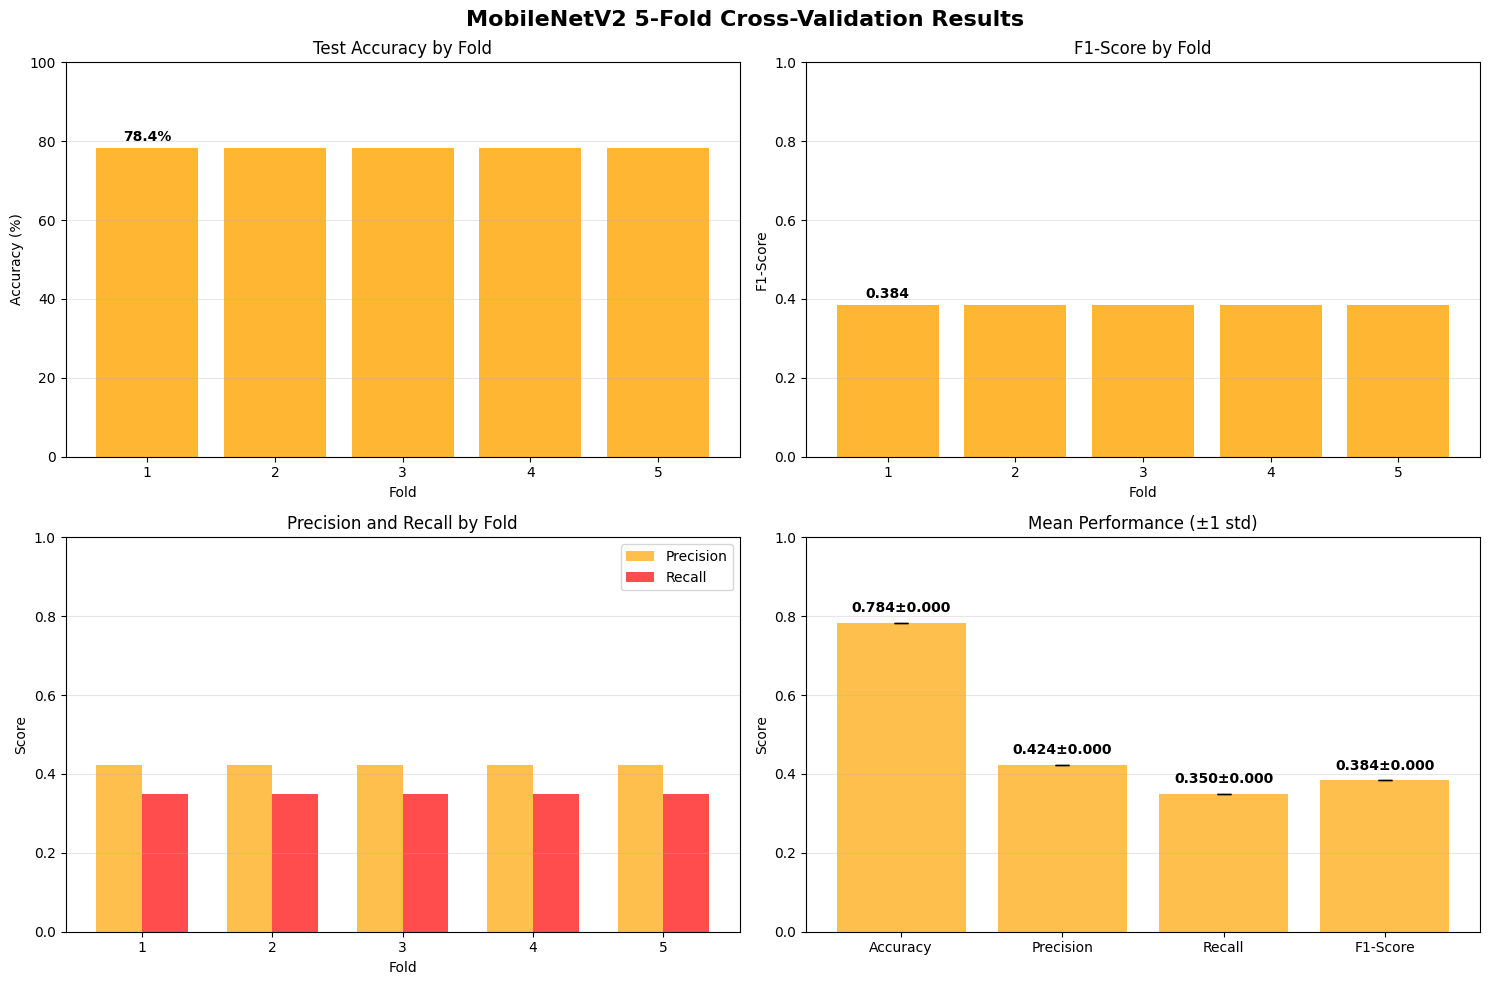

MobileNetV2 5-fold cross-validation completed successfully!


In [126]:
# STEP 6: Create comprehensive plots
print(f"\nPlotting MobileNetV2 Cross-Validation Results...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('MobileNetV2 5-Fold Cross-Validation Results', fontsize=16, fontweight='bold')

fold_numbers = list(range(1, 6))

# Plot 1: Accuracy by fold
bars1 = axes[0, 0].bar(fold_numbers, [acc * 100 for acc in accuracies], color='orange', alpha=0.8)
axes[0, 0].set_title('Test Accuracy by Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_ylim(0, 100)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{acc*100:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: F1-Score by fold
bars2 = axes[0, 1].bar(fold_numbers, f1_scores, color='orange', alpha=0.8)
axes[0, 1].set_title('F1-Score by Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, f1) in enumerate(zip(bars2, f1_scores)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Precision and Recall by fold
x = np.arange(len(fold_numbers))
width = 0.35

bars3 = axes[1, 0].bar(x - width/2, precisions, width, label='Precision', color='orange', alpha=0.7)
bars4 = axes[1, 0].bar(x + width/2, recalls, width, label='Recall', color='red', alpha=0.7)
axes[1, 0].set_title('Precision and Recall by Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(fold_numbers)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Summary statistics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
means = [mean_acc, mean_precision, mean_recall, mean_f1]
stds = [std_acc, std_precision, std_recall, std_f1]

bars5 = axes[1, 1].bar(metrics_names, means, yerr=stds, capsize=5, color='orange', alpha=0.7)
axes[1, 1].set_title('Mean Performance (±1 std)')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars5, means, stds)):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                   f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("MobileNetV2 5-fold cross-validation completed successfully!")


In [ ]:
# Final confusion matrix on the last trained model
test_generator.reset()
final_predictions = tuned_mobilenet_model.predict(test_generator)
y_pred_final = (final_predictions > 0.5).astype(int).flatten()
y_true_final = test_generator.classes

print('\nFinal Classification Report (MobileNetV2):')
print(classification_report(y_true_final, y_pred_final, target_names=['Clean', 'Dusty']))

# Confusion Matrix
cm = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clean', 'Dusty'],
            yticklabels=['Clean', 'Dusty'])
plt.title('MobileNetV2 Final Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.show()

#### 2nd Tuned (dropout = 0.2)

In [ ]:
print("=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===")

# STEP 1: Get all images and labels from train_generator
print("\nGetting all generator data for MobileNetV2...")
train_generator.reset()
all_images = []
all_labels = []

for i in range(len(train_generator)):
    batch_x, batch_y = train_generator[i]
    all_images.append(batch_x)
    all_labels.extend(batch_y)

# Convert to numpy arrays
X_all = np.vstack(all_images)
y_all = np.array(all_labels)

print(f"Total training data: {X_all.shape}")
print(f"Clean samples: {np.sum(y_all == 0)}")
print(f"Dusty samples: {np.sum(y_all == 1)}")

# STEP 2: Setup 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\n5-fold cross-validation setup complete for MobileNetV2")

# STEP 3: Store results for each fold
mobilenet_fold_results = []

# STEP 4: Loop through each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all)):
    print(f"\nTRAINING MOBILENETV2 FOLD {fold + 1}/5")

    # Split data for this fold
    X_train_fold = X_all[train_idx]
    y_train_fold = y_all[train_idx]
    X_val_fold = X_all[val_idx]
    y_val_fold = y_all[val_idx]

    print(f"\nTrain samples: {len(X_train_fold)}")
    print(f"Validation samples: {len(X_val_fold)}")

    # BUILD MODEL
    print(f"\nBuilding MobileNetV2 Model for Fold {fold + 1}...")
    tuned_mobilenet_model = Sequential([
        MobileNetV2(weights='imagenet',
                      include_top=False,
                      input_shape=(256, 256, 3)),
        GlobalAveragePooling2D(),
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dropout(0.2),
        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.2),
        Dense(1, activation='sigmoid',
              kernel_regularizer=regularizers.l2(0.01))
    ])

    # Setup Callbacks
    early_stopping = EarlyStopping(monitor='val_loss',
                                 patience=10,
                                 restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=5,
                                min_lr=0.0001)

    # Freeze the model initially
    tuned_mobilenet_model.layers[0].trainable = False

    tuned_mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

    print(f"\MobileNetV2 model built for fold {fold + 1}\n")
    tuned_mobilenet_model.summary()

In [ ]:
# TRAIN MODEL
print(f"Training Fold {fold + 1}...")

history_fold_mobilenet = tuned_mobilenet_model.fit(
    X_train_fold, y_train_fold,
    validation_data=(X_val_fold, y_val_fold),
    epochs=80,
    batch_size=32,
    class_weight = calculated_class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)


In [ ]:
# Plotting MobileNetV2 tuned model
print(f"\nPlotting training history for Fold {fold + 1}...")
accuracy = history_fold_mobilenet.history['accuracy']
val_accuracy = history_fold_mobilenet.history['val_accuracy']
loss = history_fold_mobilenet.history['loss']
val_loss = history_fold_mobilenet.history['val_loss']

epochs_trained = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(epochs_trained, accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs_trained, val_accuracy, 'r', label='Validation Accuracy')
axes[0].set_title(f'Fold {fold+1} - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs_trained, loss, 'b', label='Training Loss')
axes[1].plot(epochs_trained, val_loss, 'r', label='Validation Loss')
axes[1].set_title(f'Fold {fold+1} - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [ ]:
# Tuned Model Evaluation
test_loss, test_acc = tuned_mobilenet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

In [ ]:
#Classification Report - Tuned
test_generator.reset()
predictions = tuned_mobilenet_model.predict(test_generator, verbose=0)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nFold {fold + 1} Results:")
print(f"  Test Accuracy: {test_acc * 100:.2f}%")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

# Store results - MOVED INSIDE THE LOOP
mobilenet_fold_results.append({
    'fold': fold + 1,
    'accuracy': test_acc,
    'loss': test_loss,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'history': history_fold_mobilenet
})

print('Classification Report (Tuned):')
print(classification_report(y_true, y_pred_pre, target_names=['Clean', 'Dusty']))

In [ ]:
# STEP 5: Calculate final results
print("MOBILENETV2 5-FOLD CROSS-VALIDATION RESULTS")

# Extract all metrics
accuracies = [result['accuracy'] for result in mobilenet_fold_results]
precisions = [result['precision'] for result in mobilenet_fold_results]
recalls = [result['recall'] for result in mobilenet_fold_results]
f1_scores = [result['f1_score'] for result in mobilenet_fold_results]

# Calculate means and standard deviations
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
mean_precision = np.mean(precisions)
std_precision = np.std(precisions)
mean_recall = np.mean(recalls)
std_recall = np.std(recalls)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

# Print results
print(f"\nMean Test Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")
print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")

print(f"\nDetailed Results by Fold:")
for i, result in enumerate(mobilenet_fold_results):
    print(f"Fold {i+1}: Acc={result['accuracy']*100:.1f}%, "
          f"Prec={result['precision']:.3f}, "
          f"Rec={result['recall']:.3f}, "
          f"F1={result['f1_score']:.3f}")


In [ ]:
# STEP 6: Create comprehensive plots
print(f"\nPlotting MobileNetV2 Cross-Validation Results...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('MobileNetV2 5-Fold Cross-Validation Results', fontsize=16, fontweight='bold')

fold_numbers = list(range(1, 6))

# Plot 1: Accuracy by fold
bars1 = axes[0, 0].bar(fold_numbers, [acc * 100 for acc in accuracies], color='orange', alpha=0.8)
axes[0, 0].set_title('Test Accuracy by Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_ylim(0, 100)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{acc*100:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: F1-Score by fold
bars2 = axes[0, 1].bar(fold_numbers, f1_scores, color='orange', alpha=0.8)
axes[0, 1].set_title('F1-Score by Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, f1) in enumerate(zip(bars2, f1_scores)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Precision and Recall by fold
x = np.arange(len(fold_numbers))
width = 0.35

bars3 = axes[1, 0].bar(x - width/2, precisions, width, label='Precision', color='orange', alpha=0.7)
bars4 = axes[1, 0].bar(x + width/2, recalls, width, label='Recall', color='red', alpha=0.7)
axes[1, 0].set_title('Precision and Recall by Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(fold_numbers)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Summary statistics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
means = [mean_acc, mean_precision, mean_recall, mean_f1]
stds = [std_acc, std_precision, std_recall, std_f1]

bars5 = axes[1, 1].bar(metrics_names, means, yerr=stds, capsize=5, color='orange', alpha=0.7)
axes[1, 1].set_title('Mean Performance (±1 std)')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars5, means, stds)):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                   f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("MobileNetV2 5-fold cross-validation completed successfully!")


In [ ]:
# Final confusion matrix on the last trained model
test_generator.reset()
final_predictions = tuned_mobilenet_model.predict(test_generator)
y_pred_final = (final_predictions > 0.5).astype(int).flatten()
y_true_final = test_generator.classes

print('\nFinal Classification Report (MobileNetV2):')
print(classification_report(y_true_final, y_pred_final, target_names=['Clean', 'Dusty']))

# Confusion Matrix
cm = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clean', 'Dusty'],
            yticklabels=['Clean', 'Dusty'])
plt.title('MobileNetV2 Final Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.show()

#### 3rd Tuned (dropout = 0.1)

In [ ]:
print("=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===")

# STEP 1: Get all images and labels from train_generator
print("\nGetting all generator data for MobileNetV2...")
train_generator.reset()
all_images = []
all_labels = []

for i in range(len(train_generator)):
    batch_x, batch_y = train_generator[i]
    all_images.append(batch_x)
    all_labels.extend(batch_y)

# Convert to numpy arrays
X_all = np.vstack(all_images)
y_all = np.array(all_labels)

print(f"Total training data: {X_all.shape}")
print(f"Clean samples: {np.sum(y_all == 0)}")
print(f"Dusty samples: {np.sum(y_all == 1)}")

# STEP 2: Setup 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\n5-fold cross-validation setup complete for MobileNetV2")

# STEP 3: Store results for each fold
mobilenet_fold_results = []

# STEP 4: Loop through each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all)):
    print(f"\nTRAINING MOBILENETV2 FOLD {fold + 1}/5")

    # Split data for this fold
    X_train_fold = X_all[train_idx]
    y_train_fold = y_all[train_idx]
    X_val_fold = X_all[val_idx]
    y_val_fold = y_all[val_idx]

    print(f"\nTrain samples: {len(X_train_fold)}")
    print(f"Validation samples: {len(X_val_fold)}")

    # BUILD MODEL
    print(f"\nBuilding MobileNetV2 Model for Fold {fold + 1}...")
    tuned_mobilenet_model = Sequential([
        MobileNetV2(weights='imagenet',
                      include_top=False,
                      input_shape=(256, 256, 3)),
        GlobalAveragePooling2D(),
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dropout(0.1),
        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.1),
        Dense(1, activation='sigmoid',
              kernel_regularizer=regularizers.l2(0.01))
    ])

    # Setup Callbacks
    early_stopping = EarlyStopping(monitor='val_loss',
                                 patience=10,
                                 restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=5,
                                min_lr=0.0001)

    # Freeze the model initially
    tuned_mobilenet_model.layers[0].trainable = False

    tuned_mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

    print(f"\MobileNetV2 model built for fold {fold + 1}\n")
    tuned_mobilenet_model.summary()

In [ ]:
# TRAIN MODEL
print(f"Training Fold {fold + 1}...")

history_fold_mobilenet = tuned_mobilenet_model.fit(
    X_train_fold, y_train_fold,
    validation_data=(X_val_fold, y_val_fold),
    epochs=80,
    batch_size=32,
    class_weight = calculated_class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)


In [ ]:
# Plotting MobileNetV2 tuned model
print(f"Plotting training history for Fold {fold + 1}...")
accuracy = history_fold_mobilenet.history['accuracy']
val_accuracy = history_fold_mobilenet.history['val_accuracy']
loss = history_fold_mobilenet.history['loss']
val_loss = history_fold_mobilenet.history['val_loss']

epochs_trained = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(epochs_trained, accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs_trained, val_accuracy, 'r', label='Validation Accuracy')
axes[0].set_title(f'Fold {fold+1} - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs_trained, loss, 'b', label='Training Loss')
axes[1].plot(epochs_trained, val_loss, 'r', label='Validation Loss')
axes[1].set_title(f'Fold {fold+1} - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [ ]:
# Tuned Model Evaluation
test_loss, test_acc = tuned_mobilenet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

In [ ]:
#Classification Report - Tuned
test_generator.reset()
predictions = tuned_mobilenet_model.predict(test_generator, verbose=0)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nFold {fold + 1} Results:")
print(f"  Test Accuracy: {test_acc * 100:.2f}%")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

# Store results - MOVED INSIDE THE LOOP
mobilenet_fold_results.append({
    'fold': fold + 1,
    'accuracy': test_acc,
    'loss': test_loss,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'history': history_fold_mobilenet
})

print('Classification Report (Tuned):')
print(classification_report(y_true, y_pred_pre, target_names=['Clean', 'Dusty']))

In [ ]:
# STEP 5: Calculate final results
print("MOBILENETV2 5-FOLD CROSS-VALIDATION RESULTS")

# Extract all metrics
accuracies = [result['accuracy'] for result in mobilenet_fold_results]
precisions = [result['precision'] for result in mobilenet_fold_results]
recalls = [result['recall'] for result in mobilenet_fold_results]
f1_scores = [result['f1_score'] for result in mobilenet_fold_results]

# Calculate means and standard deviations
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
mean_precision = np.mean(precisions)
std_precision = np.std(precisions)
mean_recall = np.mean(recalls)
std_recall = np.std(recalls)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

# Print results
print(f"\nMean Test Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")
print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")

print(f"\nDetailed Results by Fold:")
for i, result in enumerate(mobilenet_fold_results):
    print(f"Fold {i+1}: Acc={result['accuracy']*100:.1f}%, "
          f"Prec={result['precision']:.3f}, "
          f"Rec={result['recall']:.3f}, "
          f"F1={result['f1_score']:.3f}")


In [ ]:
# STEP 6: Create comprehensive plots
print(f"\nPlotting MobileNetV2 Cross-Validation Results...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('MobileNetV2 5-Fold Cross-Validation Results', fontsize=16, fontweight='bold')

fold_numbers = list(range(1, 6))

# Plot 1: Accuracy by fold
bars1 = axes[0, 0].bar(fold_numbers, [acc * 100 for acc in accuracies], color='orange', alpha=0.8)
axes[0, 0].set_title('Test Accuracy by Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_ylim(0, 100)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{acc*100:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: F1-Score by fold
bars2 = axes[0, 1].bar(fold_numbers, f1_scores, color='orange', alpha=0.8)
axes[0, 1].set_title('F1-Score by Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, f1) in enumerate(zip(bars2, f1_scores)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Precision and Recall by fold
x = np.arange(len(fold_numbers))
width = 0.35

bars3 = axes[1, 0].bar(x - width/2, precisions, width, label='Precision', color='orange', alpha=0.7)
bars4 = axes[1, 0].bar(x + width/2, recalls, width, label='Recall', color='red', alpha=0.7)
axes[1, 0].set_title('Precision and Recall by Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(fold_numbers)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Summary statistics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
means = [mean_acc, mean_precision, mean_recall, mean_f1]
stds = [std_acc, std_precision, std_recall, std_f1]

bars5 = axes[1, 1].bar(metrics_names, means, yerr=stds, capsize=5, color='orange', alpha=0.7)
axes[1, 1].set_title('Mean Performance (±1 std)')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars5, means, stds)):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                   f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("MobileNetV2 5-fold cross-validation completed successfully!")


In [ ]:
# Final confusion matrix on the last trained model
test_generator.reset()
final_predictions = tuned_mobilenet_model.predict(test_generator)
y_pred_final = (final_predictions > 0.5).astype(int).flatten()
y_true_final = test_generator.classes

print('\nFinal Classification Report (MobileNetV2):')
print(classification_report(y_true_final, y_pred_final, target_names=['Clean', 'Dusty']))

# Confusion Matrix
cm = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clean', 'Dusty'],
            yticklabels=['Clean', 'Dusty'])
plt.title('MobileNetV2 Final Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.show()

## 5th Model: VGG16

### Pre-train VGG16

In [ ]:
print("\n=== 5TH MODEL: VGG16 ===")
print("\nBuilding VGG16 Pre-trained Model...")

pre_vgg_model = Sequential([
    VGG16(weights='imagenet',
                include_top=False,
                input_shape=(256, 256, 3)),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Freeze the pre-trained model initially
pre_vgg_model.layers[0].trainable = False

pre_vgg_model.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

print("VGG16 model has been built.\n")
pre_vgg_model.summary()

In [ ]:
# Train the pre-trained VGG16 model
history_pre_vgg = pre_vgg_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    class_weight=calculated_class_weights_dict
)

In [ ]:
# Plotting MobileNetV2 pre-trained model
accuracy = history_pre_vgg.history['accuracy']
val_accuracy = history_pre_vgg.history['val_accuracy']
loss = history_pre_vgg.history['loss']
val_loss = history_pre_vgg.history['val_loss']

epochs = range(1, len(accuracy) + 1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
axes[0].plot(epochs, accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs, val_accuracy, 'r', label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label='Training Loss')
axes[1].plot(epochs, val_loss, 'r', label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()


In [ ]:
# Pre-trained VGG16 Model Evaluation
vgg_test_loss, vgg_test_acc = pre_vgg_model.evaluate(test_generator)
print(f"Test Accuracy: {vgg_test_acc * 100:.2f}%")
print(f"Test Loss: {vgg_test_loss:.4f}")

In [ ]:
# Classification Report - MobileNetV2 Pre-trained
test_generator.reset()
predictions = pre_vgg_model.predict(test_generator)
print("PREDICTION DEBUGGING:")
print(f"Prediction range: {predictions.min():.3f} to {predictions.max():.3f}")
print(f"Predictions > 0.5: {np.sum(predictions > 0.5)}")
print(f"Predictions <= 0.5: {np.sum(predictions <= 0.5)}")
print(f"First 10 predictions: {predictions.flatten()[:10]}")

y_pred_vgg = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

precision = precision_score(y_true, y_pred_mobile)
recall = recall_score(y_true, y_pred_mobile)
f1 = f1_score(y_true, y_pred_mobile)

print('Classification Report (MobileNetV2 Pre-trained):')
print(classification_report(y_true, y_pred_vgg, target_names=['Clean', 'Dusty']))

In [ ]:
# Confusion Matrix for MobileNetV2
cm_pre_vgg = confusion_matrix(y_true, y_pred_vgg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_pre_vgg, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clean', 'Dusty'],
            yticklabels=['Clean', 'Dusty'])
plt.title('Confusion Matrix (MobileNetV2 Pre-trained)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Hyperparameter tuning

#### 1st Tuned (dropout = 0.3)

In [ ]:
print("=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===")

# STEP 1: Get all images and labels from train_generator
print("\nGetting all generator data for VGG16...")
train_generator.reset()
all_images = []
all_labels = []

for i in range(len(train_generator)):
    batch_x, batch_y = train_generator[i]
    all_images.append(batch_x)
    all_labels.extend(batch_y)

# Convert to numpy arrays
X_all = np.vstack(all_images)
y_all = np.array(all_labels)

print(f"Total training data: {X_all.shape}")
print(f"Clean samples: {np.sum(y_all == 0)}")
print(f"Dusty samples: {np.sum(y_all == 1)}")

# STEP 2: Setup 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\n5-fold cross-validation setup complete for VGG16")

# STEP 3: Store results for each fold
vgg_fold_results = []

# STEP 4: Loop through each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all)):
    print(f"\nTRAINING VGG16 FOLD {fold + 1}/5")

    # Split data for this fold
    X_train_fold = X_all[train_idx]
    y_train_fold = y_all[train_idx]
    X_val_fold = X_all[val_idx]
    y_val_fold = y_all[val_idx]

    print(f"\nTrain samples: {len(X_train_fold)}")
    print(f"Validation samples: {len(X_val_fold)}")

    # BUILD MODEL
    print(f"\nBuilding VGG16 Model for Fold {fold + 1}...")
    tuned_vgg_model = Sequential([
        VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(256, 256, 3)),
        GlobalAveragePooling2D(),
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dropout(0.3),
        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.3),
        Dense(1, activation='sigmoid',
              kernel_regularizer=regularizers.l2(0.01))
    ])

    # Setup Callbacks
    early_stopping = EarlyStopping(monitor='val_loss',
                                 patience=10,
                                 restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=5,
                                min_lr=0.0001)

    # Freeze the model initially
    tuned_vgg_model.layers[0].trainable = False

    tuned_vgg_model.compile(optimizer=Adam(learning_rate=0.0001),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

    print(f"\nVGG16 model built for fold {fold + 1}\n")
    tuned_vgg_model.summary()

In [ ]:
# TRAIN MODEL
print(f"Training Fold {fold + 1}...")

history_fold_vgg = tuned_vgg_model.fit(
    X_train_fold, y_train_fold,
    validation_data=(X_val_fold, y_val_fold),
    epochs=80,
    batch_size=32,
    class_weight = calculated_class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)


In [ ]:
# Plotting VGG16 tuned model
print(f"Plotting training history for Fold {fold + 1}...")
accuracy = history_fold_vgg.history['accuracy']
val_accuracy = history_fold_vgg.history['val_accuracy']
loss = history_fold_vgg.history['loss']
val_loss = history_fold_vgg.history['val_loss']

epochs_trained = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(epochs_trained, accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs_trained, val_accuracy, 'r', label='Validation Accuracy')
axes[0].set_title(f'Fold {fold+1} - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs_trained, loss, 'b', label='Training Loss')
axes[1].plot(epochs_trained, val_loss, 'r', label='Validation Loss')
axes[1].set_title(f'Fold {fold+1} - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [ ]:
# Tuned Model Evaluation
test_loss, test_acc = tuned_vgg_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

In [ ]:
#Classification Report - Tuned
test_generator.reset()
predictions = tuned_vgg_model.predict(test_generator, verbose=0)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nFold {fold + 1} Results:")
print(f"  Test Accuracy: {test_acc * 100:.2f}%")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

# Store results - MOVED INSIDE THE LOOP
vgg_fold_results.append({
    'fold': fold + 1,
    'accuracy': test_acc,
    'loss': test_loss,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'history': history_fold_vgg
})

print('Classification Report (Tuned):')
print(classification_report(y_true, y_pred_pre, target_names=['Clean', 'Dusty']))

In [ ]:
# STEP 5: Calculate final results
print("VGG16 5-FOLD CROSS-VALIDATION RESULTS")

# Extract all metrics
accuracies = [result['accuracy'] for result in vgg_fold_results]
precisions = [result['precision'] for result in vgg_fold_results]
recalls = [result['recall'] for result in vgg_fold_results]
f1_scores = [result['f1_score'] for result in vgg_fold_results]

# Calculate means and standard deviations
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
mean_precision = np.mean(precisions)
std_precision = np.std(precisions)
mean_recall = np.mean(recalls)
std_recall = np.std(recalls)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

# Print results
print(f"\nMean Test Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")
print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")

print(f"\nDetailed Results by Fold:")
for i, result in enumerate(vgg_fold_results):
    print(f"Fold {i+1}: Acc={result['accuracy']*100:.1f}%, "
          f"Prec={result['precision']:.3f}, "
          f"Rec={result['recall']:.3f}, "
          f"F1={result['f1_score']:.3f}")


In [ ]:
# STEP 6: Create comprehensive plots
print(f"\nPlotting VGG16 Cross-Validation Results...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('VGG16 5-Fold Cross-Validation Results', fontsize=16, fontweight='bold')

fold_numbers = list(range(1, 6))

# Plot 1: Accuracy by fold
bars1 = axes[0, 0].bar(fold_numbers, [acc * 100 for acc in accuracies], color='orange', alpha=0.8)
axes[0, 0].set_title('Test Accuracy by Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_ylim(0, 100)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{acc*100:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: F1-Score by fold
bars2 = axes[0, 1].bar(fold_numbers, f1_scores, color='orange', alpha=0.8)
axes[0, 1].set_title('F1-Score by Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, f1) in enumerate(zip(bars2, f1_scores)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Precision and Recall by fold
x = np.arange(len(fold_numbers))
width = 0.35

bars3 = axes[1, 0].bar(x - width/2, precisions, width, label='Precision', color='orange', alpha=0.7)
bars4 = axes[1, 0].bar(x + width/2, recalls, width, label='Recall', color='red', alpha=0.7)
axes[1, 0].set_title('Precision and Recall by Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(fold_numbers)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Summary statistics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
means = [mean_acc, mean_precision, mean_recall, mean_f1]
stds = [std_acc, std_precision, std_recall, std_f1]

bars5 = axes[1, 1].bar(metrics_names, means, yerr=stds, capsize=5, color='orange', alpha=0.7)
axes[1, 1].set_title('Mean Performance (±1 std)')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars5, means, stds)):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                   f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("VGG16 5-fold cross-validation completed successfully!")


In [ ]:
# Final confusion matrix on the last trained model
test_generator.reset()
final_predictions = tuned_vgg_model.predict(test_generator)
y_pred_final = (final_predictions > 0.5).astype(int).flatten()
y_true_final = test_generator.classes

print('\nFinal Classification Report (VGG16):')
print(classification_report(y_true_final, y_pred_final, target_names=['Clean', 'Dusty']))

# Confusion Matrix
cm = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clean', 'Dusty'],
            yticklabels=['Clean', 'Dusty'])
plt.title('VGG16 Final Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.show()

#### 2nd Tuned (dropout = 0.2)

In [ ]:
print("=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===")

# STEP 1: Get all images and labels from train_generator
print("\nGetting all generator data for VGG16...")
train_generator.reset()
all_images = []
all_labels = []

for i in range(len(train_generator)):
    batch_x, batch_y = train_generator[i]
    all_images.append(batch_x)
    all_labels.extend(batch_y)

# Convert to numpy arrays
X_all = np.vstack(all_images)
y_all = np.array(all_labels)

print(f"Total training data: {X_all.shape}")
print(f"Clean samples: {np.sum(y_all == 0)}")
print(f"Dusty samples: {np.sum(y_all == 1)}")

# STEP 2: Setup 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\n5-fold cross-validation setup complete for VGG16")

# STEP 3: Store results for each fold
vgg_fold_results = []

# STEP 4: Loop through each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all)):
    print(f"\nTRAINING VGG16 FOLD {fold + 1}/5")

    # Split data for this fold
    X_train_fold = X_all[train_idx]
    y_train_fold = y_all[train_idx]
    X_val_fold = X_all[val_idx]
    y_val_fold = y_all[val_idx]

    print(f"\nTrain samples: {len(X_train_fold)}")
    print(f"Validation samples: {len(X_val_fold)}")

    # BUILD MODEL
    print(f"\nBuilding VGG16 Model for Fold {fold + 1}...")
    tuned_vgg_model = Sequential([
        VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(256, 256, 3)),
        GlobalAveragePooling2D(),
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dropout(0.2),
        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.2),
        Dense(1, activation='sigmoid',
              kernel_regularizer=regularizers.l2(0.01))
    ])

    # Setup Callbacks
    early_stopping = EarlyStopping(monitor='val_loss',
                                 patience=10,
                                 restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=5,
                                min_lr=0.0001)

    # Freeze the model initially
    tuned_vgg_model.layers[0].trainable = False

    tuned_vgg_model.compile(optimizer=Adam(learning_rate=0.0001),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

    print(f"\nVGG16 model built for fold {fold + 1}\n")
    tuned_vgg_model.summary()

In [ ]:
# TRAIN MODEL
print(f"Training Fold {fold + 1}...")

history_fold_vgg = tuned_vgg_model.fit(
    X_train_fold, y_train_fold,
    validation_data=(X_val_fold, y_val_fold),
    epochs=80,
    batch_size=32,
    class_weight = calculated_class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)


In [ ]:
# Plotting VGG16 tuned model
print(f"Plotting training history for Fold {fold + 1}...")
accuracy = history_fold_vgg.history['accuracy']
val_accuracy = history_fold_vgg.history['val_accuracy']
loss = history_fold_vgg.history['loss']
val_loss = history_fold_vgg.history['val_loss']

epochs_trained = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(epochs_trained, accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs_trained, val_accuracy, 'r', label='Validation Accuracy')
axes[0].set_title(f'Fold {fold+1} - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs_trained, loss, 'b', label='Training Loss')
axes[1].plot(epochs_trained, val_loss, 'r', label='Validation Loss')
axes[1].set_title(f'Fold {fold+1} - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [ ]:
# Tuned Model Evaluation
test_loss, test_acc = tuned_vgg_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

In [ ]:
#Classification Report - Tuned
test_generator.reset()
predictions = tuned_vgg_model.predict(test_generator, verbose=0)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nFold {fold + 1} Results:")
print(f"  Test Accuracy: {test_acc * 100:.2f}%")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

# Store results - MOVED INSIDE THE LOOP
vgg_fold_results.append({
    'fold': fold + 1,
    'accuracy': test_acc,
    'loss': test_loss,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'history': history_fold_vgg
})

print('Classification Report (Tuned):')
print(classification_report(y_true, y_pred_pre, target_names=['Clean', 'Dusty']))

In [ ]:
# STEP 5: Calculate final results
print("VGG16 5-FOLD CROSS-VALIDATION RESULTS")

# Extract all metrics
accuracies = [result['accuracy'] for result in vgg_fold_results]
precisions = [result['precision'] for result in vgg_fold_results]
recalls = [result['recall'] for result in vgg_fold_results]
f1_scores = [result['f1_score'] for result in vgg_fold_results]

# Calculate means and standard deviations
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
mean_precision = np.mean(precisions)
std_precision = np.std(precisions)
mean_recall = np.mean(recalls)
std_recall = np.std(recalls)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

# Print results
print(f"\nMean Test Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")
print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")

print(f"\nDetailed Results by Fold:")
for i, result in enumerate(vgg_fold_results):
    print(f"Fold {i+1}: Acc={result['accuracy']*100:.1f}%, "
          f"Prec={result['precision']:.3f}, "
          f"Rec={result['recall']:.3f}, "
          f"F1={result['f1_score']:.3f}")


In [ ]:
# STEP 6: Create comprehensive plots
print(f"\nPlotting VGG16 Cross-Validation Results...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('VGG16 5-Fold Cross-Validation Results', fontsize=16, fontweight='bold')

fold_numbers = list(range(1, 6))

# Plot 1: Accuracy by fold
bars1 = axes[0, 0].bar(fold_numbers, [acc * 100 for acc in accuracies], color='orange', alpha=0.8)
axes[0, 0].set_title('Test Accuracy by Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_ylim(0, 100)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{acc*100:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: F1-Score by fold
bars2 = axes[0, 1].bar(fold_numbers, f1_scores, color='orange', alpha=0.8)
axes[0, 1].set_title('F1-Score by Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, f1) in enumerate(zip(bars2, f1_scores)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Precision and Recall by fold
x = np.arange(len(fold_numbers))
width = 0.35

bars3 = axes[1, 0].bar(x - width/2, precisions, width, label='Precision', color='orange', alpha=0.7)
bars4 = axes[1, 0].bar(x + width/2, recalls, width, label='Recall', color='red', alpha=0.7)
axes[1, 0].set_title('Precision and Recall by Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(fold_numbers)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Summary statistics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
means = [mean_acc, mean_precision, mean_recall, mean_f1]
stds = [std_acc, std_precision, std_recall, std_f1]

bars5 = axes[1, 1].bar(metrics_names, means, yerr=stds, capsize=5, color='orange', alpha=0.7)
axes[1, 1].set_title('Mean Performance (±1 std)')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars5, means, stds)):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                   f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("VGG16 5-fold cross-validation completed successfully!")


In [ ]:
# Final confusion matrix on the last trained model
test_generator.reset()
final_predictions = tuned_vgg_model.predict(test_generator)
y_pred_final = (final_predictions > 0.5).astype(int).flatten()
y_true_final = test_generator.classes

print('\nFinal Classification Report (VGG16):')
print(classification_report(y_true_final, y_pred_final, target_names=['Clean', 'Dusty']))

# Confusion Matrix
cm = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clean', 'Dusty'],
            yticklabels=['Clean', 'Dusty'])
plt.title('VGG16 Final Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.show()

#### 3rd Tuned (dropout = 0.1)

In [ ]:
print("=== CNN MODEL DEVELOPMENT WITH 5-FOLD CROSS-VALIDATION ===")

# STEP 1: Get all images and labels from train_generator
print("\nGetting all generator data for VGG16...")
train_generator.reset()
all_images = []
all_labels = []

for i in range(len(train_generator)):
    batch_x, batch_y = train_generator[i]
    all_images.append(batch_x)
    all_labels.extend(batch_y)

# Convert to numpy arrays
X_all = np.vstack(all_images)
y_all = np.array(all_labels)

print(f"Total training data: {X_all.shape}")
print(f"Clean samples: {np.sum(y_all == 0)}")
print(f"Dusty samples: {np.sum(y_all == 1)}")

# STEP 2: Setup 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\n5-fold cross-validation setup complete for VGG16")

# STEP 3: Store results for each fold
vgg_fold_results = []

# STEP 4: Loop through each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all)):
    print(f"\nTRAINING VGG16 FOLD {fold + 1}/5")

    # Split data for this fold
    X_train_fold = X_all[train_idx]
    y_train_fold = y_all[train_idx]
    X_val_fold = X_all[val_idx]
    y_val_fold = y_all[val_idx]

    print(f"\nTrain samples: {len(X_train_fold)}")
    print(f"Validation samples: {len(X_val_fold)}")

    # BUILD MODEL
    print(f"\nBuilding VGG16 Model for Fold {fold + 1}...")
    tuned_vgg_model = Sequential([
        VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(256, 256, 3)),
        GlobalAveragePooling2D(),
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dropout(0.1),
        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.1),
        Dense(1, activation='sigmoid',
              kernel_regularizer=regularizers.l2(0.01))
    ])

    # Setup Callbacks
    early_stopping = EarlyStopping(monitor='val_loss',
                                 patience=10,
                                 restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=5,
                                min_lr=0.0001)

    # Freeze the model initially
    tuned_vgg_model.layers[0].trainable = False

    tuned_vgg_model.compile(optimizer=Adam(learning_rate=0.0001),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

    print(f"\nVGG16 model built for fold {fold + 1}\n")
    tuned_vgg_model.summary()

In [ ]:
# TRAIN MODEL
print(f"Training Fold {fold + 1}...")

history_fold_vgg = tuned_vgg_model.fit(
    X_train_fold, y_train_fold,
    validation_data=(X_val_fold, y_val_fold),
    epochs=80,
    batch_size=32,
    class_weight = calculated_class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)


In [ ]:
# Plotting VGG16 tuned model
print(f"Plotting training history for Fold {fold + 1}...")
accuracy = history_fold_vgg.history['accuracy']
val_accuracy = history_fold_vgg.history['val_accuracy']
loss = history_fold_vgg.history['loss']
val_loss = history_fold_vgg.history['val_loss']

epochs_trained = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(epochs_trained, accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs_trained, val_accuracy, 'r', label='Validation Accuracy')
axes[0].set_title(f'Fold {fold+1} - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs_trained, loss, 'b', label='Training Loss')
axes[1].plot(epochs_trained, val_loss, 'r', label='Validation Loss')
axes[1].set_title(f'Fold {fold+1} - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [ ]:
# Tuned Model Evaluation
test_loss, test_acc = tuned_vgg_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

In [ ]:
#Classification Report - Tuned
test_generator.reset()
predictions = tuned_vgg_model.predict(test_generator, verbose=0)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nFold {fold + 1} Results:")
print(f"  Test Accuracy: {test_acc * 100:.2f}%")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

# Store results - MOVED INSIDE THE LOOP
vgg_fold_results.append({
    'fold': fold + 1,
    'accuracy': test_acc,
    'loss': test_loss,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'history': history_fold_vgg
})

print('Classification Report (Tuned):')
print(classification_report(y_true, y_pred_pre, target_names=['Clean', 'Dusty']))

In [ ]:
# STEP 5: Calculate final results
print("VGG16 5-FOLD CROSS-VALIDATION RESULTS")

# Extract all metrics
accuracies = [result['accuracy'] for result in vgg_fold_results]
precisions = [result['precision'] for result in vgg_fold_results]
recalls = [result['recall'] for result in vgg_fold_results]
f1_scores = [result['f1_score'] for result in vgg_fold_results]

# Calculate means and standard deviations
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
mean_precision = np.mean(precisions)
std_precision = np.std(precisions)
mean_recall = np.mean(recalls)
std_recall = np.std(recalls)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

# Print results
print(f"\nMean Test Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")
print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")

print(f"\nDetailed Results by Fold:")
for i, result in enumerate(vgg_fold_results):
    print(f"Fold {i+1}: Acc={result['accuracy']*100:.1f}%, "
          f"Prec={result['precision']:.3f}, "
          f"Rec={result['recall']:.3f}, "
          f"F1={result['f1_score']:.3f}")


In [ ]:
# STEP 6: Create comprehensive plots
print(f"\nPlotting VGG16 Cross-Validation Results...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('VGG16 5-Fold Cross-Validation Results', fontsize=16, fontweight='bold')

fold_numbers = list(range(1, 6))

# Plot 1: Accuracy by fold
bars1 = axes[0, 0].bar(fold_numbers, [acc * 100 for acc in accuracies], color='orange', alpha=0.8)
axes[0, 0].set_title('Test Accuracy by Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_ylim(0, 100)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{acc*100:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: F1-Score by fold
bars2 = axes[0, 1].bar(fold_numbers, f1_scores, color='orange', alpha=0.8)
axes[0, 1].set_title('F1-Score by Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, f1) in enumerate(zip(bars2, f1_scores)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Precision and Recall by fold
x = np.arange(len(fold_numbers))
width = 0.35

bars3 = axes[1, 0].bar(x - width/2, precisions, width, label='Precision', color='orange', alpha=0.7)
bars4 = axes[1, 0].bar(x + width/2, recalls, width, label='Recall', color='red', alpha=0.7)
axes[1, 0].set_title('Precision and Recall by Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(fold_numbers)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Summary statistics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
means = [mean_acc, mean_precision, mean_recall, mean_f1]
stds = [std_acc, std_precision, std_recall, std_f1]

bars5 = axes[1, 1].bar(metrics_names, means, yerr=stds, capsize=5, color='orange', alpha=0.7)
axes[1, 1].set_title('Mean Performance (±1 std)')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars5, means, stds)):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                   f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("VGG16 5-fold cross-validation completed successfully!")


In [ ]:
# Final confusion matrix on the last trained model
test_generator.reset()
final_predictions = tuned_vgg_model.predict(test_generator)
y_pred_final = (final_predictions > 0.5).astype(int).flatten()
y_true_final = test_generator.classes

print('\nFinal Classification Report (VGG16):')
print(classification_report(y_true_final, y_pred_final, target_names=['Clean', 'Dusty']))

# Confusion Matrix
cm = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clean', 'Dusty'],
            yticklabels=['Clean', 'Dusty'])
plt.title('VGG16 Final Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.show()

# Model Comparison

In [ ]:
print("=== MODEL TRAINING AND EVALUATION ===")
print("\nStep 1: Loading all trained models...")

all_images = {
    'EfficientNetB3': tuned_effi_model,
    'DenseNet121': tuned_densenet_model,
    'ResNet50': tuned_resnet_model,
    'MobileNetV2': tuned_mobilenet_model,
    'VGG16': tuned_vgg_model
}

print(f"\n Total models to evaluate: {len(all_models)}")
for model_name in all_models.keys():
    print(f"{model_name}")

print("\nStep 2: Evaluating all models on test data...")
model_results = {}

for model_name, model in all_models.items():
    print(f"\nEvaluating {model_name}...")

    # Model prediction
    test_generator.reset()
    test_loss, test_acc = model.evaluate(test_generator)

    # Detailed predictions
    predictions = model.predict(test_generator, verbose=0)
    y_pred = (predictions > 0.5).astype(int).flatten()
    y_true = test_generator.classes

    # Calcualte metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Store results
    model_results[model_name] = {
        'accuracy': test_acc,
        'loss': test_loss,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'y_true': y_true,
        'y_pred': y_pred
    }

    print(f"{model_name} - Test Accuracy: {test_acc * 100:.2f}%")
    print(f"{model_name} - Test Loss: {test_loss:.4f}")
    print(f"{model_name} - Precision: {precision:.4f}")
    print(f"{model_name} - Recall: {recall:.4f}")
    print(f"{model_name} - F1-Score: {f1:.4f}")

print("\nStep 3: Comparing models...")
results_df = pd.DataFrame({
    model: {
        'Accuracy': results['accuracy'],
        'Loss': results['loss'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1_score']
    }
    for model, results in model_results.items()
}).T

print("\nComplete Result Table:")
print(results_df.round(4))

In [ ]:
print("\nStep 4: Identifying best performers...")

best_accuracy = results_df['Accuracy'].max()
best_accuracy_model = results_df['Accuracy'].idxmax()

best_precision = results_df['Precision'].max()
best_precision_model = results_df['Precision'].idxmax()

best_recall = results_df['Recall'].max()
best_recall_model = results_df['Recall'].idxmax()

best_f1 = results_df['F1-Score'].max()
best_f1_model = results_df['F1-Score'].idxmax()

print(f"Best Accuracy: {best_accuracy_model} ({best_accuracy:.4f})")
print(f"Best Precision: {best_precision_model} ({best_precision:.4f})")
print(f"Best Recall: {best_recall_model} ({best_recall:.4f})")
print(f"Best F1-Score: {best_f1_model} ({best_f1:.4f})")

In [ ]:
# Step 5: Create visualizations
print("\nStep 5: Creating performance visualizations...")

# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Phase 4: Comprehensive Model Evaluation Results', fontsize=16, fontweight='bold')

models = list(results_df.index)
colors = ['blue', 'green', 'orange', 'lightcoral', 'yellow']

# Plot 1: Accuracy Comparison
accuracies = results_df['Accuracy'].values
bars1 = axes[0, 0].bar(models, accuracies, color=colors, alpha=0.8)
axes[0, 0].set_title('Model Accuracy Comparison', fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_ylim(0.7, 1.0)

for bar, acc in zip(bars1, accuracies):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: F1-Score Comparison
f1_scores = results_df['F1-Score'].values
bars2 = axes[0, 1].bar(models, f1_scores, color=colors, alpha=0.8)
axes[0, 1].set_title('F1-Score Comparison', fontweight='bold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylim(0.7, 1.0)

for bar, f1 in zip(bars2, f1_scores):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Precision vs Recall Scatter
precisions = results_df['Precision'].values
recalls = results_df['Recall'].values
scatter = axes[0, 2].scatter(precisions, recalls, s=200, c=colors, alpha=0.8)
axes[0, 2].set_xlabel('Precision')
axes[0, 2].set_ylabel('Recall')
axes[0, 2].set_title('Precision vs Recall Analysis', fontweight='bold')

for i, model in enumerate(models):
    axes[0, 2].annotate(model, (precisions[i], recalls[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=9)

# Plot 4: All Metrics Radar Chart Style
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.15

for i, model in enumerate(models):
    values = [results_df.loc[model, metric] for metric in metrics]
    axes[1, 0].bar(x + i*width, values, width, label=model, alpha=0.8, color=colors[i])

axes[1, 0].set_xlabel('Metrics')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('All Metrics Comparison', fontweight='bold')
axes[1, 0].set_xticks(x + width * 2)
axes[1, 0].set_xticklabels(metrics)
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 5: Performance Ranking
ranking_df = results_df.sort_values('F1-Score', ascending=True)
bars5 = axes[1, 1].barh(range(len(ranking_df)), ranking_df['F1-Score'], color=colors)
axes[1, 1].set_yticks(range(len(ranking_df)))
axes[1, 1].set_yticklabels(ranking_df.index)
axes[1, 1].set_xlabel('F1-Score')
axes[1, 1].set_title('Model Ranking by F1-Score', fontweight='bold')

for i, (bar, score) in enumerate(zip(bars5, ranking_df['F1-Score'])):
    axes[1, 1].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
                   f'{score:.3f}', ha='left', va='center', fontweight='bold')

# Plot 6: Loss Comparison
losses = results_df['Loss'].values
bars6 = axes[1, 2].bar(models, losses, color=colors, alpha=0.8)
axes[1, 2].set_title('Model Loss Comparison (Lower is Better)', fontweight='bold')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].tick_params(axis='x', rotation=45)

for bar, loss in zip(bars6, losses):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                   f'{loss:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Step 6: Create confusion matrices for top models
print("Step 6: Creating confusion matrices for all models...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices for All Models', fontsize=16, fontweight='bold')

axes = axes.flatten()

for i, (model_name, results) in enumerate(model_results.items()):
    if i < len(axes):
        cm = confusion_matrix(results['y_true'], results['y_pred'])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                   xticklabels=['Clean', 'Dusty'],
                   yticklabels=['Clean', 'Dusty'])
        axes[i].set_title(f'{model_name}\nAcc: {results["accuracy"]:.3f}', fontweight='bold')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()


In [ ]:
# Step 7: Detailed analysis and recommendations
print("Step 7: Detailed Analysis and Recommendations...")

print("COMPREHENSIVE PERFORMANCE ANALYSIS")

# Statistical analysis
print("\n1. STATISTICAL SUMMARY:")
print("-" * 25)
print(results_df.describe().round(4))

# Performance gaps
print("\n2. PERFORMANCE GAPS ANALYSIS:")
print("-" * 32)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    max_val = results_df[metric].max()
    min_val = results_df[metric].min()
    gap = max_val - min_val
    print(f"{metric}: {min_val:.4f} - {max_val:.4f} (Gap: {gap:.4f})")

# Business impact analysis
print("\n3. BUSINESS IMPACT ANALYSIS:")
print("-" * 30)

# Calculate false positives and false negatives for best model
best_model_name = best_f1_model
best_results = model_results[best_model_name]
cm = confusion_matrix(best_results['y_true'], best_results['y_pred'])

tn, fp, fn, tp = cm.ravel()
total_samples = len(best_results['y_true'])

print(f"Best Model: {best_model_name}")
print(f"True Positives (Dusty detected): {tp}")
print(f"True Negatives (Clean detected): {tn}")
print(f"False Positives (Over-cleaning risk): {fp} ({fp/total_samples*100:.1f}%)")
print(f"False Negatives (Missed dust risk): {fn} ({fn/total_samples*100:.1f}%)")



In [ ]:
# Final recommendation
print("FINAL RECOMMENDATION")

print(f"\nRECOMMENDED MODEL: {best_f1_model}")
print(f"Justification: Best F1-Score balance of precision and recall")
print(f"Performance Summary:")
print(f"  - Accuracy: {model_results[best_f1_model]['accuracy']:.4f}")
print(f"  - Precision: {model_results[best_f1_model]['precision']:.4f}")
print(f"  - Recall: {model_results[best_f1_model]['recall']:.4f}")
print(f"  - F1-Score: {model_results[best_f1_model]['f1_score']:.4f}")

print(f"\nBusiness Benefits:")
print(f"  - Optimal balance of dust detection and false alarms")
print(f"  - Minimizes unnecessary cleaning costs")
print(f"  - Maximizes energy efficiency through reliable dust detection")

# Sequential Dust Accumulation Analysis

## Alert system

# Create a interface to let user upload images
